In [327]:
# Boilerplate from Randy cheatsheet at https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#
import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas import GeoSeries, GeoDataFrame
import re
%matplotlib inline
pd.set_option('display.max_columns', 500)

# Wide display
from IPython.core.display import display, HTML
display(HTML("<style>#notebook-container { margin-left:-14px; width:calc(100% + 27px) !important; }</style>"))

In [58]:
import pandas as pd
import csv, json, os, math, numbers, pandas, re, scipy, scipy.sparse, shutil
import struct, subprocess, sys, threading, time, urllib2
import sqlite3, thread, urllib, dateparser
from datetime import timedelta

def exec_ipynb(filename_or_url):
    nb = (urllib2.urlopen(filename_or_url) if re.match(r'https?:', filename_or_url) else open(filename_or_url)).read()
    jsonNb = json.loads(nb)
    #check for the modified formatting of Jupyter Notebook v4
    if(jsonNb['nbformat'] == 4):
        exec '\n'.join([''.join(cell['source']) for cell in jsonNb['cells'] if cell['cell_type'] == 'code']) in globals()
    else:
        exec '\n'.join([''.join(cell['input']) for cell in jsonNb['worksheets'][0]['cells'] if cell['cell_type'] == 'code']) in globals()

exec_ipynb('timelapse-utilities.ipynb')

In [230]:
exec_ipynb('colormaps.ipynb')

In [3]:
def get_segments_from_ring(r):
    ret = set()
    for i in range(0, len(r)):
        ret.add((r[i - 1][0], r[i - 1][1], r[i][0], r[i][1]))
    return ret

def get_segments_from_polygon(p):
    return set.union(*[get_segments_from_ring(r) for r in p])

def get_segments_from_multipolygon(mp):
    return set.union(*[get_segments_from_polygon(p) for p in mp])

def get_segments(g):
    if 'features' in g:
        return set.union(*[get_segments(f) for f in g['features']])
    elif 'geometry' in g:
        if g['geometry']['type'] == 'Polygon':
            return get_segments_from_polygon(g['geometry']['coordinates'])
        elif g['geometry']['type'] == 'MultiPolygon':
            return get_segments_from_multipolygon(g['geometry']['coordinates'])
        else:
            raise Exception('unrecognized geometry type %s' % g['geometry']['type'])
    else:
        raise 'unrecognized type'
        
def LonLatToWebMercator(lon, lat):
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def WebMercatorToLonLat(x,y):
    lat = math.atan(math.exp((128.0 - y) * math.pi / 128.0)) * 360.0 / math.pi - 90.0
    lon = x * 360.0 / 256.0 - 180.0
    return [lon, lat]

def project_and_binarize_segment(segment, dest):
    (x1, y1) = LonLatToWebMercator(segment[0], segment[1])
    (x2, y2) = LonLatToWebMercator(segment[2], segment[3])
    dest.write(struct.pack('<ffff', x1, y1, x2, y2))

def binarize_geojson_outlines(src, dest):
    gj = json.load(open(src))
    print 'Read %d features from %s' % (len(gj['features']), src)
    segments = get_segments(gj)
    print '%d segments' % len(segments)

    try:
        os.makedirs(os.path.dirname(dest))
    except OSError:
        pass
        
    out = open(dest + '.tmp', 'w')
    for segment in segments:
        project_and_binarize_segment(segment, out)
    out.close()
    os.rename(dest + '.tmp', dest)
    print 'Created %s (%d segments)' % (dest, os.stat(dest).st_size / 16)
        

In [4]:
pandas.options.display.max_colwidth = 300
pandas.set_option('display.max_columns', 500)

# Read in 2018 US House boundaries

In [11]:
ush_2018 = gpd.read_file('voting/Remedial Plan Shapefile.shp').to_crs(epsg=4326)

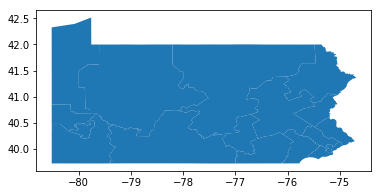

In [12]:
ush_2018.plot()

In [ ]:
ush_2018

In [14]:
# Create a GeoDataFrame that just has DISTRICT and geometry
ush_out_2018 = gpd.GeoDataFrame(ush_2018[['DISTRICT']], geometry=ush_2018.geometry,crs={'init': 'epsg:4326'})

In [ ]:
ush_out_2018

In [16]:
# Write out the 2018 US House geometry as a geojson file
ush_out_2018.to_file('voting/pa_us_house_boundaries_2018.geojson', driver="GeoJSON")

In [17]:
binarize_geojson_outlines('voting/pa_us_house_boundaries_2018.geojson', 
                          'voting/pa_us_house_boundaries_2018.bin')

Read 18 features from voting/pa_us_house_boundaries_2018.geojson
112242 segments
Created voting/pa_us_house_boundaries_2018.bin (112242 segments)


# Read in 2018 PA House boundaries

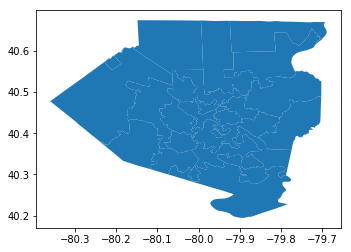

In [456]:
pah_2018 = gpd.read_file('voting/Allegheny_County_Pennsylvania_House_of_Representatives_District_Boundaries.shp').to_crs(epsg=4326)
pah_2018.plot()

In [ ]:
pah_2018

In [458]:
# Write out the 2018 PA House geometry as a geojson file
pah_2018.to_file('voting/ac_pa_house_boundaries_2018.geojson', driver="GeoJSON"
binarize_geojson_outlines('voting/ac_pa_house_boundaries_2018.geojson', 
                          'voting/ac_pa_house_boundaries_2018.bin')

Read 23 features from voting/ac_pa_house_boundaries_2018.geojson
24593 segments
Created voting/ac_pa_house_boundaries_2018.bin (24593 segments)


# Read in 2018 PA Senate boundaries

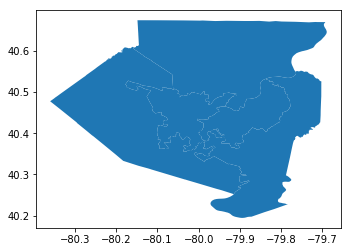

In [459]:
pas_2018 = gpd.read_file('voting/Allegheny_County_Pennsylvania_Senate_District_Boundaries.shp').to_crs(epsg=4326)
pas_2018.plot()

In [ ]:
pas_2018

In [461]:
# Write out the 2018 PA Senate geometry as a geojson file
pas_2018.to_file('voting/ac_pa_senate_boundaries_2018.geojson', driver="GeoJSON")

binarize_geojson_outlines('voting/ac_pa_senate_boundaries_2018.geojson', 
                          'voting/ac_pa_senate_boundaries_2018.bin')

Read 5 features from voting/ac_pa_senate_boundaries_2018.geojson
8906 segments
Created voting/ac_pa_senate_boundaries_2018.bin (8906 segments)


# Polling places

In [116]:
# Get old polling place locations
pp_2017 = gpd.read_file('voting/Polling_Place_Locations_May_2017.shp').to_crs(epsg=4326)

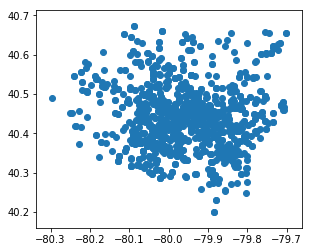

In [41]:
pp_2017.plot()

In [ ]:
pp_2017

In [ ]:
pp_2017[pp_2017.MWD2.duplicated()]

In [ ]:
pp_2017[pp_2017.MWD2==1881926]

In [119]:
# Get rid of Brookline terrace based on discussion with David Hoyt
# on 10/25/18
pp_2017 = pp_2017[~(pp_2017.MWD2.duplicated())]

In [124]:
# Get intermediate polling place locations
pp_2018_05 = gpd.read_file('voting/PollingPlaces2018_May.shp').to_crs(epsg=4326)


In [ ]:
pp_2018_05[pp_2018_05.MWD2.duplicated()]

In [125]:
pp_2018_05 = pp_2018_05[~pp_2018_05.MWD2.duplicated()]

In [409]:
# Get new polling place locations
pp_2018_11 = gpd.read_file('voting/Allegheny_County_Polling_Place_Locations_November_2018.shp').to_crs(epsg=4326)


In [410]:
pp_2018_11[pp_2018_11.MWD2.duplicated()]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress,geometry
1235,913,916.0,188,19,26,BROOKLINE TERRACE,None,920,None,BROOKLINE,BLVD,None,PITTSBURGH,None,None,15226-2148,0097D00067000S00,None,12,7,1.336626e+06,393957.818078,14.0,42.0,22.0,None,PITTSBURGH,920 BROOKLINE BLVD,1881926,1.336626e+06,393957.818078,1881926,920 BROOKLINE BLVD,POINT (-80.01876370240662 40.39250864644669)


In [411]:
pp_2018_11 = pp_2018_11[~pp_2018_11.MWD2.duplicated()]

In [129]:
pp_2018_m = pd.merge(pp_2018_11,pp_2018_05[['MWD2','NewAddress']], on='MWD2', suffixes=('_18_11', '_18_05'),left_index=False, right_index=False, sort=False,copy=True, indicator=False,
                         validate=None)

In [130]:
pp_2018_2017_m = pd.merge(pp_2018_m,pp_2017[['MWD2','NewAddress']], on='MWD2', suffixes=('_18_m', '_17_05'),left_index=False, right_index=False, sort=False,copy=True, indicator=False,
                         validate=None)

In [135]:
# Rename NewAddress to NewAddress_17_05
pp_2018_2017_m=pp_2018_2017_m.rename(columns={'NewAddress':'NewAddress_17_05'})

In [132]:
pp_2018_2017_m[pp_2018_2017_m.MWD2==1881926]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress_18_11,geometry,NewAddress_18_05,NewAddress
618,296,296.0,188,19,26,TREE OF LIFE CHURCH,None,1036,None,BROOKLINE,BLVD,None,PITTSBURGH,None,None,15226-2148,0097H00001000000,None,12,7,1.337211e+06,393627.765169,14.0,42.0,22.0,None,PITTSBURGH,1036 BROOKLINE BLVD,1881926,1.337211e+06,393627.765169,1881926,1036 BROOKLINE BLVD,POINT (-80.01663330913114 40.39164418362884),1036 BROOKLINE BLVD,1036 BROOKLINE BLVD


In [138]:
# Changed since 2017_05
len(pp_2018_2017_m[pp_2018_2017_m.NewAddress_18_11!=pp_2018_2017_m.NewAddress_17_05])

59

In [141]:
pp_2018_2017_m['addr_changed_17'] = pp_2018_2017_m.NewAddress_18_11!=pp_2018_2017_m.NewAddress_17_05

In [139]:
# Changed since 2018_05
len(pp_2018_2017_m[pp_2018_2017_m.NewAddress_18_11!=pp_2018_2017_m.NewAddress_18_05])

31

In [142]:
pp_2018_2017_m['addr_changed_18'] = pp_2018_2017_m.NewAddress_18_11!=pp_2018_2017_m.NewAddress_18_05

In [ ]:
pp_2018_2017_m[pp_2018_2017_m.addr_changed_18].sort_values(['MuniName','MWD2'])[['MuniName','MWD2','LocName','NewAddress_18_11','NewAddress_18_05','addr_changed_17','addr_changed_18','geometry']]

In [148]:
pp_2018_2017_m[pp_2018_2017_m.MWD2==1660201][['MuniName','MWD2','NewAddress_18_05','NewAddress_18_11','addr_changed_17','addr_changed_18','geometry']]

,MuniName,MWD2,NewAddress_18_05,NewAddress_18_11,addr_changed_17,addr_changed_18,geometry
961,MCCANDLESS,1660201,10375 PERRY HWY,10375 PERRY HWY,False,False,POINT (-80.05354114992568 40.60391226742988)


In [149]:
pp_2018_2017_m[pp_2018_2017_m.MWD2==2280201][['MuniName','MWD2','NewAddress_18_05','NewAddress_18_11','addr_changed_17','addr_changed_18','geometry']]

,MuniName,MWD2,NewAddress_18_05,NewAddress_18_11,addr_changed_17,addr_changed_18,geometry
858,WILKINSBURG,2280201,1256 FRANKLIN AVE,1256 FRANKLIN AVE,False,False,POINT (-79.87451573119165 40.43750237177388)


In [156]:
len(pp_2018_2017_m[(pp_2018_2017_m['addr_changed_17']) & ~(pp_2018_2017_m['addr_changed_18'])])

29

In [152]:
# This was copied from http://localhost:8820/notebooks/projects/demographics/Voting-2018-AW3b-Polling.ipynb, 
# then modified to deal with addition of 18_05 data
def write_pp_csv(df, out_path):
    date_range = range(2017, 2019)
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    out.write(",lat,lon,%s\n" % (",".join(map(str,date_range))))
    
    i=0
    for i in range(0,len(df)):
        coords = df['geometry'].iloc[i]
        lon = coords.x
        lat = coords.y
        mwd = df['MWD2'].iloc[i]
        
        # Write size row
        out_data=[mwd, lat, lon]
        for year in date_range:
            out_val = 20
            out_data.append(out_val)
        out.write('%s\n' % (",".join(map(str,out_data))))
        
        # Write color row: Color =1 for changed in 2018, .5 for changed in 2017, 0 for stable
        out_data=[mwd, lat, lon]
        color_val = 0
        if df['addr_changed_18'].iloc[i]:
            color_val=1
        elif df['addr_changed_17'].iloc[i]:
            color_val = 0.5
        
        for year in date_range:
            out_data.append(color_val)
        out.write('%s\n' % (",".join(map(str,out_data))))
    out.close()

In [153]:
write_pp_csv(pp_2018_2017_m, "voting/pa_ac_polling_places_2018b.csv")

# Deal with voting file from county

# Address mapping

In [5]:
# Key is string canonical address, value is a map: {'canonical_in_census_db': True/False,'canonical_in_google_db': True/False, 'other_addr_strings':Set, 'census_value':str, 'google_value':str
canonical_addr_map={}

In [725]:
def canonicalize_string(text):
    # Remove any leading or trailing whitespace, replace any internal whitespace with single spaces, upcase it all
    ret = re.sub("^\s+|\s+$", "", text)
    ret = re.sub("\s+", " ", ret)
    return ret.upper()

In [1807]:
# Try to load canonical_addr_map originally created by 
#  http://localhost:8820/notebooks/projects/demographics/Fixup%20Address%20DB.ipynb
# 'assessments/canonical_addr_map_e.pickle' has census_block addresses resolutions for 2005-02 and 2013-02
# 'assessments/canonical_addr_map_f.pickle' has census_block addresses after major fixups
# 'assessments/canonical_addr_map_g.pickle' has census_block addresses after even more major fixups
import pickle
pickle_file_path = 'assessments/canonical_addr_map_g.pickle'

In [355]:
# Load in canonical_addr_map
with open(pickle_file_path, 'rb') as handle:
    canonical_addr_map = pickle.load(handle)

In [1808]:
# Save out canonical_addr_map
with open(pickle_file_path, 'wb') as handle:
    pickle.dump(canonical_addr_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
len(canonical_addr_map)

3017691

In [1]:
# From http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb

# assessments/cd/AC Property Assessments_10012017.xls (which is actually TDF) from Amy Gottsegen and Randy Sargent buying a CD from the county assessors office
# assessments/Allegheny_County_Parcel_Boundaries.geojson from https://data.wprdc.org/dataset/allegheny-county-parcel-boundaries
import array, csv, datetime, json, math, numpy, os, random, re 
from dateutil.parser import parse
from shapely.geometry import mapping, shape
from PIL import Image
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas,numbers
from operator import itemgetter, attrgetter
import string
import calendar,time
from IPython.core.display import HTML

# Use geopandas.  Boilerplate from https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#heading=h.f50xoxwmcir
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline

pd.options.display.max_colwidth = 300
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', 500)

# Built-in time handling fails for times before 1900.  Use arrow instead.  
# See https://arrow.readthedocs.io/en/latest/ for info
import arrow
import dateparser

def LonLatToPixelXY(lonlat):
    (lon, lat) = lonlat
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

# This does the same as above, but takes a GeoJSON point (which is what centroid returns)
def PointToPixelXY(point):
    lon=point.x
    lat=point.y
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def GetCentroid(geometry):
    s = shape(geometry)
    return (s.centroid.x, s.centroid.y)   

def GetEpoch(date):
    return (date - datetime.datetime(1970, 1, 1)).total_seconds()

def HexToRgb(hex_string):
    rgb = colors.hex2color(hex_string)
    r,g,b = tuple([int(255*x) for x in rgb])
    return (r,g,b)

In [10]:
# Google addresses with the addition of using canonical_addr_map as cache
# Original version was from 
#  http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb#
from shapely.geometry import Point
import collections


# Google geocoding API to geocode an address
# Assumes key is in google_api_key.txt
# Use as second level lookup only for those which fail census lookup

re_noalnum = re.compile('^([^\w]+)$')

def geocode_address_google(address):
    if(pandas.isnull(address) or re_noalnum.match(address)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(address)
        return None

    # String canonicalize the address
    caddr = canonicalize_string(address)

    # Check if we already have a value in canonical_addr_map, if so return it
    result=None
    if(caddr in canonical_addr_map and canonical_addr_map[caddr]['google_value']):
        result = json.loads(canonical_addr_map[caddr]['google_value'])
    else:
        # Not yet in canonical_addr_map, fetch from sqlite DB or google address lookup service
        try:
            geocode_address_google.conn
        except:
            geocode_address_google.conn = sqlite3.connect('geocoding_cache')
            geocode_address_google.cur = geocode_address_google.conn.cursor()
            geocode_address_google.cur.execute(('CREATE TABLE IF NOT EXISTS kvs'
                                         ' (key PRIMARY KEY, value)'
                                         ' WITHOUT ROWID;'))
            geocode_address_google.conn.commit()

        geocode_address_google.cur.execute('SELECT value FROM kvs WHERE key=?', (caddr,))
        rows = geocode_address_google.cur.fetchall()
        if rows:
            #print "Google: Found %r in cache" % (caddr)
            gval = rows[0][0]
            result = json.loads(gval)
        else:
            # Not in sqlite, ask google address service
            #print "Google: %r not found in cache, fetching" % (address)

            api_key = open('google-api-key-do-not-commit.txt').read()
            payload = {'address':caddr, 'key':api_key}
            result = json.load(urllib2.urlopen('https://maps.googleapis.com/maps/api/geocode/json?%s' % urllib.urlencode(payload)))
            # Keep the stringified version for the DB/canonical_addr_map
            gval = json.dumps(result)
            geocode_address_google.cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                                         ' VALUES (?, ?);'),
                                         (caddr, gval))
            geocode_address_google.conn.commit()
            
            # If the result succeeded and generated a formatted address, cache under that key too
            try:
                if(result['status']=='OK'):
                    if(len(result['results'])== 1):
                        canonical = result['results'][0]['formatted_address']
                        #print "Google: Storing canonical addr of %r for %r" % (canonical, address)
                        geocode_address_google.cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                                                             ' VALUES (?, ?);'),
                                                             (canonical, gval))
                        geocode_address_google.conn.commit()
                    else:
                        print "Google: Fetch %r seemed to succeed, but results empty or non-unique" % (address)

                else:
                    print "Google: Fetch %r failed" % (address)
                
            except:
                #pass
                raise
                
        # We had to resort to sqlite/google address service.  Add gval to canonical_addr_map
        if(caddr not in canonical_addr_map):
            canonical_addr_map[caddr]={'canonical_in_census_db':False,'canonical_in_google_db': True, 
                                       'census_value':None, 'google_value':gval}
        else:
            # Already there, presumably for census.  Add google value 
            canonical_addr_map[caddr]['canonical_in_google_db']=True
            canonical_addr_map[caddr]['google_value']=gval
 
    
    return result

def get_canonical_address_google(raw_addr):
    if(pandas.isnull(raw_addr) or re_noalnum.match(raw_addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(raw_addr)
        return None

    try:
        result=geocode_address_google(raw_addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            return(result['results'][0]['formatted_address'])
        else:
            return None
    except:
        return None

def get_canonical_zip_google(addr):
    if(pandas.isnull(addr) or re_noalnum.match(addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    try:
        result=geocode_address_google(addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            addr_comps = result['results'][0]['address_components']
            for i in range(0, len(addr_comps)):
                if('postal_code' in addr_comps[i]['types']):
                    return addr_comps[i]['short_name']
        
        return None
    except:
        return None
    
def get_canonical_coords_google(addr):
    if(pandas.isnull(addr) or re_noalnum.match(addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    try:
        result=geocode_address_google(addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            latlon = result['results'][0]['geometry']['location']
            if(latlon):
                return(Point(latlon['lng'], latlon['lat']))
        return None
    except Exception as e:
        print "Exception processing get_canonical_coords_google(%s): %s" % (addr, e)
        return None


In [11]:
# Census addresses with the addition of using canonical_addr_map as cache
# Original version was from 
#  http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb#

# Uses Census geocoding API to geocode an address

import sqlite3
import urllib,urllib2
import json
from shapely.geometry import Point
import collections

# Match if the string contains no alphanumerics
re_noalnum = re.compile('^([^\w]+)$')

def geocode_address_census(address):
    if(pandas.isnull(address) or re_noalnum.match(address)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(address)
        return None

    # String canonicalize the address
    caddr = canonicalize_string(address)

    # Check if we already have a value in canonical_addr_map, if so return it
    if(caddr in canonical_addr_map and canonical_addr_map[caddr]['census_value']):
        result = json.loads(canonical_addr_map[caddr]['census_value'])
    else:
        # Not yet in canonical_addr_map, fetch from sqlite DB or census address lookup service
        try:
            geocode_address_census.sqlite
        except:
            geocode_address_census.sqlite = {}

        tpid = '%d.%s' % (os.getpid(), thread.get_ident())
        if not tpid in geocode_address_census.sqlite:
            conn = sqlite3.connect('geocoding_cache_census')
            cur = conn.cursor()
            geocode_address_census.sqlite[tpid] = { 'conn': conn, 'cur': cur }

            cur.execute(('CREATE TABLE IF NOT EXISTS kvs'
                         ' (key PRIMARY KEY, value)'
                         ' WITHOUT ROWID;'))
            conn.commit()
        else:
            conn = geocode_address_census.sqlite[tpid]['conn']
            cur = geocode_address_census.sqlite[tpid]['cur']

        cur.execute('SELECT value FROM kvs WHERE key=?', (caddr,))
        rows = cur.fetchall()
        if rows:
            cval = rows[0][0]
        else:
            payload = {'address':caddr, 'benchmark':4, 'format':'json'}
            result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
            cval = json.dumps(result)

            cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                         ' VALUES (?, ?);'),
                        (caddr, cval))
            conn.commit()

            if len(result['result']['addressMatches']) == 1:
                canonical = result['result']['addressMatches'][0]['matchedAddress']
                cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                             ' VALUES (?, ?);'),
                             (canonical, cval))
                conn.commit()
            
        # We had to resort to sqlite/google address service.  Add cval to canonical_addr_map
        if(caddr not in canonical_addr_map):
            canonical_addr_map[caddr]={'canonical_in_census_db':True,'canonical_in_google_db': False, 
                                       'census_value':cval, 'google_value':None}
        else:
            # Already there, presumably for google.  Add census value 
            canonical_addr_map[caddr]['canonical_in_census_db']=True
            canonical_addr_map[caddr]['census_value']=cval

    
    return result

def cache_canonical_addresses(addrs):
    t = SimpleThreadPoolExecutor(25)
    for addr in addrs:
        if(not (pandas.isnull(addr) or re_noalnum.match(addr))):
            t.submit(geocode_address_census, addr)
        else:
            #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
            pass
    t.shutdown()

def get_canonical_address_census(raw_addr):
    if(pandas.isnull(raw_addr) or re_noalnum.match(raw_addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(raw_addr)
        return None

    try:
        result=geocode_address_census(raw_addr)
        if len(result['result']['addressMatches']) == 1:
            return(result['result']['addressMatches'][0]['matchedAddress'])
        else:
            return None
    except:
        return None

def get_canonical_zip_census(addr):
    try:
        result=geocode_address_census(addr)
        if len(result['result']['addressMatches']) == 1:
            return(result['result']['addressMatches'][0]['addressComponents']['zip'])
        else:
            return None
    except:
        return None

    
def get_canonical_coords_census(addr):
    try:
        result=geocode_address_census(addr)
        if len(result['result']['addressMatches']) == 1:
            coords = result['result']['addressMatches'][0]['coordinates']
            return(Point(coords['x'], coords['y']))
        else:
            return None
    except:
        return None

################################################################################################################
# These can handle being passed a map with either census or google in it and dispatch to the right service

# TODO: Think if this is the right behavior: If handed a regular string do census lookup
# If handed a map, return census if non-null, then google if non-null
def get_canonical_address(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return addr['census']
        elif('google' in addr and not pd.isnull(addr['google'])):
            return addr['google']
    else:
        return(get_canonical_address_census(addr))

def get_canonical_zip(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None
    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return get_canonical_zip_census(addr['census'])
        elif('google' in addr and not pd.isnull(addr['google'])):
            return get_canonical_zip_google(addr['google'])
    else:
        return(get_canonical_zip_census(addr))

def get_canonical_coords(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None
    
    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return get_canonical_coords_census(addr['census'])
        elif('google' in addr and not pd.isnull(addr['google'])):
            return get_canonical_coords_google(addr['google'])
    else:
        return(get_canonical_coords_census(addr))

def canonicalize_addr_colset(df, col_arr, out_colname):
    for  col_name in col_arr:
        df[col_name]=df[col_name].astype(basestring)
        df[col_name].fillna('', inplace=True)

    df[out_colname] = df[col_arr].apply(lambda x: get_canonical_address_census(' '.join(x)), axis=1)

In [12]:
# Create 'property_address_raw' and 'owner_address_raw' columns.  Call once per dataframe before calling
# canonicalize_addrs
def merge_addr_colset(df, col_arr, out_colname):
    for  col_name in col_arr:
        df[col_name]=df[col_name].astype(basestring)
        df[col_name].fillna('', inplace=True)

    df[out_colname] = df[col_arr].apply(lambda x: canonicalize_string(' '.join(x)), axis=1)
    # Fix up PGH to be PITTSBURGH
    df[out_colname] = df[out_colname].str.replace('\s*PGH\s*,', ' PITTSBURGH,', regex=True)


# Deal with various versions of the voter DB

In [13]:
voters_addr_cols=['House__', 'HouseNoSuffix', 'StreetNameComplete' ,'City', 'State','Zip_Code']
voters_dtype={'House__':numpy.str, 'HouseNoSuffix':numpy.str, 'StreetNameComplete':numpy.str ,'City':numpy.str, 
              'State':numpy.str,'Zip_Code':numpy.str,'Dist1':numpy.str}

# 2009-07 is a special case. It was generated by 
#   http://localhost:8820/notebooks/projects/demographics/Import%20Fixed%20Width%20Voter%20Files.ipynb
# from a fixed width file.  City and state were together in a single field.
voters_addr_cols_2009=['House__', 'HouseNoSuffix', 'StreetNameComplete' ,'City','Zip_Code']
voters_dtype_2009={'House__':numpy.str, 'HouseNoSuffix':numpy.str, 
                   'StreetNameComplete':numpy.str ,'City':numpy.str,'Zip_Code':numpy.str,
                   'Dist1':numpy.str
                  }

# 2005-02 is a special case. It was generated by 
#   http://localhost:8820/notebooks/projects/demographics/Import%20Fixed%20Width%20Voter%20Files%202005-02.ipynb
# from a fixed width file.  City and state were together in a single field.
voters_addr_cols_2009=['House__', 'HouseNoSuffix', 'StreetNameComplete' ,'City','Zip_Code']
voters_dtype_2009={'House__':numpy.str, 'HouseNoSuffix':numpy.str, 
                   'StreetNameComplete':numpy.str ,'City':numpy.str,'Zip_Code':numpy.str,
                   'Dist1':numpy.str,'Vote_History':numpy.str
                  }

voters_info = {
    '2018-10': {'path': 'voters/2018-10-cd/10_16_18VOTERS.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2018-08': {'path': 'voters/2018-08-cd/VOTERS8_14_18.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2018-03': {'path': 'voters/2018-03-cd/VOTERS3_5_18.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2017-11': {'path': 'voters/2017-11-cd/VOTERS11_30_2017.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2013-02': {'path': 'voters/2013-02-cd/VOTERS_VH_2013-02-19.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2009-07': {'path': "voters/2009-07-cd/VOTERS07_22_2009.TXT", 
                'addr_cols': voters_addr_cols_2009,
                'dtype': voters_dtype_2009
               },
    '2005-02': {'path': "voters/2005-02-cd/VOTERS02_07_2005.TXT", 
                'addr_cols': voters_addr_cols_2009,
                'dtype': voters_dtype_2009
               }

}

In [14]:
monthstr_to_date_map={'2005-02':dateparser.parse("2/7/2005"),
                      '2005-08':dateparser.parse("8/5/2005"),
                      '2009-07':dateparser.parse("7/22/2009"),
                      '2013-02':dateparser.parse("2/19/2013"),
                      '2013-04':dateparser.parse("4/29/2013"),
                      '2014-06':dateparser.parse("6/18/2014"),
                      '2015-09':dateparser.parse("9/11/2015"),
                      '2016-09':dateparser.parse("9/2/2016"),
                      '2017-04':dateparser.parse("4/21/2017"),
                      '2017-10':dateparser.parse("10/16/2017"),
                      '2017-11':dateparser.parse("11/30/2017"),
                      '2018-06':dateparser.parse("6/12/2018"),
                      '2018-03':dateparser.parse("3/5/2018"),
                      '2018-08':dateparser.parse("8/14/2018"), 
                      '2018-10':dateparser.parse("10/16/2018")
                     }

In [15]:
# Hold on to the dataframes associated with each month_str in a map
vdf_map={}

In [16]:
# Do fixup on Pitt addresses
def fixup_pitt_addresses(df):
    df['address_raw'] = df['address_raw'].str.replace('(^.*((PITT TOWERS)|(5TH AVE-MCCORMICK HALL)|(HOLLAND HALL)) PITTSBURGH PA 15213$)', '3990 FIFTH AVE PITTSBURGH PA 15213', regex=True)
    df['address_raw'] = df['address_raw'].str.replace('(^.*AMOS HALL PITTSBURGH PA 15213$)', '3959 FIFTH AVE PITTSBURGH PA 15260', regex=True)
    df['address_raw'] = df['address_raw'].str.replace('(^.*SUTHERLAND HALL PITTSBURGH PA 15213$)', '3725 SUTHERLAND DR PITTSBURGH PA 15213', regex=True)
    
    

In [17]:
def load_voters_info(month_str):
    if(not month_str in voters_info):
        print "No entry for %s in voters_info" % (month_str)
    path = voters_info[month_str]['path']
    vdf_map[month_str] = pandas.read_csv(path,sep='\t',dtype=voters_info[month_str]['dtype']).set_index('ID_Number')
    merge_addr_colset(vdf_map[month_str], voters_info[month_str]['addr_cols'], 'address_raw')
    fixup_pitt_addresses(vdf_map[month_str])
    return vdf_map[month_str]

In [18]:
# Key is voter ID, DOB:str, reg_date:str, 
#    reg_info:{month_str: {status: , party: }}, addresses:{month_str:address}}
#    vote_info:{vote_str: {party: , 'how': }}
# vote_str is in the form GN_11_06_12 or PR_05_15_18 or PR_05_17_11
# In the case of vote_info records added from fixed width files,
#    'party' is set to be earliest known party and 'how' is None
# In the case of those added from later files, 'how' is processed directly:
#    'AP' indicates the voter cast their ballot at the polls
#    'AB' indicates the voter cast an absentee ballot
#    'P' indicates that the voter cast a provisional ballot
# Added by voter_process_address_history:
#   'addr_arr':[{'address': , 'date': , 'census_block': , 'latlon': },]
voter_map = {}

In [19]:
# Key is vote_str, value is {'date': datetime, 'month_strs': set(month_str),'date_type': }
# 'date_type' is 'exact' if we actually knew the date, or 'approx' if we're just guessing
# strings generated from fixed width files will be created as 'approx' dates; those
# created by newer files will be 'exact'.  
vote_map = {}
# vote_arr is an ordered list of tuples in time order [(vs1, date1), (vs2, date2)...]
# The invariant is that when an item is added to vote_map, vote_arr must be regenerated
# appropriately
vote_arr = []

In [20]:
# This is an array mapping from the index of Vote_History strings into 
# vote_str strings.  Earlier than the first exact date strings these are just 
# PR_YYYY and GN_YYYY.  After the first exact date strings, these are PR_MM_DD_YY
vote_history_index_to_vote_str=[]

In [1984]:
# Load/save for vote_info elements
#   vote_info_05_09_13_17_18_18_18_a.pickle is the initial save after loading vote info from 2005, 2013, and 2018

vote_info_file_path_t = 'voters/vote_info_{}_{}.pickle'
default_vi_suffix = '05_09_13_17_18_18_18_a'

def save_vote_info(suffix):
    if not suffix:
        print "ERROR: need to specify suffix to save vote_info.  Default load suffix is %s"%(default_vi_suffix)

    vote_info_file_path={}
    for elt in ['map','arr','index']:
        vote_info_file_path[elt] = vote_info_file_path_t.format(elt,suffix)
        print 'Saving vote_%s to %s'%(elt, vote_info_file_path[elt])
    
    # Save out vote_info elements
    with open(vote_info_file_path['map'], 'wb') as handle:
        pickle.dump(vote_map, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(vote_info_file_path['arr'], 'wb') as handle:
        pickle.dump(vote_arr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(vote_info_file_path['index'], 'wb') as handle:
        pickle.dump(vote_history_index_to_vote_str, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_vote_info(suffix):
    if not suffix:
        suffix = default_vi_suffix
    
    vote_info_file_path={}
    for elt in ['map','arr','index']:
        vote_info_file_path[elt] = vote_info_file_path_t.format(elt,suffix)
        print 'Loading vote_%s from %s'%(elt, vote_info_file_path[elt])

    # Load in vote_info elements
    with open(vote_info_file_path['map'], 'rb') as handle:
        vote_map = pickle.load(handle)
    with open(vote_info_file_path['arr'], 'rb') as handle:
        vote_arr = pickle.load(handle)
    with open(vote_info_file_path['index'], 'rb') as handle:
        vote_history_index_to_vote_str = pickle.load(handle)


In [1985]:
save_vote_info(default_vi_suffix)

Saving vote_map to voters/vote_info_map_05_09_13_17_18_18_18_a.pickle
Saving vote_arr to voters/vote_info_arr_05_09_13_17_18_18_18_a.pickle
Saving vote_index to voters/vote_info_index_05_09_13_17_18_18_18_a.pickle


In [1944]:
# Any time vote_map is changed in a way that affects dates this should be called
# so we always have a sorted list of votes
def regenerate_vote_arr():
    global vote_arr
    global vote_map
    vote_arr = sorted(vote_map.items(),key=lambda x:x[1]['date'])

# Vote strings are in the form TT_MM_DD_YY, parse the date
def vote_str_to_date(vote_str):
    str_date = datetime.datetime.strptime(vote_str[3:], '%m_%d_%y')
    return(str_date)

# Given a list of column names return a list of vote_str values included in the dataframe
# and populate vote_map with the date if we don't already have it
def columns_to_vote_strs(month_str, column_list):
    global vote_arr
    global vote_map

    # Process any new style column names
    vote_str_list = list(filter(lambda x: ('GN_' in x or 'PR_' in x or 'SP_' in x) and (not '_VM' in x), 
                                column_list))
    
    for vote_str in vote_str_list:
        if not vote_str in vote_map:
            vote_map[vote_str] = {'date': vote_str_to_date(vote_str), 
                                  'month_strs': set([month_str]), 
                                  'date_type':'exact'
                                 }
        else:
            vote_map[vote_str]['month_strs'].add(month_str)
            
    regenerate_vote_arr()
    return(vote_str_list)

# Old style Vote_History from fixed width files start with the primary of 1983 but only have
# 2 bits of info about each election: '0' = not registered, '1' = voted, '2' = didn't vote
# we don't know exact dates or party affiliation.

# Add entries into vote_map for the longest of these, which is currently 2009.
# Before calling this, dadd '2013-02', or whatever the oldest of the new style 
# files are, so vote_map contains exact entries for the earliest dates it can

# See the file VoterThankYou-12Dec2007 in https://drive.google.com/drive/folders/1xVsl029scwhnVnXa-v6XpFufjOavNrhe
# for definitions on the format of the Vote_History string
def add_vote_history_map_entries():
    first_new_style_year = 2004
    last_new_style_year = 2010
    history_month_str = '2005-02'
    new_style_names = list(filter(lambda x: ('GN_' in x or 'PR_' in x),vote_map.keys()))
    
    idx = 0
    for year in range(1983, last_new_style_year):
        pr_name = "PR_%4d"%(year)
        gn_name = "GN_%4d"%(year)
        # Estimate priaries as 5/16/YYYY and general elections as 11/6/YYYY if we don't know 
        # any better
        pr_date = dateparser.parse("5/16/%d"%(year))
        gn_date = dateparser.parse("11/6/%d"%(year))
        pr_type = 'approx'
        gn_type = 'approx'
        if(year>=first_new_style_year):
            # Try to retrieve the exact dates from vote_map
            yy = ("%d"%(year))[2:4]
            pr_names = list(filter(lambda x: bool(re.search('PR_\d\d_\d\d_%s'%(yy), x)), 
                                 new_style_names))
            gn_names = list(filter(lambda x: bool(re.search('GN_\d\d_\d\d_%s'%(yy), x)), 
                                 new_style_names))
            #print "%d: Search for %s: pr=%r, gn=%r" % (idx, yy, pr_names, gn_names)
            if(len(pr_names)==1):
                pr_name = pr_names[0]
                pr_date = vote_map[pr_name]['date']
                pr_type = vote_map[pr_name]['date_type']
            if(len(gn_names)==1):
                gn_name = gn_names[0]
                gn_date = vote_map[gn_name]['date']
                gn_type = vote_map[gn_name]['date_type']
        # Do PR then GN for this year and increment index 
        vote_history_index_to_vote_str.append(pr_name)
        vote_history_index_to_vote_str.append(gn_name)
        idx = idx+2
        
        # Add to vote_map
        if not pr_name in vote_map:
            vote_map[pr_name] = {'date': pr_date, 
                                  'month_strs': set([history_month_str]), 
                                  'date_type':pr_type
                                 }
        else:
            vote_map[pr_name]['month_strs'].add(history_month_str)
            
        if not gn_name in vote_map:
            vote_map[gn_name] = {'date': gn_date, 
                                  'month_strs': set([history_month_str]), 
                                  'date_type':gn_type
                                 }
        else:
            vote_map[gn_name]['month_strs'].add(history_month_str)
            
    # Udpdate vote_arr to make sure new entries are in there and in order
    regenerate_vote_arr()


#####################################################
# Individual voter vote_info support
# Given the existing vote_info_map for a voter, add an entry for 
# a given vote_str, party, and how.  
def add_vote_record(vote_info_map, vote_str, party, how):
    if vote_str in vote_info_map:
        # There's already an entry.  Is this new info better?
        if(how and not vote_info_map[vote_str]['how']):
            # This new info is better, use it
            vote_info_map[vote_str]['how']=how
            vote_info_map[vote_str]['party']=party
        else:
            # This is a duplicate, ignore it
            pass
    else:
        # There's not an entry yet, create one
        vote_info_map[vote_str]={'party': party, 'how':how}
        

# Find all the '1's in the history str, translate those into 
def process_vote_history(vote_info_map, history_str, party):
    idx=0
    while(idx != -1 and idx < len(history_str)):
        # Find the index of the next '1'
        new_idx = history_str.find('1', idx)
        #print "Found %d (%d)"% (new_idx,idx)
        if(new_idx!=-1):
            # Found a vote that this voter participated in
            vote_str = vote_history_index_to_vote_str[new_idx] if new_idx < len(vote_history_index_to_vote_str) else None
            if(vote_str):
                add_vote_record(vote_info_map, vote_str, party, None)
            else:
                print "WARNING: No entry in vote_history_index_to_vote_str for index %d"% (new_idx)
                break
            idx=new_idx+1
        else:
            break

    return(vote_info_map)
                
def process_vote_columns(vote_info_map, df, i):
    vote_strs = columns_to_vote_strs(month_str, list(df))
    for vote_str in vote_strs:
        if not pd.isna(df[vote_str].iloc[i]):
            # They voted in this one, find out how
            party = df[vote_str].iloc[i]
            how = df["%s_VM"%(vote_str)].iloc[i]
            add_vote_record(vote_info_map, vote_str, party, how)

    return(vote_info_map)

def get_next_vote_str_rec_after_date(vote_info_map, cmp_date):
    if(not cmp_date):
        return None
    
    # Find and return the next item after this one in vote_arr or None if we're past the end 
    return (next((item for item in vote_arr if item[0] in vote_info_map and item[1]["date"] > cmp_date),None))

def get_vote_str_rec_on_or_after_date(vote_info_map, cmp_date):
    # Find and return the next item after this one in vote_arr or None if we're past the end 
    return (next((item for item in vote_arr if item[0] in vote_info_map and item[1]["date"] >= cmp_date),None))

def get_next_reg_rec_after_date(reg_info_map, cmp_date):
    if(not cmp_date):
        return None
    
    # Find and return the next item after this date in reg_info or None if we're past the end 
    # active_month_str_arr contains the sorted list of month_strs.
    # monthstr_to_date_map maps month_str to date
    # reg_info_map contains the registration info for this voter {month_str: reg_rec}
    next_month_str= (next((item for item in active_month_str_arr if item in reg_info_map and monthstr_to_date_map[item] > cmp_date),None))
    
    if(next_month_str):
        return (next_month_str,reg_info_map[next_month_str])
    return None

def get_last_reg_rec_at_or_before_date(reg_info_map, cmp_date):
    if(not cmp_date):
        return None
    
    # Find and return the last item before this date in reg_info or None if we're before the start 
    # active_month_str_arr contains the sorted list of month_strs.
    # monthstr_to_date_map maps month_str to date
    # reg_info_map contains the registration info for this voter {month_str: reg_rec}
    last_month_str=None
    for month_str in active_month_str_arr :
        if monthstr_to_date_map[month_str] <= cmp_date:
            if(month_str in reg_info_map):
                last_month_str=month_str
        else:
            break

    if(last_month_str):
        return (last_month_str,reg_info_map[last_month_str])
    return None

In [22]:
# Keep track of what month_strs are in the current voter_map
active_month_str_set=set(['2005-02', '2009-07', '2013-02', '2017-11', '2018-03', '2018-08', '2018-10'])
active_month_str_arr=sorted(list(active_month_str_set))

In [659]:
# Check we have everything
for month_str in (active_month_str_arr):
    print "%s: %s" % (month_str, voters_info[month_str].keys())

2009-07: ['path', 'addr_cols', 'dtype']
2017-11: ['path', 'addr_cols', 'dtype']
2018-03: ['path', 'addr_cols', 'dtype']
2018-08: ['path', 'addr_cols', 'dtype']
2018-10: ['path', 'addr_cols', 'dtype']


In [23]:
# Keep track of the Municipality/Ward/District seen for each address
# Key is address, value is a map from month_str to MWD value seen in that data set
addr_to_mwd_map = {}

In [1516]:
# Given a voter ID, and address, find and return a tuple of (i,addr_rec) if there
# is an entry in addr_arr matching the address.  If no match, return None
# TODO: What if there are multiple entries with the same address?
def find_matching_addr_rec(vid, addr):
    # Make sure vid is in voter_map
    if(not vid in voter_map):
        return None
    vrec = voter_map[vid]
    if(not 'addr_arr' in vrec):
        return None
    # Find the entry in addr_arr matching this address
    for i in range(0,len(voter_map[vid]['addr_arr'])):
        if(addr == voter_map[vid]['addr_arr'][i]['address']):
            return(i,voter_map[vid]['addr_arr'][i])
    return None

def process_voting_record(apd, i, month_str):
    global voter_map

    # Generate set of interesting colnames we have in this data frame
    interesting_colnames=set(['address_raw','Voter_Status','Political_Party','Last_Date_Voted','Date_Last_Changed','Date_Of_Birth','Date_Registered','Dist1','Vote_History'])
    colnames = set(apd.columns) & interesting_colnames

    voter_id = apd.iloc[i].name
        
    if(not voter_id in voter_map):
        # Make sure 'Date_Registered' is legit
        reg_date = None
        try:
            if(apd['Date_Registered'].iloc[i]!='nan'):
                reg_date = dateparser.parse(apd['Date_Registered'].iloc[i])
        except:
            reg_date = None

        if(not reg_date):
            print "Skipping %s, unparsable registration date %s" % (voter_id, apd['Date_Registered'].iloc[i])
            return

        # reg_date is fine, add an entry
        voter_map[voter_id]={'DOB':apd['Date_Of_Birth'].iloc[i], 'reg_date':reg_date, 'reg_info':{}, 'addresses':{}}
    
    this_addr = apd['address_raw'].iloc[i]
    party = apd['Political_Party'].iloc[i]
    voter_map[voter_id]['reg_info'][month_str] = {'status':apd['Voter_Status'].iloc[i],'party':party}
    voter_map[voter_id]['addresses'][month_str] = this_addr
    
    # If Dist1 is set, update addr_to_mwd_map
    if('Dist1' in apd.columns):
        mwd = apd['Dist1'].iloc[i]
        if(not this_addr in addr_to_mwd_map):
            # New address, create entry
            addr_to_mwd_map[this_addr]={}
        addr_to_mwd_map[this_addr][month_str]=mwd
        
    # Deal with voting history
    if(not 'vote_info' in voter_map[voter_id]):
        voter_map[voter_id]['vote_info']={}
        
    if('Vote_History' in colnames):
        # This is one of the older files, process voter records
        process_vote_history(voter_map[voter_id]['vote_info'], apd['Vote_History'].iloc[i], party)
    else:
        # This is a newer file, process columns
        process_vote_columns(voter_map[voter_id]['vote_info'], apd, i)
    
def process_all_voting_records(apd,month_str):
    active_month_str_set.add(month_str)
    active_month_str_arr=sorted(list(active_month_str_set))
    for i in range(0,len(apd)):
        process_voting_record(apd, i, month_str)

In [671]:
active_month_str_arr=sorted(list(active_month_str_set))
active_month_str_arr

['2005-02', '2009-07', '2013-02', '2017-11', '2018-03', '2018-08', '2018-10']

In [24]:
vdf_2018_10 = load_voters_info('2018-10')

/home/rsargent/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (1,44) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [16]:
vdf_2018_08 = load_voters_info('2018-08')

In [172]:
vdf_2018_03 = load_voters_info('2018-03')

In [23]:
vdf_2017_11 = load_voters_info('2017-11')

/home/rsargent/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (1,44) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [25]:
vdf_2013_02 = load_voters_info('2013-02')

In [444]:
vdf_2009_07 = load_voters_info('2009-07')

In [26]:
vdf_2005_02 = load_voters_info('2005-02')

# Deal with Date_Last_Changed

### Prep data frames for fixup_addr_dates

In [ ]:
# Try to generalize
prep_fad_map={}

In [707]:
# Save/load for prep_fad_map 
#   prep_fad_map_05_09_13_17_18_18_18_a.pickle has initial prep for fixup of address change dates 

import pickle
prep_fad_map_file_path = 'voters/prep_fad_map_05_09_13_17_18_18_18_i.pickle'

In [708]:
# Save out prep_fad_map
with open(prep_fad_map_file_path, 'wb') as handle:
    pickle.dump(prep_fad_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load in prep_fad_map
with open(prep_fad_map_file_path, 'rb') as handle:
    prep_fad_map = pickle.load(handle)

In [675]:
prep_fad_proc_cols = {'Date_Of_Birth':'DOB', 'Date_Registered':'DR', 'Date_Last_Changed':'DLC', 'StatusChangeDate':'SCD'}


In [676]:
def prep_for_fixup_addr_dates(month_str):
    if not month_str in vdf_map:
        df = load_voters_info(month_str)
    else:
        df = vdf_map[month_str]
    
    failed_cols = []
    all_ok=True
    for src_col in prep_fad_proc_cols.keys():
        dest_col = prep_fad_proc_cols[src_col]
        if not src_col in df.columns:
            print "%s skipping %s->%s, no src_col"%(month_str, src_col, dest_col)
            continue
            
        if not dest_col in df.columns:
            try:
                print "%s processing %s->%s"%(month_str, src_col, dest_col)
                df[dest_col]=pd.to_datetime(df[src_col],errors='coerce')
            except Exception as e:
                all_ok=False
                failed_cols.append(dest_col)
                print "%s failed processing %s->%s: %s"%(month_str, src_col, dest_col, e)
                
    if(all_ok):
        try:
            print "%s processing 'suspect_dates'"%(month_str)
            # Make sure DOB < DR <= DLC <= monthstr_to_date_map[month_str]
            # If this is one of the newer dataframes that has a 'StatusChangeDate' column
            # and if processing to SCD succeeded, take it into account in deciding if the dr->dlc
            # section is ok.  Otherwise, just make sure (df['DR']<=df['DLC'])
            if 'SCD' in df.columns:
                dr_dlc_ok = ((~pd.isna(df['SCD'])&(df['DR']<=df['SCD'])&(df['SCD']<=df['DLC'])) | (pd.isna(df['SCD'])&(df['DR']<=df['DLC'])))
            else:
                dr_dlc_ok = (df['DR']<=df['DLC'])
            df['suspect_dates']=~((df['DOB']<df['DR']) & dr_dlc_ok & (df['DLC']<=monthstr_to_date_map[month_str]))
        except Exception as e:
                all_ok=False
                failed_cols.append('suspect_dates')
                print "%s failed processing suspect_dates: %s"%(month_str, e)

    prep_fad_map[month_str] = {'df':df, 'all_ok':all_ok, 'failed_cols': failed_cols}
    return all_ok
        

In [677]:
for month_str in ['2013-02', '2017-11', '2018-03', '2018-08', '2018-10']:
    prep_for_fixup_addr_dates(month_str)

2013-02 processing 'suspect_dates'
2017-11 processing StatusChangeDate->SCD
2017-11 processing 'suspect_dates'
2018-03 processing StatusChangeDate->SCD
2018-03 processing 'suspect_dates'
2018-08 processing StatusChangeDate->SCD
2018-08 processing 'suspect_dates'
2018-10 processing StatusChangeDate->SCD
2018-10 processing 'suspect_dates'


In [662]:
for month_str in prep_fad_map:
    print "%s: %r, failed=%r" % (month_str, prep_fad_map[month_str]['all_ok'], prep_fad_map[month_str]['failed_cols'])

2018-08: True, failed=[]
2017-11: True, failed=[]
2018-10: True, failed=[]
2018-03: True, failed=[]
2013-02: True, failed=[]


In [685]:
# Given a month_str to add to an existing multi-monthstr joined df containing a subset of columns from the main 
# df needed for fixing up address dates, add it to the joined dataframe and return it

def join_fad_cols(month_str, join_df, force_jr_creation):
    chk_join_cols = ['DOB','DR','SCD','DLC','suspect_dates','address_raw']
    join_cols = []
    remap_cols = {}
    
    if not month_str in vdf_map:
        print "%s not in vdf_map" % (add_month_str)
        return None

    if not month_str in prep_fad_map:
        print "%s not in prep_fad_map" % (add_month_str)
        return None

    if 'df_jr' in prep_fad_map[month_str] and not force_jr_creation:
        # Already have df_jr, just use it
        df_jr = prep_fad_map[month_str]['df_jr']
    else:
        # Retrieve initial complete dataframe from vdf_map
        df = vdf_map[month_str]

        # Process each column in chk_join_cols to find the subset relevant to this dataframe
        for colname in chk_join_cols:
            if colname in df.columns:
                join_cols.append(colname)
                remap_cols[colname]='%s_%s'%(colname,month_str)
            else:
                print "%s: skipping %s, not in vdf_map dataframe" % (month_str, colname)

        # Create a dataframe which just has the subset of chk_join_cols that exist
        # renamed to include monthstr
        df_jr = df[join_cols].rename(columns=remap_cols)

        # Store in prep_fad_map
        prep_fad_map[month_str]['df_jr']=df_jr
    
    # Join to join_df if non-null
    if join_df is None:
        # This is the first one, nothing to join yet
        return df_jr
    else:
        # We do have a passed in dataframe to join 
        return join_df.join(df_jr,how='outer')

### Main fixup_addr_dates processing

In [ ]:
# Keep track of vids that are updated, which appear to have duplicated addresses with gratuitous changes, or which
# fail consistency checks during processing
updated_vids = set()
dup_addr_vids = set()
failed_addr_vids=set()

In [705]:
# Set up paths to save/restore sets accumulating what vids have issues with fixup_addr_dates
#   fad_vid_{}_set_05_09_a.pickle is from initial processing of just 2005-02 and 2009-07
import pickle
pickle_fadset_path_t = 'voters/fad_vid_{}_set_05_09_a.pickle'

In [706]:
# Save out fixup_addr_dates vid sets
with open(pickle_fadset_path_t.format('updated'), 'wb') as handle:
    pickle.dump(updated_vids, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(pickle_fadset_path_t.format('dup'), 'wb') as handle:
    pickle.dump(dup_addr_vids, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(pickle_fadset_path_t.format('failed'), 'wb') as handle:
    pickle.dump(failed_addr_vids, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load in fixup_addr_dates vid sets
with open(pickle_fadset_path_t.format('updated'), 'rb') as handle:
    updated_vids = pickle.load(handle)
with open(pickle_fadset_path_t.format('dup'), 'rb') as handle:
    dup_addr_vids = pickle.load(handle)
with open(pickle_fadset_path_t.format('failed'), 'rb') as handle:
    failed_addr_vids = pickle.load(handle)

In [1013]:
# Check two addresses to see if they're in the same census block.
# Returns True if yes, False if no, and None if we can't tell
def check_same_census_block(ca1,ca2):
    # Check if both are non-null
    #print "Comparing %r and %r" % (ca1, ca2)
    if(pd.isnull(ca1) or pd.isnull(ca2)):
        # We don't know all we could know here in case there's a raw address available
        print "   Incomplete: (%r vs %r)" % (ca1, ca2)
        return None
    
    # Check raw string comparison
    if(ca1==ca2):
        return True
    
    if(not ca1 in canonical_addr_map or not ca2 in canonical_addr_map):
        # We don't know all we could know here in case there's a raw address available
        print "   Incomplete: (%r vs %r)" % (ca1, ca2)
        return None
    
    cr1=canonical_addr_map[ca1]
    cr2=canonical_addr_map[ca2]
    # Check if either is in the 'other_addr_strings' set of the other
    if (('other_addr_strings' in cr1 and ca2 in cr1['other_addr_strings']) or
        ('other_addr_strings' in cr2 and ca1 in cr2['other_addr_strings'])):
        #print "   Match: in other_addr_strings (%r vs %r)" % (ca1, ca2)
        return True
    
    # Check if they both have census_block entries
    if('census_block' in cr1 and 'census_block' in cr2 and cr1['census_block'] and cr2['census_block']):
        ret= cr1['census_block']==cr2['census_block']
        #print "   Census block same?: %r (%r vs %r)" % (ret,cr1['census_block'],cr2['census_block'])
        return (ret)
    # One or both are missing census_block return None
    #print "   Incomplete: (%r vs %r)" % (ca1, ca2)
    return None

# Looks at pairwise entries in addr_arr to see if they have the same census_block values.
# If they do, delete the later entry and keep going.  If they don't, leave it alone and keep going
def check_collapse_addr_arr(vid):
    if not vid in voter_map:
        return False
    vrec = voter_map[vid]
    
    # Make sure we have 2 or more addr_arr entries.  If not,
    # we have nothing to do
    if not 'addr_arr' in vrec or len(vrec['addr_arr'])<2:
        return False

    # Hold on to the last addr_rec for comparison.  To start with this is vrec['addr_arr'][0]
    last_addr_rec=vrec['addr_arr'][0]
    # Hold on to which indices to delete
    del_idx_arr=[]
    for a_i in range(1,len(vrec['addr_arr'])):
        addr_rec = vrec['addr_arr'][a_i]

        same_cb = check_same_census_block(last_addr_rec['address'],addr_rec['address'])
        if(same_cb == None):
            # we don't know enough to tell, don't collapse
            print "%s: can't compare census_block for %s and %s"%(vid,last_addr_rec['address'],addr_rec['address'])
        elif(same_cb == True):
            # duplicate, delete it
            print "%s: delete %s[%d], same as %s"%(vid,addr_rec['address'],a_i, last_addr_rec['address'])
            del_idx_arr.append(a_i)
            
            # Add these to each other's canonical_addr_map 'other_addr_strings' sets
            record_equivalent_addresses(vid,addr_rec['address'],last_addr_rec['address'])
            continue
        else:
            # they don't match
            pass
        # update last_addr_rec for next loop
        last_addr_rec=addr_rec

    return del_idx_arr

def collapse_addr_arr(vid):
    del_arr = check_collapse_addr_arr(vid)
    if del_arr and len(del_arr)>0:
        # We know vrec is valid and has an addr_arr because we just checked and 
        vrec = voter_map[vid]

        # delete in reverse order so the deletions don't change the indices
        # of future items to delete
        for d_i in reversed(del_arr):
            del vrec['addr_arr'][d_i]
            
        # Record that we changed it: add to updated_vids and remove from dup_addr_vids (if present)
        updated_vids.add(vid)
        if(vid in dup_addr_vids):
            dup_addr_vids.remove(vid)
            
        return len(del_arr)    
    else:
        return 0

In [751]:
dup_addr_vids_hold = dup_addr_vids.copy()

In [907]:
len(dup_addr_vids_hold)

0

In [909]:
for vid in list(dup_addr_vids):
    collapse_addr_arr(vid)

   Incomplete: ('2556 A WHARTON ST PITTSBURGH PA 15203' vs '2556 WHARTON ST PITTSBURGH PA 15203')
020499803-02: can't compare census_block for 2556 A WHARTON ST PITTSBURGH PA 15203 and 2556 WHARTON ST PITTSBURGH PA 15203
   Incomplete: ('7 HARRISON VLG MCKEESPORT PA 15132' vs '7 HARRISON VLG MC KEESPORT PA 15132')
021355916-02: can't compare census_block for 7 HARRISON VLG MCKEESPORT PA 15132 and 7 HARRISON VLG MC KEESPORT PA 15132
   Incomplete: ('7 HARRISON VLG MC KEESPORT PA 15132' vs '7 F HARRISON VLG MC KEESPORT PA 15132')
021355916-02: can't compare census_block for 7 HARRISON VLG MC KEESPORT PA 15132 and 7 F HARRISON VLG MC KEESPORT PA 15132
002473708-02: can't compare census_block for 498 FIRST ST PO BOX WEST ELIZABETH PA 15088 and 498 1ST ST PO BOX WEST ELIZABETH PA 15088
002473708-02: can't compare census_block for 498 1ST ST PO BOX WEST ELIZABETH PA 15088 and 498 1ST ST WEST ELIZABETH PA 15088
002473708-02: can't compare census_block for 498 1ST ST WEST ELIZABETH PA 15088 an

In [818]:
check_collapse_addr_arr(test_vid)

002868171-02: delete 201 CONGRESS ST MC KEESPORT PA 15131[1], same as 201 CONGRESS ST MCKEESPORT PA 15131


[1]

In [819]:
collapse_addr_arr(test_vid)

002868171-02: delete 201 CONGRESS ST MC KEESPORT PA 15131[1], same as 201 CONGRESS ST MCKEESPORT PA 15131


1

In [910]:
len(dup_addr_vids)

14

In [911]:
len(failed_addr_vids)

3761

In [913]:
failed_addr_arr = sorted(list(failed_addr_vids))

'001024313-02'

In [867]:
# As an optimization, keep track of which vids we've already called check_collapse_addr_arr(vid) on
# so we don't duplicate effort on that
already_collapsed_vids=set()

In [1308]:
# In the case where DR > monthstr_to_date_map['2005-02'] synthesize an approximate registration date based on 
# the first DLC or first vote, whichever is earlier
# If apply_change is true, it changes voter_map
def fixup_bad_DR(df, month_strs, apply_change):
    # Hold on to sorted list of months that we're going to process
    msms_arr = sorted(month_strs)

    # Setup a map from [topic][month_str]->colname
    colmap={}
    for topic in ['DOB','DR','DLC']:
        colmap[topic]={}
        for month_str in month_strs:
            colmap[topic][month_str]="%s_%s"%(topic,month_str)

    for i in range(0,len(df)):
        vid = df.iloc[i].name
        if not vid in voter_map:
            continue
        vrec = voter_map[vid]
        
        # Hold on to sorted list of months already processed into this entry for voter_map
        ex_ms_arr= sorted(vrec['reg_info'].keys())
        
        # To start out with, use the reg_date in voter_map
        vm_dr = vrec['reg_date']
        vm_dr_changed = False
        
        # Keep track of new DR
        new_dr=vm_dr
        
        for m_i in range(0,len(msms_arr)):
            month_str=msms_arr[m_i]
            # Check if we have a DR for this voter for this month_str
            dr = df[colmap['DR'][month_str]].iloc[i]
            if pd.isna(dr):
                # Nope, skip this one
                continue
            # We have a DR for this month_str for this voter, when did it take effect?
            dlc= df[colmap['DLC'][month_str]].iloc[i]

            # Check if the stored dr and this dr match
            if dr != vm_dr:
                # The old fixed-width files didn't have a date, just a year and month
                # Special case to be ok with that
                if(int(month_str[0:3])<2013 and dr.day == 1 and abs((vm_dr-dr).days)<32):
                    print "%s: reg_date old style for %s=%s is within a month of voter_map=%s" %(vid, month_str,dr, vm_dr)
                    dr = vm_dr
                
            # Set last_update_date to max of dr (potentially fixed above) and dlc because some DLC values are 
            # bad and predate DR
            new_dr = min(new_dr,dr,dlc)

        # Compare with first recorded vote
        if 'vote_info' in vrec and len(vrec['vote_info'])>0:
            vote_info_map=vrec['vote_info']
            first_vote_rec=get_next_vote_str_rec_after_date(vote_info_map, min_datetime)
                
            if(first_vote_rec):
                first_vote_date = first_vote_rec[1]['date']
                if(first_vote_date<new_dr):
                    print "%s: first vote date (%s) < new_dr (%s), vm_dr (%s)" %(vid, first_vote_date,new_dr, vm_dr)
                    new_dr = min(new_dr,first_vote_date)

                    
        # Sanity check against DOB + 17 y 11 m
        dob = dateparser.parse(vrec['DOB'])
        date_reg_age = dob + timedelta(days=(365*18)-31)
        if(date_reg_age>=new_dr):
            print "%s: date of registration age (%s) >= new_dr (%s), vm_dr (%s)" %(vid, date_reg_age, new_dr, vm_dr)
            new_dr = date_reg_age

        if(new_dr == vm_dr):
            # Nothing to see here
            #print "%s: UNCHANGED new_dr=%s, vm_dr=%s" %(vid, new_dr, vm_dr)
            continue
            
        print "%s: CHANGE new_dr=%s, vm_dr=%s" %(vid, new_dr, vm_dr)
        
        # Check if we need to change addr_arr, and if addr_arr[1] is ok
        if (vrec['addr_arr'][0]['date'] != new_dr):
            if(abs((vrec['addr_arr'][0]['date']-new_dr).days)<30):
               # Close enough
               continue
            else:
                print "    CHANGE add_arr[0] date to %s from %s" %(new_dr, vrec['addr_arr'][0]['date'])
        if (len(vrec['addr_arr'])>1):
            if(vrec['addr_arr'][1]['date'] > new_dr):
                print "        OK add_arr[1] date > %s (%s)" %(new_dr, vrec['addr_arr'][1]['date'])
            else:
                print "       BAD add_arr[1] date <= %s (%s)" %(new_dr, vrec['addr_arr'][1]['date'])
                raise
                
        if(apply_change):
            vrec['reg_date']=new_dr
            vrec['addr_arr'][0]['date']=new_dr
            print "    CHANGED"
            updated_vids.add(vid)
            

In [1071]:
min_datetime = datetime.datetime(year=datetime.MINYEAR,month=1,day=1)
# If we're more confident of voter_map reg_date than the DR fields in df, set the following to True
ignore_df_dr = True

# Given a dataframe with DOB_ms, DR_ms, DLC_ms, suspect_dates_ms, and address_raw_ms for each ms in month_strs, 
# Fixup the addresses 
def fixup_addr_dates(df, month_strs, force):
    # Hold on to sorted list of months that we're going to process
    msms_arr = sorted(month_strs)
    # Setup a map from [topic][month_str]->colname
    colmap={}
    for topic in ['DOB','DR','DLC','suspect_dates','address_raw']:
        colmap[topic]={}
        for month_str in month_strs:
            colmap[topic][month_str]="%s_%s"%(topic,month_str)
            
    for i in range(0,len(df)):
        vid = df.iloc[i].name
        if not vid in voter_map:
            continue
        vrec = voter_map[vid]
        
        # Hold onto reg_date from voter_map
        vm_dr = vrec['reg_date']

        # Hold on to sorted list of months already processed into this entry for voter_map
        ex_ms_arr= sorted(vrec['reg_info'].keys())
        
        for m_i in range(0,len(msms_arr)):
            month_str=msms_arr[m_i]
            # Check if we have an address for this voter for this month_str
            this_addr = df[colmap['address_raw'][month_str]].iloc[i]
            if pd.isna(this_addr):
                # Nope, skip this one
                continue
            # We have an address for this month_str for this voter, when did it take effect?
            dr = df[colmap['DR'][month_str]].iloc[i]
            dlc= df[colmap['DLC'][month_str]].iloc[i]
            
            # Double check that stored dr and he new dr match
            if dr != vm_dr:
                # The old fixed-width files didn't have a date, just a year and month
                # Special case to be ok with that
                if(int(month_str[0:3])<2013 and (dr.day == 1 or vm_dr.day == 1) and abs((vm_dr-dr).days)<32):
                    #print "%s: reg_date old style for %s=%s is within a month of voter_map=%s" %(vid, month_str,dr, vm_dr)
                    dr = vm_dr
                elif not ignore_df_dr:
                    print "WARNING: %s: reg_date mismatch for %s, df=%s, voter_map=%s" %(vid, month_str,dr,vrec['reg_date'])
                    failed_addr_vids.add(vid)
                    break
                else:
                    # Ignoring the DR in df
                    dr = vm_dr
                
            # Set last_update_date to max of dr (potentially fixed above) and dlc because some DLC values are 
            # bad and predate DR
            last_update_date = max(dr,dlc)

            # Add 'last_update_date' map to voter_map if there isn't already one
            if not 'last_update_date' in vrec:
                vrec['last_update_date']={month_str:last_update_date}
            elif(not month_str in vrec['last_update_date']):
                vrec['last_update_date'][month_str]=last_update_date
            elif(not force and vrec['last_update_date'][month_str]==last_update_date):
                # We've already reprocessed this one
                continue
            else:
                vrec['last_update_date'][month_str]=last_update_date
                
            # Record that we updated this vid
            updated_vids.add(vid)
            
            # If we haven't already collapsed addr_arr for this vid, do it now and record that it's done
            if not vid in already_collapsed_vids:
                collapse_addr_arr(vid)
                already_collapsed_vids.add(vid)
            
            # Find entry in addresses matching this item
            if not month_str in vrec['addresses']:
                # Missing, add it
                vrec['addresses'][month_str]=this_addr
            elif(vrec['addresses'][month_str]!=this_addr):
                print "WARNING: %s: Address mismatch for %s, df=%s, voter_map=%s" %(vid, month_str,this_addr,vrec['addresses'][month_str])
                failed_addr_vids.add(vid)
                break
            else:
                # Address already there and matches
                pass
            
            # Check if this address for this month_str is the earliest we know of for this voter
            if((m_i==0 and month_str <= ex_ms_arr[0]) or 
               ((check_same_census_block(this_addr,vrec['addr_arr'][0]['address'])) and 
               (len(vrec['addr_arr'])==1 or last_update_date<=vrec['addr_arr'][1]['date']))):
                # This is the earliest
                #print "%s: %s [%d] matches earliest month with an address of (%r vs %r) in %r"% (vid, month_str,m_i,this_addr, vrec['addr_arr'][0]['address'], ex_ms_arr)
                if(check_same_census_block(this_addr, vrec['addr_arr'][0]['address'])):
                    # This address matches the earliest one.  Double check it's set to start on reg_date
                    if(vrec['addr_arr'][0]['date']!=dr):
                        print "%s: UPDATED First address date for %s, dr=%s, addr date=%s" %(vid, month_str,dr,vrec['addr_arr'][0]['date'])
                        vrec['addr_arr'][0]['date']=dr
                else:
                    # This address doesn't match the earliest one.  
                    print "WARNING: %s: First address mismatch for %s, df=%s, voter_map=%s" %(vid, month_str,this_addr,vrec['addr_arr'][0]['address'])
                    failed_addr_vids.add(vid)
                    break
            else:
                # Not the earliest month_str for this voter.  Find the matching index in addr_arr
                # and the start time of the previous address
                #print "%s: %s [%d] does not match the earliest month with an address of (%r vs %r) in %r"% (vid, month_str,m_i,this_addr,vrec['addr_arr'][0]['address'],ex_ms_arr)
                last_addr_start_date=min_datetime
                addr_found=False
                for a_i in range(0,len(vrec['addr_arr'])):
                    addr_rec = vrec['addr_arr'][a_i]

                    # Get the start time for this address.
                    check_addr_start_date = vrec['addr_arr'][a_i]['date']
                    check_addr=vrec['addr_arr'][a_i]['address']
                    
                    # Check if this address matches this_addr
                    if(check_same_census_block(this_addr,check_addr)):
                        addr_found=True
                        # Yes, it matches.  Make sure last_update_date >= last_addr_start_date
                        if(last_update_date<=last_addr_start_date):
                            # It's possible that the address is superficially different, but 
                            # really the same.  If 'census_block' is the same, don't worry about it and leave
                            # add_rec date alone
                            if(a_i>0 and 'census_block' in vrec['addr_arr'][a_i] and 
                               'census_block' in vrec['addr_arr'][a_i-1] and 
                               vrec['addr_arr'][a_i]['census_block']==vrec['addr_arr'][a_i-1]['census_block']):
                                print "%s: Duplicate addresses [%s] %s - %s [%s/%s], leaving time alone"% (vid,
                                                                                                           last_addr_start_date,
                                                                                                           vrec['addr_arr'][a_i-1]['address'],
                                                                                                           this_addr,
                                                                                                           vrec['addr_arr'][a_i]['date'],
                                                                                                           last_update_date)
                                
                                dup_addr_vids.add(vid)
                                break
                            else:
                                print "WARNING: %s: Date mismatch for %s for %s, df=%s, voter_map=%s" %(vid, month_str,this_addr,last_update_date,last_addr_start_date)
                                failed_addr_vids.add(vid)
                                break
                                
                        # last_update_date is indeed after the previous address.  See if 
                        # addr_rec date should be updated
                        if(last_update_date<check_addr_start_date):
                            print "%s: Updating date for %s for %s from %s to %s" % (vid, month_str, this_addr,check_addr_start_date,last_update_date)
                            vrec['addr_arr'][a_i]['date']=last_update_date
                        # Exit a_i loop
                        break
                    # Update last_addr_start_date
                    last_addr_start_date = check_addr_start_date
                # End of a_i loop
                if not addr_found:
                    print "WARNING: %s: Addr for %s = %s not found in voter_map['addr_arr']" %(vid, month_str,this_addr)
                    failed_addr_vids.add(vid)
                    break
                   
                
        # End of m_i loop
    # End of i loop


In [ ]:
# Collapse all vids
for vid in all_vids:
    collapse_addr_arr(vid)
    already_collapsed_vids.add(vid)


In [1026]:
record_equivalent_addresses('001321695-02', '5085 SANLIN DR CORAOPOLIS PA 15108', '5085 SANLIN DR MOON TWP PA 15108')
collapse_addr_arr('001321695-02')

record_equivalent_addresses('002067264-02', '328 MC KINNEY DR CORAOPOLIS PA 15108', '328 MC KINNEY DR MOON TWP PA 15108')
collapse_addr_arr('002067264-02')

record_equivalent_addresses('002066901-02', '115 CHURCH DR CORAOPOLIS PA 15108', '115 CHURCH DR MOON TWP PA 15108')
collapse_addr_arr('002066901-02')

record_equivalent_addresses('002066449-02', '4207 HARLIN DR CLAIRTON PA 15025', '4207 HARLIN DR JEFFERSON HILLS PA 15025')
collapse_addr_arr('002066449-02')

record_equivalent_addresses('002066229-02', '27 BUTTERMILK LN BRADFORD WOODS PA 15015', '27 BUTTERMILK LN BRADFORDWOODS PA 15015')
collapse_addr_arr('002066229-02')

record_equivalent_addresses('002066175-02', '410 CEDAR DR CORAOPOLIS PA 15108', '410 CEDAR DR MOON TWP PA 15108')
collapse_addr_arr('002066175-02')

record_equivalent_addresses('002065326-02', '125 FOXWOOD RD CORAOPOLIS PA 15108', '125 FOXWOOD RD MOON TWP PA 15108')
collapse_addr_arr('002065326-02')

record_equivalent_addresses('002065325-02', '2666 EIGHTEENTH ST S PITTSBURGH PA 15210', '2666 18TH ST S PITTSBURGH PA 15210')
collapse_addr_arr('002065325-02')

record_equivalent_addresses('002064526-02', '245 TWENTIETH AVE E HOMESTEAD PA 15120', '245 20TH AVE E HOMESTEAD PA 15120')
collapse_addr_arr('002064526-02')

record_equivalent_addresses('002063952-02', '121 WATSON DR TURTLE CREEK PA 15145', '121 C WATSON DR TURTLE CREEK PA 15145')
collapse_addr_arr('002063952-02')

record_equivalent_addresses('002062884-02', '357 MEADE DR CORAOPOLIS PA 15108', '357 MEADE DR MOON TWP PA 15108')
collapse_addr_arr('002062884-02')

record_equivalent_addresses('002062621-02', '1600 ` COLWELL ST PITTSBURGH PA 15219','1600 COLWELL ST PITTSBURGH PA 15219')
collapse_addr_arr('002062621-02')

record_equivalent_addresses('002061538-02', '226 KELLY RUN RD RD1 BOX MONONGAHELA PA 15063', '226 KELLY RUN MONONGAHELA PA 15063')
collapse_addr_arr('002061538-02')

record_equivalent_addresses('002061173-02', '616 PARLIAMENT DR W CORAOPOLIS PA 15108', '616 PARLIAMENT DR W MOON TWP PA 15108')
collapse_addr_arr('002061173-02')

record_equivalent_addresses('002060561-02', '317 FRYES LN MCDONALD PA 15057', '317 FRYES LN MC DONALD PA 15057')
collapse_addr_arr('002060561-02')

record_equivalent_addresses('002060176-02','9 H HARRISON VILLAGE MCKEESPORT PA 15132','9 HARRISON VLG MCKEESPORT PA 15132')
collapse_addr_arr('002060176-02')

record_equivalent_addresses('002059484-02', '118 JAMESTOWN RD S CORAOPOLIS PA 15108', '118 JAMESTOWN RD S MOON TWP PA 15108')
collapse_addr_arr('002059484-02')

record_equivalent_addresses('002067982-02', '1375 VILLAGE GREEN DR CLAIRTON PA 15025', '1375 VILLAGE GREEN DR JEFFERSON HILLS PA 15025')
collapse_addr_arr('002067982-02')

record_equivalent_addresses('002068430-02', '104 VANITA DR CORAOPOLIS PA 15108', '104 VANITA DR MOON TWP PA 15108')
collapse_addr_arr('002068430-02')

record_equivalent_addresses('002070535-02', '1359 VILLAGE GREEN DR CLAIRTON PA 15025', '1359 VILLAGE GREEN DR JEFFERSON HILLS PA 15025')
collapse_addr_arr('002070535-02')

record_equivalent_addresses('002070989-02', '1621 JEFFERSON RIDGE DR CLAIRTON PA 15025', '1621 JEFFERSON RIDGE DR JEFFERSON HILLS PA 15025')
collapse_addr_arr('002070989-02')

record_equivalent_addresses('002071431-02', '509 EIGHTH AVE W HOMESTEAD PA 15120', '509 8TH AVE W HOMESTEAD PA 15120')
collapse_addr_arr('002071431-02')

record_equivalent_addresses('002072263-02','48 B UNION AVE EXT (978) RD3 OAKDALE PA 15071', '48 UNION AVE EXT (978) RD3 OAKDALE PA 15071')
collapse_addr_arr('002072263-02')

record_equivalent_addresses('002087365-02', '233 HAVENWOOD DR CORAOPOLIS PA 15108', '233 HAVENWOOD DR MOON TWP PA 15108')
collapse_addr_arr('002087365-02')

record_equivalent_addresses('001328268-02', '118 LOCH SHIN DR MOON TWP PA 15108', '118 LOCH SHIN DR CORAOPOLIS PA 15108')
for vid in ['001328268-02','001363915-02','002243633-02']:
    collapse_addr_arr(vid)

record_equivalent_addresses('001329121-02','2188 VAN TINE ST PITTSBURGH PA 15221', '2188 VANTINE ST PITTSBURGH PA 15221')
collapse_addr_arr('001329121-02')

record_equivalent_addresses('001342442-02','1004 ESTATE DR MOON TWP PA 15108','1004 ESTATE DR CORAOPOLIS PA 15108')
collapse_addr_arr('001342442-02')

record_equivalent_addresses('001372186-02','304 SCOTTSDALE DR MOON TWP PA 15108', '304 SCOTTSDALE DR CORAOPOLIS PA 15108')
collapse_addr_arr('001372186-02')

record_equivalent_addresses('001401089-02','579 MOON CLINTON RD MOON TWP PA 15108','579 MOON CLINTON RD CORAOPOLIS PA 15108')
for vid in ['001401089-02', '003063423-02']:
      collapse_addr_arr(vid)

record_equivalent_addresses('001409910-02','119 PILLAR DR MOON TWP PA 15108','119 PILLAR DR CORAOPOLIS PA 15108')
for vid in ['001409910-02', '020633519-02', '021818650-02']:
      collapse_addr_arr(vid)

record_equivalent_addresses('001525320-02','416 MAC ARTHUR AVE MC KEES ROCKS PA 15136','416 MAC ARTHUR AVE MCKEES ROCKS PA 15136')
for vid in ['001525320-02']:
      collapse_addr_arr(vid)

record_equivalent_addresses('001529640-02','309 COLONY WEST DR MOON TWP PA 15108','309 COLONY WEST DR CORAOPOLIS PA 15108')
for vid in ['001529640-02', '103824588-02']:
      collapse_addr_arr(vid)

record_equivalent_addresses('001574451-02','515 ASHLEY LN JEFFERSON HILLS PA 15025','515 ASHLEY LN CLAIRTON PA 15025')
for vid in ['001574451-02']:
      collapse_addr_arr(vid)

record_equivalent_addresses('001912907-02','222 16TH AVE E HOMESTEAD PA 15120','222 SIXTEENTH AVE E HOMESTEAD PA 15120')
for vid in ['001912907-02']:
      collapse_addr_arr(vid)

record_equivalent_addresses('001912920-02','335 13TH AVE W HOMESTEAD PA 15120','335 THIRTEENTH AVE W HOMESTEAD PA 15120')
for vid in ['001912920-02']:
      collapse_addr_arr(vid)

record_equivalent_addresses('001915345-02','483 AMHERST AVE MOON TWP PA 15108','483 AMHERST AVE CORAOPOLIS PA 15108')
for vid in ['001915345-02']:
      collapse_addr_arr(vid)

record_equivalent_addresses('002584848-02','28 D DENVER DR MCKEES ROCKS PA 15136', '28 DENVER DR MCKEES ROCKS PA 15136')
collapse_addr_arr('002584848-02')

record_equivalent_addresses('002791965-02','240 A BLYTHE RD BOX MCDONALD PA 15057','240 BLYTHE RD BOX MCDONALD PA 15057')
collapse_addr_arr('002791965-02')

record_equivalent_addresses('001926181-02','LOGANS FERRY RD NEW KENSINGTON PA 15068','1027 LOGANS FERRY RD NEW KENSINGTON PA 15068')
collapse_addr_arr('001926181-02')

record_equivalent_addresses('002216062-02','7816 LLOYD AVE PITTSBURGH PA 15218','7816 1/2 LLOYD AVE SWISSVALE PA 15218')
collapse_addr_arr('002216062-02')

record_equivalent_addresses('002063241-02','59 PENN CIR W PITTSBURGH PA 15206','59 V PENN CIR W PITTSBURGH PA 15206')
record_equivalent_addresses('002085945-02','59 PENN CIR W PITTSBURGH PA 15206','59 U PENN CIR W PITTSBURGH PA 15206')

vid_arr=['002756005-02','002185267-02','002085945-02','002063241-02']
for vid in vid_arr:
    collapse_addr_arr(vid)
    
voter_crosscheck_address_history_array(vid_arr)

Adding entry for 5085 SANLIN DR MOON TWP PA 15108 by copying 5085 SANLIN DR CORAOPOLIS PA 15108
001321695-02: delete 5085 SANLIN DR MOON TWP PA 15108[1], same as 5085 SANLIN DR CORAOPOLIS PA 15108


1

# Process equivalent patterns

In [1345]:
# List of equivalent patterns
addr_equiv_patterns_v1=[('MOON TWP PA 15108','CORAOPOLIS PA 15108'),
                     ('13TH AVE', 'THIRTEENTH AVE'),
                     ('16TH AVE', 'SIXTEENTH AVE'),
                     ('JEFFERSON HILLS PA 15025','CLAIRTON PA 15025'),
                     ('MC KEES ROCKS PA','MCKEES ROCKS PA'),
                     ('VAN TINE ST','VANTINE ST'),
                     ('HARRISON VILLAGE','HARRISON VLG'),
                     ('MCDONALD PA','MC DONALD PA'),
                     ('TWENTIETH AVE','20TH AVE'),
                     ('EIGHTEENTH ST','18TH ST'),
                     ('BRADFORD WOODS PA','BRADFORDWOODS PA')                     
                    ]
addr_equiv_patterns_v2=[('EIGHTH AVE','8TH AVE'),
                        ('SECOND ST','2ND ST'),
                        ('BRADFORD WOODS PA','BRADFORDWOODS PA'),
                        ('MC DONALD','MCDONALD'),
                        ('WEST WIND DR','WIND DR W'),
                        ('THIRD ST','3RD ST'),
                        ('SOUTH PATTON DR','PATTON DR S'),
                        ('BROADHEAD RD','BRODHEAD RD')
                    ]

addr_equiv_patterns_v3=[('BRODHEAD RD MOON TWP PA','BROADHEAD RD CORAOPOLIS PA'),
                        ('MUNHALL PA 15120','HOMESTEAD PA 15120'),
                        ('BROADWAY AVE N','BROADWAY N'),
                        ('MC KEESPORT PA','MCKEESPORT PA'),
                        ('ROBB AVE','ROBB ST')
                       ]

addr_equiv_patterns=addr_equiv_patterns_v1+addr_equiv_patterns_v2+addr_equiv_patterns_v3

In [1343]:
def select_series_matching_pattern(df, colname, patt):
    return(df[~pd.isna(df[colname])&(df[colname].str.contains(patt))][colname])

def process_equiv_patterns(df, month_strs, execute):
    # Hold on to sorted list of months that we're going to process
    msms_arr = sorted(month_strs)
    # Setup a map from [topic][month_str]->colname
    colmap={}
    for topic in ['address_raw']:
        colmap[topic]={}
        for month_str in month_strs:
            colmap[topic][month_str]="%s_%s"%(topic,month_str)
    
    # Make a series which is False for all the rows of df
    false_vec = pd.Series(False,index=df.index)
    vid_set = set()
    vid_add_set=set()
    for aep_t in addr_equiv_patterns:
        left_patt = aep_t[0]
        right_patt = aep_t[1]
        left_set=set()
        right_set=set()
        # key is addr, value is set of matching vids
        left_addr_map = {}
        right_addr_map = {}
        
        for month_str in msms_arr:
            colname = colmap['address_raw'][month_str]
            # Find vids and addresses matching left
            s_left = select_series_matching_pattern(df, colname, left_patt)
            # Process s_left into left_addr_map
            for i in range(0,len(s_left)):
                addr=s_left.iloc[i]
                vid=s_left.index[i]
                if vid in left_addr_map:
                    left_addr_map[addr].add(vid)
                else:
                    left_addr_map[addr]=set([vid])
            # Add vids matching left_patt to vid_set
            vid_set = left_set.union(set(s_left.index))
            # Add unique addresses to left_set
            left_set=left_set.union(set(s_left.unique()))
            
            s_right = select_series_matching_pattern(df, colname, right_patt)
            # Process s_right into right_addr_map
            for i in range(0,len(s_right)):
                addr=s_right.iloc[i]
                vid=s_right.index[i]
                if vid in right_addr_map:
                    right_addr_map[addr].add(vid)
                else:
                    right_addr_map[addr]=set([vid])
           # Add vids matching right_patt to vid_set
            vid_set = right_set.union(set(s_right.index))
            # Add unique addresses to right_set
            right_set=right_set.union(set(s_right.unique()))
            
        # Find matching left and right addresses
        # As each left addr is processed, remove it from rem_right_set
        rem_right_set=right_set.copy()
        left_add_count=0
        left_ok_count=0
        left_only_count = 0
        right_ok_count = 0
        right_add_count=0
        for left_addr in left_set:
            left_ok=True
            right_ok=True
            # Calculate right address
            r_calc_addr = left_addr.replace(left_patt,right_patt)
            # Check if the corresponding right address exists
            # If so, record_equivalent_addresses and remove from rem_right_set
            if r_calc_addr in rem_right_set:   
                if(left_addr in canonical_addr_map and 
                   'other_addr_strings' in canonical_addr_map[left_addr] and
                   r_calc_addr in canonical_addr_map[left_addr]['other_addr_strings']):
                    left_ok=True
                    left_ok_count=left_ok_count+1
                else:
                    left_ok=False
                    left_add_count=left_add_count+1
                    
                if(r_calc_addr in canonical_addr_map and 
                   'other_addr_strings' in canonical_addr_map[r_calc_addr] and
                   left_addr in canonical_addr_map[r_calc_addr]['other_addr_strings']):
                    right_ok=True
                    right_ok_count=right_ok_count+1
                else:
                    right_ok=False
                    right_add_count=right_add_count+1
                    
                if(not (left_ok and right_ok)):
                    # Add all vids in both left and right to vid_add_set 
                    vid_add_set = vid_add_set.union(set(left_addr_map[left_addr]).intersection(set(right_addr_map[r_calc_addr])))
                    # Record that these addresses are equivalent
                    vid = list(left_addr_map[left_addr])[0]
                    if(execute):
                        record_equivalent_addresses(vid, left_addr,r_calc_addr)
                    else:
                        #print "record_equivalent_addresses(%r,%r,%r)"%(vid, left_addr,r_calc_addr)
                        pass
                        
                    
                rem_right_set.remove(r_calc_addr)
            else:
                left_only_count=left_only_count+1
            # End left_addr in left_set

        # At level of aep_t in addr_equiv_patterns
        print "%s->%s: %d total, %d added, %d ok, %d only left, %d only right"%(left_patt, right_patt, 
                                                                                min(len(left_set),len(right_set)),
                                                                                max(left_add_count,right_add_count),
                                                                                min(left_ok_count,right_ok_count),
                                                                                left_only_count,len(rem_right_set))
    # At main level of process_equiv_patterns
    print "Collapsing %d voter records (of %d total)" % (len(vid_add_set),len(vid_set))
    if(execute):
        for vid in vid_add_set:
            collapse_addr_arr(vid)

In [1344]:
process_equiv_patterns(v18_still_j, ['2005-02','2009-07','2013-02','2017-11','2018-03', '2018-08', '2018-10'], True)

Adding entry for 129 SOUTH PATTON DR MOON TWP PA 15108 by copying 129 PATTON DR S MOON TWP PA 15108
Adding entry for 131 SOUTH PATTON DR MOON TWP PA 15108 by copying 131 PATTON DR S MOON TWP PA 15108
Adding entry for 109 SOUTH PATTON DR MOON TWP PA 15108 by copying 109 PATTON DR S MOON TWP PA 15108
Adding entry for 112 SOUTH PATTON DR MOON TWP PA 15108 by copying 112 PATTON DR S MOON TWP PA 15108
Adding entry for 140 SOUTH PATTON DR MOON TWP PA 15108 by copying 140 PATTON DR S MOON TWP PA 15108
SOUTH PATTON DR->PATTON DR S: 28 total, 28 added, 0 ok, 0 only left, 31 only right
Adding entry for 1698 BRODHEAD RD MOON TWP PA 15108 by copying 1698 BROADHEAD RD MOON TWP PA 15108
Adding entry for 1687 BRODHEAD RD MOON TWP PA 15108 by copying 1687 BROADHEAD RD MOON TWP PA 15108
Adding entry for 1704 BRODHEAD RD MOON TWP PA 15108 by copying 1704 BROADHEAD RD MOON TWP PA 15108
Adding entry for 1200 BRODHEAD RD MOON TWP PA 15108 by copying 1200 BROADHEAD RD MOON TWP PA 15108
Adding entry for 1729

Adding entry for 116 BROADWAY AVE N NORTH VERSAILLES PA 15137 by copying 116 BROADWAY N NORTH VERSAILLES PA 15137
Adding entry for 86 BROADWAY AVE N NORTH VERSAILLES PA 15137 by copying 86 BROADWAY N NORTH VERSAILLES PA 15137
Adding entry for 99 BROADWAY AVE N NORTH VERSAILLES PA 15137 by copying 99 BROADWAY N NORTH VERSAILLES PA 15137
BROADWAY AVE N->BROADWAY N: 16 total, 4 added, 10 ok, 11 only left, 2 only right
Adding entry for 1035 MORELLE AVE EAST MC KEESPORT PA 15035 by copying 1035 MORELLE AVE EAST MCKEESPORT PA 15035
Adding entry for 2711 HENDERSON DR MC KEESPORT PA 15131 by copying 2711 HENDERSON DR MCKEESPORT PA 15131
Adding entry for 426 MADISON AVE EAST MC KEESPORT PA 15035 by copying 426 MADISON AVE EAST MCKEESPORT PA 15035
Adding entry for 7 HARRISON VLG MC KEESPORT PA 15132 by copying 7 HARRISON VLG MCKEESPORT PA 15132
Adding entry for 424 DE SOTA ST EAST MC KEESPORT PA 15035 by copying 424 DE SOTA ST EAST MCKEESPORT PA 15035
Adding entry for 1006 MORELLE AVE EAST MC KE

In [ ]:
process_equiv_patterns(test_db, ['2005-02','2009-07','2013-02','2017-11','2018-03', '2018-08', '2018-10'], False)

In [ ]:
process_equiv_patterns(v1711_132_97_25_j, ['2005-02','2009-07','2013-02','2017-11'], False)

In [ ]:
# Manual execution block for replacements that don't work with the bimodal approach above (like '` '->'')
month_strs=['2005-02','2009-07','2013-02','2017-11']
df = test_df
#v1711_132_97_25_j
left_patt = 'EIGHTH AVE'
right_patt= '8TH AVE'
# Setup a map from [topic][month_str]->colname
colmap={}
for topic in ['address_raw']:
    colmap[topic]={}
    for month_str in month_strs:
        colmap[topic][month_str]="%s_%s"%(topic,month_str)

for month_str in month_strs:
    colname = colmap['address_raw'][month_str]
    # Find vids and addresses matching left
    s_left = select_series_matching_pattern(df, colname, left_patt)
    addr_arr = s_left.unique()
    print "%s: %r"%(month_str,addr_arr)
    
    for i in range(0,len(s_left)):
        addr=s_left.iloc[i]
        vid=s_left.index[i]
        r_calc_addr = addr.replace(left_patt,right_patt)
        print "record_equivalent_addresses(%r,%r,%r)"%(vid,addr,r_calc_addr)
        record_equivalent_addresses(vid,addr,r_calc_addr)
     

### '2018-03', '2018-08', '2018-10'

In [1297]:
v18_1711_132_97_25_j = join_fad_cols('2018-03', v1711_132_97_25_j, False)
v18_1711_132_97_25_j = join_fad_cols('2018-08', v18_1711_132_97_25_j, False)
v18_1711_132_97_25_j = join_fad_cols('2018-10', v18_1711_132_97_25_j, False)

In [1304]:
# Find the subset of v18_1711_132_97_25_j that weren't registered before
v18_only_j = v18_1711_132_97_25_j[pd.isna(v18_1711_132_97_25_j['DR_2017-11'])&((~pd.isna(v18_1711_132_97_25_j['DR_2018-03'])|(~pd.isna(v18_1711_132_97_25_j['DR_2018-08'])|(~pd.isna(v18_1711_132_97_25_j['DR_2018-10'])))))]

In [ ]:
# Dry Run Test
fixup_bad_DR(v18_only_j,['2017-11','2018-03', '2018-08', '2018-10'],False)

In [ ]:
# Execute
fixup_bad_DR(v18_only_j,['2017-11','2018-03', '2018-08', '2018-10'],True)

In [1310]:
# Find the subset of v18_1711_132_97_25_j that are still registered during 2018
v18_still_j = v18_1711_132_97_25_j[((~pd.isna(v18_1711_132_97_25_j['DR_2018-03'])|(~pd.isna(v18_1711_132_97_25_j['DR_2018-08'])|(~pd.isna(v18_1711_132_97_25_j['DR_2018-10'])))))]

In [ ]:
fixup_addr_dates(v18_still_j,['2018-03', '2018-08', '2018-10'],False)

In [1357]:
# Test
test_vid = '001909783-02'
test_df = v18_1711_132_97_25_j[v18_1711_132_97_25_j.index==test_vid]
test_df[['DOB_2005-02','DOB_2009-07','DOB_2013-02','DOB_2017-11','DOB_2018-03','DOB_2018-08','DOB_2018-10','DR_2005-02','DR_2009-07','DR_2013-02','DR_2017-11','DR_2018-03','DR_2018-08','DR_2018-10','DLC_2005-02','DLC_2009-07','SCD_2013-02','DLC_2013-02','SCD_2017-11','DLC_2017-11','DLC_2018-03','DLC_2018-08','DLC_2018-10','address_raw_2005-02','address_raw_2009-07','address_raw_2013-02','address_raw_2017-11','address_raw_2018-03','address_raw_2018-08','address_raw_2018-10']]

,DOB_2005-02,DOB_2009-07,DOB_2013-02,DOB_2017-11,DOB_2018-03,DOB_2018-08,DOB_2018-10,DR_2005-02,DR_2009-07,DR_2013-02,DR_2017-11,DR_2018-03,DR_2018-08,DR_2018-10,DLC_2005-02,DLC_2009-07,SCD_2013-02,DLC_2013-02,SCD_2017-11,DLC_2017-11,DLC_2018-03,DLC_2018-08,DLC_2018-10,address_raw_2005-02,address_raw_2009-07,address_raw_2013-02,address_raw_2017-11,address_raw_2018-03,address_raw_2018-08,address_raw_2018-10
ID_Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
001909783-02,1926-09-17,1926-09-17,1926-09-17,1926-09-17,1926-09-17,1926-09-17,1926-09-17,1956-02-01,1956-02-01,1956-02-01,1956-02-01,1956-02-01,1956-02-01,1956-02-01,2005-02-07,2009-07-22,NaT,1956-02-01,1956-02-01,1956-02-01,1956-02-01,1956-02-01,1956-02-01,430 THIRD ST N CLAIRTON PA 15025,430 3RD ST N CLAIRTON PA 15025,430 3RD ST N CLAIRTON PA 15025,430 3RD ST N CLAIRTON PA 15025,430 3RD ST N CLAIRTON PA 15025,430 3RD ST N CLAIRTON PA 15025,430 3RD ST N CLAIRTON PA 15025


In [1332]:
# Dry run
fixup_bad_DR(test_df,['2005-02','2009-07','2013-02','2017-11','2018-03','2018-08','2018-10'],False)

In [ ]:
# Execute
fixup_bad_DR(test_df,['2005-02','2009-07','2013-02','2017-11','2018-03','2018-08','2018-10'],True)

In [1358]:
collapse_addr_arr(test_vid)

001909783-02: delete 430 3RD ST N CLAIRTON PA 15025[1], same as 430 THIRD ST N CLAIRTON PA 15025


1

In [1356]:
fixup_addr_dates(test_df,['2005-02','2009-07','2013-02','2017-11','2018-03', '2018-08', '2018-10'],True)


In [ ]:
voter_map[test_vid]

In [ ]:
canonical_addr_map['4 ROBB ST MC KEES ROCKS PA 15136']

In [ ]:
canonical_addr_map['4 ROBB AVE MC KEES ROCKS PA 15136']

In [1352]:
# Manual fixup
canonical_addr_map['4 ROBB AVE MC KEES ROCKS PA 15136']['census_block']='420034644004067'
canonical_addr_map['4 ROBB AVE MC KEES ROCKS PA 15136']['census_value']=None

#### 2017-11

In [944]:
v1711_132_97_25_j = join_fad_cols('2017-11', v132_97_25_j, False)

In [ ]:
v1711_132_97_25_j[v1711_132_97_25_j.index==test_vid][['DOB_2005-02','DOB_2009-07','DOB_2013-02','DOB_2017-11','DR_2005-02','DR_2009-07','DR_2013-02','DR_2017-11','DLC_2005-02','DLC_2009-07','SCD_2013-02','DLC_2013-02','SCD_2017-11','DLC_2017-11','address_raw_2005-02','address_raw_2009-07','address_raw_2013-02','address_raw_2017-11']]

In [ ]:
v1711_132_97_25_j[~pd.isna(v1711_132_97_25_j['DR_2009-07'])&~pd.isna(v1711_132_97_25_j['DR_2013-02'])&~pd.isna(v1711_132_97_25_j['DR_2017-11'])&(v1711_132_97_25_j['DR_2009-07']!=v1711_132_97_25_j['DR_2013-02'])][['DOB_2005-02','DOB_2009-07','DOB_2013-02','DOB_2017-11','DR_2005-02','DR_2009-07','DR_2013-02','DR_2017-11','DLC_2005-02','DLC_2009-07','SCD_2013-02','DLC_2013-02','SCD_2017-11','DLC_2017-11','address_raw_2005-02','address_raw_2009-07','address_raw_2013-02','address_raw_2017-11']]

In [ ]:
bad_DR_2009_07 = ~pd.isna(v1711_132_97_25_j['DR_2009-07'])&~pd.isna(v1711_132_97_25_j['DR_2013-02'])&~pd.isna(v1711_132_97_25_j['DR_2017-11'])&(abs((v1711_132_97_25_j['DR_2009-07']-v1711_132_97_25_j['DR_2013-02']))>pd.Timedelta(days=32))
v1711_132_97_25_j[bad_DR_2009_07][['DOB_2005-02','DOB_2009-07','DOB_2013-02','DOB_2017-11','DR_2005-02','DR_2009-07','DR_2013-02','DR_2017-11','DLC_2005-02','DLC_2009-07','SCD_2013-02','DLC_2013-02','SCD_2017-11','DLC_2017-11','address_raw_2005-02','address_raw_2009-07','address_raw_2013-02','address_raw_2017-11']]

In [ ]:
# Dry Run Test
fixup_bad_DR(v1711_132_97_25_j[bad_DR_2009_07],['2005-02','2009-07','2013-02','2017-11'],False)

In [ ]:
# Execute
fixup_bad_DR(v1711_132_97_25_j[bad_DR_2009_07],['2005-02','2009-07','2013-02','2017-11'],True)

In [1168]:
check_addr='483 AMHERST AVE MOON TWP PA 15108'
cmp_date='2005-02'
chk_df=v1711_132_97_25_j[(v1711_132_97_25_j['address_raw_2005-02']==check_addr)|(v1711_132_97_25_j['address_raw_2009-07']==check_addr)|(v1711_132_97_25_j['address_raw_2013-02']==check_addr)|(v1711_132_97_25_j['address_raw_2017-11']==check_addr)][['DOB_2005-02','DOB_2009-07','DOB_2013-02','DOB_2017-11','DR_2005-02','DR_2009-07','DR_2013-02','DR_2017-11','DLC_2005-02','DLC_2009-07','SCD_2013-02','DLC_2013-02','SCD_2017-11','DLC_2017-11','address_raw_2005-02','address_raw_2009-07','address_raw_2013-02','address_raw_2017-11']]
chk_vid_list=list(chk_df.index)
print "record_equivalent_addresses('%s','%s','%s')"%(chk_vid_list[0], check_addr, chk_df.iloc[0]['address_raw_{}'.format(cmp_date)])
print "for vid in %r:"%(chk_vid_list)
print "      collapse_addr_arr(vid)"
chk_df

record_equivalent_addresses('001915345-02','483 AMHERST AVE MOON TWP PA 15108','483 AMHERST AVE CORAOPOLIS PA 15108')
for vid in ['001915345-02']:
      collapse_addr_arr(vid)


,DOB_2005-02,DOB_2009-07,DOB_2013-02,DOB_2017-11,DR_2005-02,DR_2009-07,DR_2013-02,DR_2017-11,DLC_2005-02,DLC_2009-07,SCD_2013-02,DLC_2013-02,SCD_2017-11,DLC_2017-11,address_raw_2005-02,address_raw_2009-07,address_raw_2013-02,address_raw_2017-11
ID_Number,,,,,,,,,,,,,,,,,,
001915345-02,1936-06-01,1936-06-01,1936-06-01,1936-06-01,1964-02-01,1964-02-01,1964-02-01,1964-02-01,2005-02-07,2005-02-07,NaT,1964-02-01,1964-02-01,1964-02-01,483 AMHERST AVE CORAOPOLIS PA 15108,483 AMHERST AVE CORAOPOLIS PA 15108,483 AMHERST AVE MOON TWP PA 15108,483 AMHERST AVE MOON TWP PA 15108


In [1290]:
test_vid = '002163842-02'
test_df = v1711_132_97_25_j[v1711_132_97_25_j.index==test_vid]
test_df[['DOB_2005-02','DOB_2009-07','DOB_2013-02','DOB_2017-11','DR_2005-02','DR_2009-07','DR_2013-02','DR_2017-11','DLC_2005-02','DLC_2009-07','SCD_2013-02','DLC_2013-02','SCD_2017-11','DLC_2017-11','address_raw_2005-02','address_raw_2009-07','address_raw_2013-02','address_raw_2017-11']]

,DOB_2005-02,DOB_2009-07,DOB_2013-02,DOB_2017-11,DR_2005-02,DR_2009-07,DR_2013-02,DR_2017-11,DLC_2005-02,DLC_2009-07,SCD_2013-02,DLC_2013-02,SCD_2017-11,DLC_2017-11,address_raw_2005-02,address_raw_2009-07,address_raw_2013-02,address_raw_2017-11
ID_Number,,,,,,,,,,,,,,,,,,
002163842-02,1931-06-07,1931-06-07,1931-06-07,NaT,1956-08-01,1956-08-01,1956-08-01,NaT,2005-02-07,2009-04-24,NaT,2009-04-24 10:58:09,NaT,NaT,320 EIGHTH AVE E TARENTUM PA 15084,320 8TH AVE E TARENTUM PA 15084,320 8TH AVE E TARENTUM PA 15084,NaN


In [1170]:
# Dry run
fixup_bad_DR(test_df,['2005-02','2009-07','2013-02','2017-11'],False)

001915345-02: UNCHANGED new_dr=1964-02-01 00:00:00, vm_dr=1964-02-01 00:00:00


In [1116]:
# Execute
fixup_bad_DR(test_df,['2005-02','2009-07','2013-02','2017-11'],True)

002851030-02: date of registration age (1964-03-26 00:00:00) >= new_dr (1935-08-01 00:00:00), vm_dr (1983-01-01 00:00:00)
002851030-02: CHANGE new_dr=1964-03-26 00:00:00, vm_dr=1983-01-01 00:00:00
    CHANGE add_arr[0] date to 1964-03-26 00:00:00 from 1983-01-01 00:00:00
        OK add_arr[1] date > 1964-03-26 00:00:00 (2006-09-12 00:00:00)
    CHANGED


In [1171]:
fixup_addr_dates(test_df,['2005-02','2009-07'],True)

In [1286]:
canonical_addr_map['320 8TH AVE E TARENTUM PA 15084']

KeyError: '320 8TH AVE E TARENTUM PA 15084'

In [1280]:
voter_map[test_vid]

{'DOB': '8/5/1949',
 'addr_arr': [{'address': '101 LOUIS CT MCKEES ROCKS PA 15136',
   'census_block': None,
   'date': datetime.datetime(1983, 5, 1, 0, 0)},
  {'address': '209 CORAOPOLIS RD CORAOPOLIS PA 15108',
   'census_block': u'420034600012000',
   'date': Timestamp('2015-07-07 08:56:23'),
   'latlon': <shapely.geometry.point.Point at 0x7f48b60ed810>}],
 'addresses': {'2005-02': '101 LOUIS CT MCKEES ROCKS PA 15136',
  '2009-07': '101 LOUIS CT MCKEES ROCKS PA 15136',
  '2013-02': '101 LOUIS CT MC KEES ROCKS PA 15136',
  '2017-11': '209 CORAOPOLIS RD CORAOPOLIS PA 15108',
  '2018-03': '209 CORAOPOLIS RD CORAOPOLIS PA 15108',
  '2018-08': '209 CORAOPOLIS RD CORAOPOLIS PA 15108',
  '2018-10': '209 CORAOPOLIS RD CORAOPOLIS PA 15108'},
 'last_update_date': {'2005-02': Timestamp('1989-04-25 00:00:00'),
  '2009-07': Timestamp('1989-04-25 00:00:00'),
  '2013-02': Timestamp('1989-04-25 00:00:00'),
  '2017-11': Timestamp('2015-07-07 08:56:23')},
 'reg_date': datetime.datetime(1983, 5, 1, 0,

In [1044]:
# Specific fixup

# DOB = 1980-03-14 but he/she voted in 1983 and some versions have DR=1961-03-01
# Arbitrarily put DOB 18 years before 1961-03-01 = 1943-03-01

voter_map['002148766-02']['reg_date']=dateparser.parse('1961-03-01')
voter_map['002148766-02']['DOB']='03/01/1943'

voter_map['001931915-02']['reg_date']=dateparser.parse('1958-07-01')
voter_map['001931915-02']['DOB']='07/01/1940'

# Looks like the Voter ID got recycled for someone with the same name but a generation
# younger.  Use DOB info from the older person

voter_map['001934894-02']['reg_date']=dateparser.parse('03/01/1972')
voter_map['001934894-02']['DOB']='11/07/1942'

In [ ]:
# Execute on everyone registered between 2005-02 and 2017-11
fixup_addr_dates(v1711_132_97_25_j,['2005-02','2009-07','2013-02','2017-11'],False)

#### 2013-02

In [938]:
v132_97_25_j = join_fad_cols('2013-02', v97_25_j, False)


In [847]:
# Look at rows that have data for all of 2005-02, 2009-07, and 2013-02
v132_97_25_all = (~pd.isna(v132_97_25_j['DOB_2005-02']))&(~pd.isna(v132_97_25_j['DOB_2009-07']))&(~pd.isna(v132_97_25_j['DOB_2013-02']))

In [ ]:
# Look at suspect rows from '2013-02'
v132_97_25_j[v132_97_25_j['suspect_dates_2013-02']&v132_97_25_all][['DOB_2005-02','DOB_2009-07','DOB_2013-02','DR_2005-02','DR_2009-07','DR_2013-02','DLC_2005-02','DLC_2009-07','SCD_2013-02','DLC_2013-02','address_raw_2005-02','address_raw_2009-07','address_raw_2013-02']]

In [ ]:
# Look at suspect rows from '2013-02' where address changed between 2005 and 2009, but not 2009 and 2013
v132_97_25_ac_as = (v132_97_25_j['address_raw_2005-02']==v132_97_25_j['address_raw_2009-07']) & (v132_97_25_j['address_raw_2009-07']!=v132_97_25_j['address_raw_2013-02'])
v132_97_25_j[v132_97_25_j['suspect_dates_2013-02']&v132_97_25_all&v132_97_25_ac_as][['DOB_2005-02','DOB_2009-07','DOB_2013-02','DR_2005-02','DR_2009-07','DR_2013-02','DLC_2005-02','DLC_2009-07','SCD_2013-02','DLC_2013-02','address_raw_2005-02','address_raw_2009-07','address_raw_2013-02']]

In [921]:
test_vid = '001038149-02'
v132_97_25_j[v132_97_25_j.index==test_vid][['DOB_2005-02','DOB_2009-07','DOB_2013-02','DR_2005-02','DR_2009-07','DR_2013-02','DLC_2005-02','DLC_2009-07','SCD_2013-02','DLC_2013-02','address_raw_2005-02','address_raw_2009-07','address_raw_2013-02']]

,DOB_2005-02,DOB_2009-07,DOB_2013-02,DR_2005-02,DR_2009-07,DR_2013-02,DLC_2005-02,DLC_2009-07,SCD_2013-02,DLC_2013-02,address_raw_2005-02,address_raw_2009-07,address_raw_2013-02
ID_Number,,,,,,,,,,,,,
001038149-02,NaT,1981-03-01,1981-03-01,NaT,1999-01-01,1999-01-04,NaT,2008-10-18,2008-10-01 06:00:02,2012-09-06 13:57:33,NaN,490 HIGHLAND AVE S PITTSBURGH PA 15206,303 BIDDLE AVE PITTSBURGH PA 15221


In [904]:
# Test
fixup_addr_dates(v132_97_25_j[v132_97_25_j.index==test_vid],['2005-02','2009-07','2013-02'],True)

001038149-02: Updating date for 2013-02 for 303 BIDDLE AVE PITTSBURGH PA 15221 from 2013-02-19 00:00:00 to 2012-09-06 13:57:33


In [ ]:
# Process all
fixup_addr_dates(v132_97_25_j,['2005-02','2009-07','2013-02'],False)

In [ ]:
# Dry Run Test
fixup_bad_DR(v132_97_25_j,['2005-02','2009-07','2013-02'],False)

In [941]:
i=i+1
test_vid=failed_addr_arr[i]
print "[%d] %r" % (i,test_vid)

[2] '001243556-02'


In [942]:
test_df = v132_97_25_j[v132_97_25_j.index==test_vid]
test_df[['DOB_2005-02','DOB_2009-07','DOB_2013-02','DR_2005-02','DR_2009-07','DR_2013-02','DLC_2005-02','DLC_2009-07','SCD_2013-02','DLC_2013-02','address_raw_2005-02','address_raw_2009-07','address_raw_2013-02']]

,DOB_2005-02,DOB_2009-07,DOB_2013-02,DR_2005-02,DR_2009-07,DR_2013-02,DLC_2005-02,DLC_2009-07,SCD_2013-02,DLC_2013-02,address_raw_2005-02,address_raw_2009-07,address_raw_2013-02
ID_Number,,,,,,,,,,,,,
001243556-02,NaT,1951-02-19,1951-02-19,NaT,2000-10-01,1994-08-01,NaT,2006-10-13,2007-06-20 06:00:03,2007-06-19 10:05:58,NaN,4431 SCHERLING ST PITTSBURGH PA 15214,4431 SCHERLING ST PITTSBURGH PA 15214


In [923]:
test_vid in already_collapsed_vids

True

In [928]:
test_vid in failed_addr_arr

False

In [924]:
check_collapse_addr_arr(test_vid)

[]

In [940]:
# Test
fixup_addr_dates(test_df,['2005-02','2009-07','2013-02'],True)

In [934]:
# Dry Run Test
fixup_bad_DR(test_df,['2005-02','2009-07','2013-02'],False)

001056624-02: UNCHANGED new_dr=2005-02-01 00:00:00, vm_dr=2005-02-01 00:00:00


In [925]:
check_same_census_block('490 HIGHLAND AVE S PITTSBURGH PA 15206','303 BIDDLE AVE PITTSBURGH PA 15221')

False

In [931]:
voter_map[test_vid]

{'DOB': '06/04/1977',
 'addr_arr': [{'address': '340 HIGHLAND AVE S PITTSBURGH PA 15206',
   'census_block': u'420030705001000',
   'date': Timestamp('2005-02-01 00:00:00'),
   'latlon': <shapely.geometry.point.Point at 0x7f47dfa1af50>}],
 'addresses': {'2005-02': '340 HIGHLAND AVE S PITTSBURGH PA 15206'},
 'last_update_date': {'2005-02': Timestamp('2009-07-01 00:00:00')},
 'reg_date': Timestamp('2005-02-01 00:00:00'),
 'reg_info': {'2005-02': {'party': 'M', 'status': 'A'}},
 'vote_info': {}}

## Initial development of fixup addr: 2005-02 + 2009-09

In [ ]:
# This is archival and has been superseded by  prep_for_fixup_addr_dates.  Don't try to execute this again
vdf_2005_02['DOB']=vdf_2005_02['Date_Of_Birth'].map(dateparser.parse)
vdf_2005_02['DR']=vdf_2005_02['Date_Registered'].map(dateparser.parse)
vdf_2005_02['DLC']=vdf_2005_02['Date_Last_Changed'].map(dateparser.parse)
vdf_2005_02['suspect_dates']=~((vdf_2005_02['DOB']<vdf_2005_02['DR']) & (vdf_2005_02['DR']<=vdf_2005_02['DLC']) & (vdf_2005_02['DLC']<=monthstr_to_date_map['2005-02']))

vdf_2005_02[vdf_2005_02['suspect_dates']][['DOB','DR','DLC','address_raw']]

In [ ]:
vdf_2009_07['DOB']=vdf_2009_07['Date_Of_Birth'].map(dateparser.parse)
vdf_2009_07['DR']=vdf_2009_07['Date_Registered'].map(dateparser.parse)

In [853]:
# Execute collapse_addr_arr
for vid in list([test_vid]):
    collapse_addr_arr(vid)

In [538]:
# Look for malformed 'Date_Last_Changed'
vdf_2009_07[vdf_2009_07['Date_Last_Changed'].str.contains('^((00)|(1[3-9])|([2-9]\d))/\d\d/\d\d\d\d$')]

/workspace/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,Voter_Status,Political_Party,Date_Last_Changed,Date_Of_Birth,Date_Registered,House__,HouseNoSuffix,StreetNameComplete,City,Zip_Code,address_raw,DOB,DR
ID_Number,,,,,,,,,,,,,,
002746372-02,469826,A,D,00/00/2000,01/10/1933,02/01/1960,765,,NORTHRIDGE DR,CARNEGIE PA,15106,765 NORTHRIDGE DR CARNEGIE PA 15106,1933-01-10,1960-02-01
102447088-02,897028,A,D,00/00/2000,12/13/1927,02/01/2009,535,,WATERFRONT DR E,HOMESTEAD PA,15120,535 WATERFRONT DR E HOMESTEAD PA 15120,1927-12-13,2009-02-01


In [542]:
# Drop the malformed records (checked voter_map, nothing new here)
vdf_2009_07 = vdf_2009_07[~vdf_2009_07['Date_Last_Changed'].str.contains('^((00)|(1[3-9])|([2-9]\d))/\d\d/\d\d\d\d$')].copy()

/workspace/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [543]:
%%time
vdf_2009_07['DLC']=pd.to_datetime(vdf_2009_07['Date_Last_Changed'])

CPU times: user 1min 43s, sys: 304 ms, total: 1min 43s
Wall time: 1min 43s


In [569]:
# Is the Timestamp created by pd.to_datetime ok before 1970? Looks ok.
vdf_2009_07['DOB2']=pd.to_datetime(vdf_2009_07['Date_Of_Birth'])

In [ ]:
vdf_2009_07['suspect_dates'] = ~((vdf_2009_07['DOB']<vdf_2009_07['DR']) & (vdf_2009_07['DR']<=vdf_2009_07['DLC']) & (vdf_2009_07['DLC']<=monthstr_to_date_map['2009-07']))

vdf_2009_07[vdf_2009_07['suspect_dates']][['DOB','DR','DLC','address_raw']]

In [ ]:
vdf_2009_07[vdf_2009_07['suspect_dates']][['DOB','DOB2','DR','DLC','address_raw']]

In [545]:
# Combine 2005_02 and 2009_07
vdf_2005_02_jr = vdf_2005_02[['DOB','DR','DLC','suspect_dates','address_raw']].rename(columns={'DOB':'DOB_2005-02', 'DR':'DR_2005-02', 'DLC':'DLC_2005-02','suspect_dates':'suspect_dates_2005-02','address_raw':'address_raw_2005-02'})
vdf_2009_07_jr = vdf_2009_07[['DOB','DR','DLC','suspect_dates','address_raw']].rename(columns={'DOB':'DOB_2009-07', 'DR':'DR_2009-07', 'DLC':'DLC_2009-07','suspect_dates':'suspect_dates_2009-07','address_raw':'address_raw_2009-07'})
v97_25_j = vdf_2005_02_jr.join(vdf_2009_07_jr,how='outer')

In [ ]:
v97_25_both=(~pd.isna(v97_25_j['DOB_2005-02']))&(~pd.isna(v97_25_j['DOB_2009-07']))
v97_25_j[v97_25_both & (v97_25_j['address_raw_2005-02']!=v97_25_j['address_raw_2009-07']) & ((v97_25_j['suspect_dates_2005-02'])|(v97_25_j['suspect_dates_2009-07'])) & (v97_25_j['DR_2009-07']<v97_25_j['DR_2005-02'])]

In [549]:
v97_25_j['bad_DR_2009-07']=v97_25_both & (v97_25_j['address_raw_2005-02']!=v97_25_j['address_raw_2009-07']) & ((v97_25_j['suspect_dates_2005-02'])|(v97_25_j['suspect_dates_2009-07'])) & (v97_25_j['DR_2009-07']<v97_25_j['DR_2005-02'])

In [551]:
v97_25_j['fix_DR_2009-07']=v97_25_j[['bad_DR_2009-07','DR_2005-02','DR_2009-07']].apply(lambda x: x[1] if x[0] else x[2], axis=1)

In [ ]:
v97_25_j[v97_25_both & (v97_25_j['address_raw_2005-02']!=v97_25_j['address_raw_2009-07'])]

In [554]:
v97_25_j['DR_2009-07']=v97_25_j['fix_DR_2009-07']

In [599]:
# Check for DLC_2009-07 < DLC_2005_02
v97_25_j[v97_25_both & (v97_25_j['DLC_2009-07'] < v97_25_j['DLC_2005-02'])]

,DOB_2005-02,DR_2005-02,DLC_2005-02,suspect_dates_2005-02,address_raw_2005-02,DOB_2009-07,DR_2009-07,DLC_2009-07,suspect_dates_2009-07,address_raw_2009-07,bad_DR_2009-07,fix_DR_2009-07,bad_2009_07_DLC_addrmatch,bad_DLC_2009-07_addrmatch,fix_DLC_2009-07,bad_DLC_2009-07
ID_Number,,,,,,,,,,,,,,,,


In [ ]:
# For the subset of v97_25_j['DLC_2009-07'] < v97_25_j['DLC_2005-02'] where the address stayed the same, 
# Set v97_25_j['DLC_2009-07'] to be v97_25_j['DLC_2005-02']
v97_25_j['bad_DLC_2009-07_addrmatch'] = v97_25_both & (v97_25_j['DLC_2009-07'] < v97_25_j['DLC_2005-02']) & (v97_25_j['address_raw_2005-02']==v97_25_j['address_raw_2009-07'])
v97_25_j['fix_DLC_2009-07']=v97_25_j[['bad_DLC_2009-07_addrmatch','DLC_2005-02','DLC_2009-07']].apply(lambda x: x[1] if x[0] else x[2], axis=1)
v97_25_j[v97_25_j['bad_2009_07_DLC_addrmatch']]

In [ ]:
# For the remaining rows where v97_25_j['DLC_2009-07'] < v97_25_j['DLC_2005-02'] 
# Set v97_25_j['DLC_2009-07'] to be monthstr_to_date_map['2009-07']
v97_25_j['bad_DLC_2009-07'] = v97_25_both & (v97_25_j['DLC_2009-07'] < v97_25_j['DLC_2005-02'])
v97_25_j['fix_DLC_2009-07']=v97_25_j[['bad_DLC_2009-07','DLC_2009-07']].apply(lambda x: monthstr_to_date_map['2009-07'] if x[0] else x[1], axis=1)

In [ ]:
v97_25_j[v97_25_both & ~v97_25_j['bad_DLC_2009-07']]

In [598]:
v97_25_j['DLC_2009-07'] = v97_25_j['fix_DLC_2009-07']

In [ ]:
v25_only=(~pd.isna(v97_25_j['DOB_2005-02']))&(pd.isna(v97_25_j['DOB_2009-07']))
v97_25_j[v25_only]

In [758]:
test_vid = '001931995-02'
v97_25_j[v97_25_j.index==test_vid]

,DOB_2005-02,DR_2005-02,DLC_2005-02,suspect_dates_2005-02,address_raw_2005-02,DOB_2009-07,DR_2009-07,DLC_2009-07,suspect_dates_2009-07,address_raw_2009-07,bad_DR_2009-07,fix_DR_2009-07,bad_2009_07_DLC_addrmatch,bad_DLC_2009-07_addrmatch,fix_DLC_2009-07,bad_DLC_2009-07
ID_Number,,,,,,,,,,,,,,,,
001931995-02,1917-01-13,2014-09-01,2000-05-25,True,1010 FINDLEY DR E PITTSBURGH PA 15221,1917-01-13,2014-09-01,2007-01-30,True,810 WOOD ST PITTSBURGH PA 15221,False,2014-09-01,False,False,2007-01-30,False


In [ ]:
v97_25_j['bad_DR_th_2009-07'] = (v97_25_j['DR_2009-07']>monthstr_to_date_map['2009-07'])

In [ ]:
# Come back here after fixup_bad_DR(bad_dr_too_high,['2005-02','2009-07'],True)


In [840]:
v97_25_j['fix_DR_2009-07']=v97_25_j[['bad_DR_th_2009-07','DR_2009-07']].apply(lambda x: x[1] if not x[0] else voter_map[x.name]['reg_date'], axis=1)

In [ ]:
v97_25_j[v97_25_j['bad_DR_th_2009-07']]

In [842]:
v97_25_j['DR_2009-07']=v97_25_j['fix_DR_2009-07']

In [843]:
v97_25_j['bad_DR_th_2005-02'] = (v97_25_j['DR_2005-02']>monthstr_to_date_map['2005-02'])
v97_25_j['fix_DR_2005-02']=v97_25_j[['bad_DR_th_2005-02','DR_2005-02']].apply(lambda x: x[1] if not x[0] else voter_map[x.name]['reg_date'], axis=1)

In [ ]:
v97_25_j[v97_25_j['bad_DR_th_2005-02']]

In [936]:
v97_25_j['DR_2005-02']=v97_25_j['fix_DR_2005-02']

In [825]:
test_vid = '002978210-02'
v97_25_j[v97_25_j.index==test_vid]

,DOB_2005-02,DR_2005-02,DLC_2005-02,suspect_dates_2005-02,address_raw_2005-02,DOB_2009-07,DR_2009-07,DLC_2009-07,suspect_dates_2009-07,address_raw_2009-07,bad_DR_2009-07,fix_DR_2009-07,bad_2009_07_DLC_addrmatch,bad_DLC_2009-07_addrmatch,fix_DLC_2009-07,bad_DLC_2009-07
ID_Number,,,,,,,,,,,,,,,,
002978210-02,1943-09-24,2006-03-01,1976-10-12,True,346 LEE AVE EXT PITTSBURGH PA 15237,1943-09-24,2006-03-01,2008-07-29,False,346 LEE AVE PITTSBURGH PA 15237,False,2006-03-01,False,False,2008-07-29,False


In [ ]:
# Dry Run Test
fixup_bad_DR(v97_25_j[v97_25_j.index==test_vid],['2005-02','2009-07'],False)

In [ ]:
# Test apply changes
fixup_bad_DR(v97_25_j[v97_25_j.index==test_vid],['2005-02','2009-07'],True)

In [ ]:
voter_map[test_vid]

In [828]:
# Dry run collapse_addr_arr
for vid in list(bad_dr_too_high.index):
    check_collapse_addr_arr(vid)

002978210-02: delete 346 LEE AVE PITTSBURGH PA 15237[1], same as 346 LEE AVE EXT PITTSBURGH PA 15237


In [829]:
# Execute collapse_addr_arr
for vid in list(bad_dr_too_high.index):
    collapse_addr_arr(vid)

002978210-02: delete 346 LEE AVE PITTSBURGH PA 15237[1], same as 346 LEE AVE EXT PITTSBURGH PA 15237


In [ ]:
# Dry run
fixup_bad_DR(bad_dr_too_high,['2005-02','2009-07'],False)

In [ ]:
# Execute fixup DR
fixup_bad_DR(bad_dr_too_high,['2005-02','2009-07'],True)

In [ ]:
bad_dr_too_high_vec = (v97_25_j['DR_2005-02']>monthstr_to_date_map['2005-02']) | (v97_25_j['DR_2009-07']>monthstr_to_date_map['2009-07'])


In [ ]:
voter_map[test_vid]

In [638]:
# If we need to force this particular one to be reprocessed
del voter_map[test_vid]['last_update_date']

In [757]:
# Test
fixup_addr_dates(v97_25_j[v97_25_j.index==test_vid],['2005-02','2009-07'],True)

In [ ]:
# Do for real
fixup_addr_dates(v97_25_j,['2005-02','2009-07'],False)

In [850]:
len(updated_vids)

183564

In [699]:
failed_addr_vids=set()

In [700]:
len(failed_addr_vids)

0

In [667]:
len(dup_addr_vids)

15

In [530]:
v132_10 = vdf_2013_02[0:10].copy()
v132_10['DLC']=v132_10['Date_Last_Changed'].map(dateparser.parse)
v132_10['DOB']=v132_10['Date_Of_Birth'].map(dateparser.parse)

In [471]:
v132_10['DR']=v132_10['Date_Registered'].map(dateparser.parse)

In [761]:
d1=dateparser.parse('1/1/2000')
d2=dateparser.parse('1/30/2000')
delta=d2-d1
delta.days

29

In [461]:
v132_10['SCD']=v132_10['StatusChangeDate'].map(lambda x: dateparser.parse(x) if not pd.isna(x) else None)

In [475]:
# Make sure DOB < DR <= DLC <= monthstr_to_date_map[month_str]
v132_10[~((v132_10['DOB']<v132_10['DR']) & (v132_10['DR']<=v132_10['DLC']) & (v132_10['DLC']<=monthstr_to_date_map['2013-02']))][['DOB','DR','DLC','address_raw']]

,DOB,DR,DLC,address_raw
ID_Number,,,,
103133442-02,1975-10-17,2011-07-24,2011-07-14 08:45:27,427 CENTER ST PITTSBURGH PA 15221
102892955-02,1991-12-28,2010-09-28,2010-09-19 08:43:36,3990 FIFTH AVE PITTSBURGH PA 15213
020029602-02,1938-06-15,2003-10-25,2003-10-22 15:57:08,100 SOUTHERN HILANDS DR PITTSBURGH PA 15241
103082320-02,1967-10-27,2011-05-21,2011-05-11 08:54:16,1283 ARROWOOD DR PITTSBURGH PA 15243


In [479]:
v132_10['suspect_dates']=~((v132_10['DOB']<v132_10['DR']) & ((~pd.isna(v132_10['SCD'])&(v132_10['DR']<=v132_10['SCD'])&(v132_10['SCD']<=v132_10['DLC'])) | (pd.isna(v132_10['SCD'])&(v132_10['DR']<=v132_10['DLC']))) & (v132_10['DLC']<=monthstr_to_date_map['2013-02']))

In [481]:
# Make sure DOB < DR <= DLC <= monthstr_to_date_map[month_str],
# and if DSC is non-null, make sure DOB < DR <= DSC <= DLC <= monthstr_to_date_map[month_str]
v132_10[v132_10['suspect_dates']][['DOB','DR','SCD','DLC','suspect_dates','address_raw']]

,DOB,DR,SCD,DLC,suspect_dates,address_raw
ID_Number,,,,,,
103133442-02,1975-10-17,2011-07-24,2011-07-24 06:00:00,2011-07-14 08:45:27,True,427 CENTER ST PITTSBURGH PA 15221
102892955-02,1991-12-28,2010-09-28,2010-09-28 06:00:04,2010-09-19 08:43:36,True,3990 FIFTH AVE PITTSBURGH PA 15213
020029602-02,1938-06-15,2003-10-25,2003-10-25 02:00:01,2003-10-22 15:57:08,True,100 SOUTHERN HILANDS DR PITTSBURGH PA 15241
103082320-02,1967-10-27,2011-05-21,2011-05-21 06:00:09,2011-05-11 08:54:16,True,1283 ARROWOOD DR PITTSBURGH PA 15243


In [476]:
# Make sure DOB < DR <= DLC <= monthstr_to_date_map[month_str],
# and if DSC is non-null, make sure DOB < DR <= DSC <= DLC <= monthstr_to_date_map[month_str]
v132_10[~((v132_10['DOB']<v132_10['DR']) & ((~pd.isna(v132_10['SCD'])&(v132_10['DR']<=v132_10['SCD'])&(v132_10['SCD']<=v132_10['DLC'])) | (pd.isna(v132_10['SCD'])&(v132_10['DR']<=v132_10['DLC']))) & (v132_10['DLC']<=monthstr_to_date_map['2013-02']))][['DOB','DR','SCD','DLC','address_raw']]

,DOB,DR,SCD,DLC,address_raw
ID_Number,,,,,
103133442-02,1975-10-17,2011-07-24,2011-07-24 06:00:00,2011-07-14 08:45:27,427 CENTER ST PITTSBURGH PA 15221
102892955-02,1991-12-28,2010-09-28,2010-09-28 06:00:04,2010-09-19 08:43:36,3990 FIFTH AVE PITTSBURGH PA 15213
020029602-02,1938-06-15,2003-10-25,2003-10-25 02:00:01,2003-10-22 15:57:08,100 SOUTHERN HILANDS DR PITTSBURGH PA 15241
103082320-02,1967-10-27,2011-05-21,2011-05-21 06:00:09,2011-05-11 08:54:16,1283 ARROWOOD DR PITTSBURGH PA 15243


# Process vote history

In [27]:
# Earliest new style column names we have are PR_04_27_04_VM in 2013-02-cd
# Add them to vote_map
columns_to_vote_strs('2013-02', list(vdf_2013_02))

# Add the latest column names.  Happily thise overlap with the earlier ones.
columns_to_vote_strs('2018-10', list(vdf_2018_10))

# Create vote_map entries for old style Vote_History
vote_history_index_to_vote_str=[]
add_vote_history_map_entries()

In [666]:
# Process voting records
#for month_str in (['2018-03','2017-11']):
#for month_str in (['2018-08']):
#for month_str in (['2009-07']):
for month_str in (['2005-02', '2013-02', '2018-10']):
    process_all_voting_records(vdf_map[month_str],month_str)

In [28]:
# Check we have everything
for month_str in (active_month_str_arr):
    print "%s: %s" % (month_str, voters_info[month_str].keys())

2005-02: ['path', 'addr_cols', 'dtype']
2009-07: ['path', 'addr_cols', 'dtype']
2013-02: ['path', 'addr_cols', 'dtype']
2017-11: ['path', 'addr_cols', 'dtype']
2018-03: ['path', 'addr_cols', 'dtype']
2018-08: ['path', 'addr_cols', 'dtype']
2018-10: ['path', 'addr_cols', 'dtype']


In [673]:
len(addr_to_mwd_map)

467505

# Resolve Polling places

In [ ]:
vdf_2018_10

In [273]:
# Get rid of entries from vdf_2018_10 where 'Dist1' is null
vdf_2018_10 = vdf_2018_10[~pd.isna(vdf_2018_10['Dist1'])].copy()

In [274]:
# Create a version of vdf_2018_10 which has one entry per 'Dist1' value
pp_vdf_2018_10 = vdf_2018_10[~vdf_2018_10['Dist1'].duplicated()].copy()

In [277]:
pp_vdf_2018_10['MWD_vdf'] = pp_vdf_2018_10['Dist1'].astype('int')

In [268]:
len(pp_vdf_2018_10)

1322

In [217]:
# Strip white space from ends of 'PollingPlaceDescript'
pp_vdf_2018_10['PollingPlaceDescript']=pp_vdf_2018_10['PollingPlaceDescript'].str.strip()

In [ ]:
pp_vdf_2018_10.sort_values(['City','Dist1'])[0:2]

In [220]:
# Create a subset of pp_2018_2017_m which only keeps one entry per LocName
pp_2018_2017_um = pp_2018_2017_m[~pp_2018_2017_m.LocName.str.strip().duplicated()].copy()

In [221]:
# Strip white space from ends of 'LocName'
pp_2018_2017_um['LocName']=pp_2018_2017_um['LocName'].str.strip()

In [ ]:
pp_2018_2017_um.sort_values(['City','LocName'])[0:2]

In [ ]:
pp_2018_2017_um[pp_2018_2017_um.NewAddress_18_11.str.contains("MCKEE")]

In [222]:
len(pp_2018_2017_m.LocName.unique())

943

In [ ]:
pp_2018_2017_m[pp_2018_2017_m.MWD2==1370700]

In [ ]:
pp_vdf_2018_10[pp_vdf_2018_10.MWD_vdf==1370700]

In [223]:
pp_vdf_2018_um = pd.merge(pp_vdf_2018_10.reset_index(), pp_2018_2017_um, left_on='PollingPlaceDescript', right_on='LocName',
                          left_index=False, right_index=False, sort=False,
                          suffixes=('_vdf', '_pp'), copy=True, indicator=False,
                          validate=None, how='outer')

In [285]:
pp_vdf_2018_um = pd.merge(pp_vdf_2018_10.reset_index(), pp_2018_2017_m, left_on='MWD_vdf', right_on='MWD2',
                          left_index=False, right_index=False, sort=False,
                          suffixes=('_vdf', '_pp'), copy=True, indicator=False,
                          validate=None, how='outer')

In [ ]:
pp_vdf_2018_um

In [ ]:
pp_vdf_2018_um[pp_vdf_2018_um.District==0.0]

In [ ]:
pp_vdf_2018_um[['ID_Number','City_vdf','StreetNameComplete','House__','MWD_vdf','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript')

In [ ]:
pp_vdf_2018_um[pd.isna(pp_vdf_2018_um.MWD_vdf) | pd.isna(pp_vdf_2018_um.MWD2)][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MWD_vdf','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript')

In [ ]:
pp_vdf_2018_um[pd.isna(pp_vdf_2018_um.MWD_vdf) | pd.isna(pp_vdf_2018_um.MWD2)][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MWD_vdf','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript')

In [ ]:
pp_vdf_2018_um[(pp_vdf_2018_um['addr_changed_18'].fillna(False))&~(pd.isna(pp_vdf_2018_um.StreetNameComplete))&(pp_vdf_2018_um.PollPlaceAdd.str.strip()!=pp_vdf_2018_um.NewAddress_18_11.str.strip())][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2'])

In [ ]:
pp_vdf_2018_um[(pp_vdf_2018_um['PollingPlaceDescript'].fillna('').str.contains('ARARAT')) | (pp_vdf_2018_um['LocName'].fillna('').str.contains('ARARAT'))][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2'])

In [ ]:
pp_vdf_2018_um[(pp_vdf_2018_um['PollingPlaceDescript'].fillna('').str.contains('ARARAT')) | (pp_vdf_2018_um['LocName'].fillna('').str.contains('ARARAT'))]

In [ ]:
pp_vdf_2018_um[(pp_vdf_2018_um['ID_Number'].fillna('').str.contains('002177240-02')) | (pp_vdf_2018_um['LocName'].fillna('').str.contains('BURCHFIELD '))][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2'])

In [ ]:
pp_vdf_2018_um[(pp_vdf_2018_um['PollingPlaceDescript'].fillna('').str.contains('#4')) | (pp_vdf_2018_um['LocName'].fillna('').str.contains('#4'))][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2'])

In [234]:
len(pp_vdf_2018_um[(~pd.isna(pp_vdf_2018_um['LocName'])&~(pd.isna(pp_vdf_2018_um['PollingPlaceDescript'])))][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2']))

517

# Resolve polling places for Jala

In [362]:
path_jala1="partners/jala/SECROSTER (00000003).xlsx"
xls_jala1 = pd.ExcelFile(path_jala1, header=None, index_col=None)
xls_jala1.sheet_names

[u'HOODS', u'UNIT&SIZE', u'ROSTER', u'PHASE I', u'UNDER 7']

In [363]:
df_jala1=pd.read_excel(xls_jala1, 'UNDER 7', index_col=None, header=None,skiprows=1, names=['Last_Name','First_Name','House__','Apt','StreetNameComplete','Zip_Code','Under_7','Open','Unit','Size','c11','c12','c13'],dtype=str)

In [364]:
df_jala1['Zip_Code'] = df_jala1['Zip_Code'].str.replace('-','',regex=True)
df_jala1['CSZ']='PITTSBURGH PA'

In [365]:
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('LAMONT WAY','LAMONT ST',regex=True)
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('MORRISON ST','MORRISON AVE',regex=True)
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('KUNKLE WAY','KUNKLE AVE',regex=True)
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('MARQUIS WAY','MARQUIS ST',regex=True)
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('N. CHARLES ST','CHARLES ST N')
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('N. TAYLOR AVE','TAYLOR AVE N')
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('W. JEFFERSON ST','JEFFERSON ST W')
if(not 'orig_house' in df_jala1.columns):
    df_jala1['orig_house']=df_jala1['House__']

df_jala1['House__']=df_jala1['House__'].str.replace('\.5$','')

In [366]:
df_jala1['Apt']=df_jala1['Apt'].str.replace('#','')

In [367]:
merge_addr_colset(df_jala1, ['House__','StreetNameComplete','CSZ','Zip_Code'], 'address_raw')

In [368]:
df_jala1['address_raw']=df_jala1['address_raw'].str.replace('\. IVES ST',' IVES ST',regex=True)

In [369]:
df_jala1[df_jala1['StreetNameComplete'].str.contains('GRIFFITHS',regex=True)]

,Last_Name,First_Name,House__,Apt,StreetNameComplete,Zip_Code,Under_7,Open,Unit,Size,c11,c12,c13,CSZ,orig_house,address_raw


In [370]:
df_jala1[df_jala1.orig_house!=df_jala1.House__]

,Last_Name,First_Name,House__,Apt,StreetNameComplete,Zip_Code,Under_7,Open,Unit,Size,c11,c12,c13,CSZ,orig_house,address_raw
134,MORRIS,GLORIA,623,nan,CHAUTAUQUA ST,15214,1,nan,03-108,4T,nan,nan,nan,PITTSBURGH PA,623.5,623 CHAUTAUQUA ST PITTSBURGH PA 15214
253,KLEIN,STACEY,2503,nan,CHARLES ST N,15214,2,nan,04-114,3T,nan,nan,nan,PITTSBURGH PA,2503.5,2503 CHARLES ST N PITTSBURGH PA 15214
256,JOHNSON,ANTOINETTE,2507,nan,CHARLES ST N,15214,1,Y,01-105,3T,nan,nan,nan,PITTSBURGH PA,2507.5,2507 CHARLES ST N PITTSBURGH PA 15214
258,TYLER,TASHEENA,2509,nan,CHARLES ST N,15214,2,nan,05-113,3T,nan,nan,nan,PITTSBURGH PA,2509.5,2509 CHARLES ST N PITTSBURGH PA 15214
262,VACANT,,2515,nan,CHARLES ST N,15214,,nan,01-107,3T,nan,nan,nan,PITTSBURGH PA,2515.5,2515 CHARLES ST N PITTSBURGH PA 15214
265,TURNER,SASHA,2519,nan,CHARLES ST N,15214,,nan,05-114,3T,nan,nan,nan,PITTSBURGH PA,2519.5,2519 CHARLES ST N PITTSBURGH PA 15214
267,HARRIS,STACEI,2521,nan,CHARLES ST N,15214,,nan,01-111,3T,nan,nan,nan,PITTSBURGH PA,2521.5,2521 CHARLES ST N PITTSBURGH PA 15214
270,MAALIN,ISSA,2525,nan,CHARLES ST N,15214,4,nan,08-105,3T,nan,nan,nan,PITTSBURGH PA,2525.5,2525 CHARLES ST N PITTSBURGH PA 15214
273,FEDD,QUIANA,2529,nan,CHARLES ST N,15214,nan,Y,01-113,3T,nan,nan,nan,PITTSBURGH PA,2529.5,2529 CHARLES ST N PITTSBURGH PA 15214
275,HALEY,GIANNIE,2531,nan,CHARLES ST N,15214,,nan,01-114,3T,nan,nan,nan,PITTSBURGH PA,2531.5,2531 CHARLES ST N PITTSBURGH PA 15214


In [ ]:
df_jala1[df_jala1.Apt!='nan']

In [ ]:
out_path = "partners/jala/SECROSTER_VOTING_ARW.csv"
out = open(out_path, 'w')
# Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
out.write("Last Name,First Name,House #,Apt,Street Name,Zip Code,Unit,Size,Reg Voter LN,Reg Voter FN,DOB,Polling Place Name,Polling Place Address, Registered at\n")

fail_set=set()
for i in range(0,len(df_jala1)):
    addr=df_jala1['address_raw'].iloc[i]
    fn = df_jala1['First_Name'].iloc[i]
    ln = df_jala1['Last_Name'].iloc[i]
    
    out.write("%s,%s,%s,%s,%s,%s,%s,%s,,,,,,\n"%(ln,fn,df_jala1['orig_house'].iloc[i],
                                                df_jala1['Apt'].iloc[i].replace('nan',''),df_jala1['StreetNameComplete'].iloc[i],
                                                df_jala1['Zip_Code'].iloc[i],df_jala1['Unit'].iloc[i],df_jala1['Size'].iloc[i]))

    if(ln == 'VACANT' or fn == 'VACANT'):
        continue
    
    if(addr in addr_to_mwd_map):
        mwd_rec = addr_to_mwd_map[addr]
        # Special case people with .5 house numbers
        vdf = vdf_2018_10[vdf_2018_10.address_raw==addr].sort_values(['Last_Name','First_Name'])
        if(df_jala1['House__'].iloc[i]!=df_jala1['orig_house'].iloc[i]):
            vdf = vdf[vdf.HouseNoSuffix=='1/2']
            orig_addr = addr.replace(df_jala1['House__'].iloc[i],df_jala1['orig_house'].iloc[i])
            print "1/2 addr: %s %s '%s'"% (df_jala1['House__'].iloc[i],df_jala1['orig_house'].iloc[i],orig_addr)
        elif(df_jala1['Apt'].iloc[i]!='nan'):
            apt=df_jala1['Apt'].iloc[i]
            vdf = vdf[vdf['Apt__']==apt]
            print "Apt: %s"% (df_jala1['Apt'].iloc[i])
        else:
            orig_addr=addr
        print "SUCCESS: %d: %s %s '%s' = %s" % (i,fn,ln,orig_addr,mwd_rec['2018-10'])
        for j in range(0,len(vdf)):
            print "  %s %s %s %s %s" % (vdf.Last_Name.iloc[j], vdf.First_Name.iloc[j],vdf.Date_Of_Birth.iloc[j],vdf.PollingPlaceDescript.iloc[j], vdf.PollPlaceAdd.iloc[j])
            out.write(",,,,,,,,\"%s\",\"%s\",\"%s\",\"%s\",\"%s\",\n"%(vdf.Last_Name.iloc[j], vdf.First_Name.iloc[j],vdf.Date_Of_Birth.iloc[j],vdf.PollingPlaceDescript.iloc[j], vdf.PollPlaceAdd.iloc[j]))
    else:
        print "FAILED:  %d: %s %s '%s'" % (i,fn,ln,addr)
        if(not addr in special_cases):
            out.write(",,,,,,,,\"NONE\",,,,\n")
        fail_set.add(addr)
    
    if(addr in special_cases):
        vdf = special_cases[addr]['vdf']
        for j in range(0,len(vdf)):
            print "  %s %s %s %s %s %s" % (vdf.Last_Name.iloc[j], vdf.First_Name.iloc[j],vdf.Date_Of_Birth.iloc[j],
                                           vdf.PollingPlaceDescript.iloc[j], vdf.PollPlaceAdd.iloc[j], vdf.address_raw.iloc[j])
            out.write(",,,,,,,,\"%s\",\"%s\",\"%s\",\"%s\",\"%s\",\"%s\"\n"%(vdf.Last_Name.iloc[j], vdf.First_Name.iloc[j],vdf.Date_Of_Birth.iloc[j],
                                                                             vdf.PollingPlaceDescript.iloc[j], vdf.PollPlaceAdd.iloc[j], vdf.address_raw.iloc[j]))


In [303]:
ri_arr=[16, 23, 24, 27, 28, 32, 44, 45, 47, 50, 51, 52, 56, 57, 59, 60, 61,
        66, 67, 68, 69, 72, 76, 79, 82, 83, 97, 101, 104, 106, 109, 115, 117,
        119, 126, 130, 134, 135, 136, 137, 139, 140, 146, 147, 152, 153, 155,
        157, 158, 159, 162, 164, 165, 167, 176, 177, 178, 179, 182, 188, 193,
        200, 201, 202, 207, 210, 211, 213, 214, 215, 216, 220, 221, 225, 227,
        229, 232, 233, 236, 239, 242, 243, 245, 247, 252, 253, 255, 256, 258,
        259, 263, 265, 266, 267, 268, 269, 270, 271, 272, 273, 275, 277, 281,
        283, 284, 285, 289, 291, 292, 293, 296, 297, 298, 300, 301, 302, 304,
        305, 306, 309, 311, 316, 319, 320, 321, 322]

In [316]:
name_not_good_enough_arr=[23, 24, 56, 60, 72, 82, 83, 97, 101, 106, 117, 119, 126, 135,
                          137, 139, 140, 147, 157, 158, 162, 167, 200, 213, 221, 227, 229,
                          233, 236, 258, 263, 268, 275, 281, 292, 302, 316, 320, 321]

In [ ]:
for i in ri_arr:
    if i in name_not_good_enough_arr:
        continue
    addr=df_jala1['address_raw'].iloc[i]
    fn = df_jala1['First_Name'].iloc[i]
    ln = df_jala1['Last_Name'].iloc[i]
    
    #if(addr in special_cases):
    #    continue
    print "%d: %s %s '%s'" % (i,fn,ln,addr)

    vdf = vdf_2018_10[(vdf_2018_10.Last_Name==ln)&(vdf_2018_10.First_Name==fn)].sort_values(['Last_Name','First_Name'])
    special_cases[addr]={'vdf':vdf}
    for j in range(0,len(vdf)):
        print "  %s %s %s %s %s %s" % (vdf.Last_Name.iloc[j], vdf.First_Name.iloc[j],vdf.Date_Of_Birth.iloc[j],
                                       vdf.PollingPlaceDescript.iloc[j], vdf.PollPlaceAdd.iloc[j], vdf.address_raw.iloc[j])


In [ ]:
for i in name_not_good_enough_arr:
    addr=df_jala1['address_raw'].iloc[i]
    fn = df_jala1['First_Name'].iloc[i]
    ln = df_jala1['Last_Name'].iloc[i]
    
    if(addr in special_cases):
        continue
    print "%d: %s %s '%s'" % (i,fn,ln,addr)

In [297]:
df_jala1.iloc[253]

Last_Name                                             KLEIN
First_Name                                           STACEY
House__                                                2503
Apt                                                     nan
StreetNameComplete                             CHARLES ST N
Zip_Code                                              15214
Under_7                                                   2
Open                                                    nan
Unit                                                 04-114
Size                                                     3T
c11                                                     nan
c12                                                     nan
c13                                                     nan
CSZ                                           PITTSBURGH PA
orig_house                                           2503.5
address_raw           2503 CHARLES ST N PITTSBURGH PA 15214
Name: 253, dtype: object

In [300]:
i=253
addr='2503 CHARLES ST N PITTSBURGH PA 15214'
orig_addr = addr.replace(df_jala1['House__'].iloc[i],df_jala1['orig_house'].iloc[i])
orig_addr

'2503.5 CHARLES ST N PITTSBURGH PA 15214'

In [287]:
fail_set

{'1005 LAMONT ST PITTSBURGH PA 15212',
 '1006 LAMONT ST PITTSBURGH PA 15212',
 '1008 MORRISON AVE PITTSBURGH PA 15212',
 '1202 KUNKLE AVE PITTSBURGH PA 15212',
 '1504 ARCH ST PITTSBURGH PA 15212',
 '1522 MARQUIS ST PITTSBURGH PA 15212',
 '1608 MONTEREY ST PITTSBURGH PA 15212',
 '1701 BRIGHTON PL PITTSBURGH PA 15212',
 '214 JACKSONIA ST PITTSBURGH PA 15212',
 '623 CHAUTAUQUA ST PITTSBURGH PA 15214',
 '631 CHAUTAUQUA ST PITTSBURGH PA 15214',
 '637 CHAUTAUQUA ST PITTSBURGH PA 15214',
 '941 LAMONT ST PITTSBURGH PA 15212'}

In [165]:
addr_to_mwd_map['401 JEFFERSON ST W PITTSBURGH PA 15212']

{'2018-10': '1882502'}

In [ ]:
vdf_2018_10[(vdf_2018_10.address_raw=='2521 CHARLES ST N PITTSBURGH PA 15214')]

In [ ]:
vdf_2018_10[(vdf_2018_10.address_raw.str.contains('QUA'))&(vdf_2018_10.address_raw.str.contains('15214'))&(vdf_2018_10.Last_Name.str.contains('MORRIS'))]

In [1313]:
vdf_2018_10[(vdf_2018_10.Last_Name =='AUMAN')&(vdf_2018_10.First_Name.str.contains('AUDREY'))]

,Title,Last_Name,First_Name,Middle_Name,Suffix,Sex,Date_Of_Birth,Date_Registered,Voter_Status,StatusChangeDate,Political_Party,House__,HouseNoSuffix,StreetNameComplete,Apt__,Address_Line_2,City,State,Zip_Code,MAddress_Line_1,MAddress_Line_2,MCity,MState,MZip_Code,PollingPlaceDescript,PollPlaceAdd,PollPlaceCSZ,Last_Date_Voted,Dist1,Dist2,Dist3,Dist4,Dist5,Dist6,Dist7,Dist8,Dist9,Dist10,Dist11,Dist12,Dist13,Dist14,Dist15,CustomData1,Date_Last_Changed,PhoneNumHome,PR_05_15_18,PR_05_15_18_VM,SP_03_13_18,SP_03_13_18_VM,SP_03_06_18,SP_03_06_18_VM,SP_01_23_18,SP_01_23_18_VM,GN_11_07_17,GN_11_07_17_VM,PR_05_16_17,PR_05_16_17_VM,GN_11_08_16,GN_11_08_16_VM,PR_04_26_16,PR_04_26_16_VM,GN_11_03_15,GN_11_03_15_VM,PR_05_19_15,PR_05_19_15_VM,GN_11_04_14,GN_11_04_14_VM,PR_05_20_14,PR_05_20_14_VM,GN_11_05_13,GN_11_05_13_VM,PR_05_21_13,PR_05_21_13_VM,GN_11_06_12,GN_11_06_12_VM,SP_08_07_12,SP_08_07_12_VM,PR_04_24_12,PR_04_24_12_VM,GN_11_08_11,GN_11_08_11_VM,PR_05_17_11,PR_05_17_11_VM,GN_11_02_10,GN_11_02_10_VM,address_raw,moved_since_voted,DR,DOB,DLC,suspect_dates,SCD
ID_Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
002301600-02,NaN,AUMAN,AUDREY,M,NaN,F,10/22/1955,4/1/1983,I,1/20/2017 11:7:26,D,110,,FREMONT AVE N,1,NaN,PITTSBURGH,PA,15202,NaN,NaN,NaN,NaN,NaN,FAIRVIEW VOLUNTEER FIRE CO,44 E FOREST AVE,"ROSS, PA",5/17/2011,1960603,NaN,SC51,MN196,MD202,LG20,SN38,CD17,CPC00,CAC01,2.0,NaN,1960603-1,NaN,NaN,1.14529e+08,7/6/2011 11:44:5,4127342459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,AP,NaN,NaN,110 FREMONT AVE N PITTSBURGH PA 15202,True,1983-04-01,1955-10-22,2011-07-06 11:44:05,True,2017-01-20 11:07:26


In [ ]:
vdf_2018_10[(vdf_2018_10.address_raw.str.contains("918 FIRST AVE CORAOPOLIS PA"))]

In [ ]:
vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('WOOD'))&(vdf_2018_10.First_Name.str.contains('^S',regex=True))&(vdf_2018_10.address_raw.str.contains('15212'))]

In [ ]:
vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('^WOOD'))&(vdf_2018_10.First_Name.str.contains('^S',regex=True))&(vdf_2018_10.Date_Of_Birth.str.contains('1992'))]

In [ ]:
vdf_2018_10[((vdf_2018_10.Last_Name.str.contains('DROPP',regex=True))&(vdf_2018_10.First_Name.str.contains('^JESS',regex=True)))|((vdf_2018_10.Last_Name.str.contains('FARROW',regex=True))&(vdf_2018_10.First_Name.str.contains('^EUGENE',regex=True)))]

In [ ]:
vdf_2018_10[((vdf_2018_10.Last_Name.str.contains('FREEMAN',regex=True))&((vdf_2018_10.First_Name.str.contains('^BRE LYN',regex=True))))|((vdf_2018_10.Last_Name.str.contains('COPELAND',regex=True))&((vdf_2018_10.First_Name.str.contains('^TAYLOR',regex=True))))]

In [ ]:
vdf_2018_10[((vdf_2018_10.Last_Name.str.contains('TAYLOR',regex=True))&((vdf_2018_10.First_Name.str.contains('^LATOYA',regex=True))))|((vdf_2018_10.Last_Name.str.contains('THORNTON',regex=True))&((vdf_2018_10.First_Name.str.contains('^RALPH',regex=True))))]

In [ ]:
vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('WASHINGTON',regex=True))&((vdf_2018_10.First_Name.str.contains('^TRAC',regex=True)))]

In [401]:
# Special case people who are registered at other places
special_cases={'1008 MORRISON AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='MORRIS')&(vdf_2018_10.First_Name.str.contains('DANIEAL'))]},
               '521 ALPINE AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='MATTHEWS')&(vdf_2018_10.First_Name.str.contains('TYONIA'))]},
               '1011 MORRISON AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.address_raw=='2521 CHARLES ST N PITTSBURGH PA 15214')]},
               '2209 WILSON AVE PITTSBURGH PA 15214':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='SALTER')&(vdf_2018_10.First_Name.str.contains('^MA',regex=True))]},
               '1504 ARCH ST PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='SALTER')&(vdf_2018_10.First_Name.str.contains('^MA',regex=True))]},
               '521 ARMANDALE ST PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='WILLIAMS')&(vdf_2018_10.First_Name.str.contains('SONYA',regex=True))&(vdf_2018_10.address_raw.str.contains('15212'))]},
               '1704 BRIGHTON PL PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='WOODRUFF')&(vdf_2018_10.First_Name.str.contains('JOURDAN'))]},
               '1740 BRIGHTON PL PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='HEARD')&(vdf_2018_10.First_Name.str.contains('^RAYCHEL',regex=True))]},
               '850 BRIGHTRIDGE ST PITTSBURGH PA 15214':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='KLINGER')&(vdf_2018_10.First_Name.str.contains('^B',regex=True))]},
               '854 BRIGHTRIDGE ST PITTSBURGH PA 15214':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='CRAVEN')&(vdf_2018_10.First_Name.str.contains('^TAN',regex=True))]},
               '862 BRIGHTRIDGE ST PITTSBURGH PA 15214':{'vdf':vdf_2018_10[((vdf_2018_10.Last_Name =='JENNINGS')&(vdf_2018_10.First_Name.str.contains('^TYRONE',regex=True)))|((vdf_2018_10.Last_Name =='NEAL')&(vdf_2018_10.First_Name.str.contains('^N',regex=True))&(vdf_2018_10.address_raw.str.contains('15208')))]},
               '842 CALIFORNIA AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='MCFARLAND')&(vdf_2018_10.First_Name.str.contains('^SHENIKA',regex=True))]},               
               '112 HEMLOCK ST PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('SMITH',regex=True))&(vdf_2018_10.First_Name.str.contains('^RAYNELL',regex=True))]},              
               '1011 MORRISON AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('CHAMBERLISS',regex=True))&(vdf_2018_10.First_Name.str.contains('^[RA]',regex=True))]},
               '1025 MORRISON AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[((vdf_2018_10.Last_Name.str.contains('DROPP',regex=True))&(vdf_2018_10.First_Name.str.contains('^JESS',regex=True)))|((vdf_2018_10.Last_Name.str.contains('FARROW',regex=True))&(vdf_2018_10.First_Name.str.contains('^EUGENE',regex=True)))]},
               '1121 MORRISON AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('EVANS',regex=True))&((vdf_2018_10.First_Name.str.contains('^WESLEY',regex=True))| (vdf_2018_10.First_Name.str.contains('^MACON',regex=True)))]},
               '411 TAYLOR AVE N PITTSBURGH PA 15212':{'vdf':vdf_2018_10[((vdf_2018_10.Last_Name.str.contains('TAYLOR',regex=True))&((vdf_2018_10.First_Name.str.contains('^LATOYA',regex=True))))|((vdf_2018_10.Last_Name.str.contains('THORNTON',regex=True))&((vdf_2018_10.First_Name.str.contains('^RALPH',regex=True))))]},
               '401 JEFFERSON ST W PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('WASHINGTON',regex=True))&((vdf_2018_10.First_Name.str.contains('^TRAC',regex=True)))]},              }

In [402]:
special_cases.keys()

['411 TAYLOR AVE N PITTSBURGH PA 15212',
 '521 ARMANDALE ST PITTSBURGH PA 15212',
 '1740 BRIGHTON PL PITTSBURGH PA 15212',
 '1011 MORRISON AVE PITTSBURGH PA 15212',
 '1025 MORRISON AVE PITTSBURGH PA 15212',
 '1504 ARCH ST PITTSBURGH PA 15212',
 '850 BRIGHTRIDGE ST PITTSBURGH PA 15214',
 '112 HEMLOCK ST PITTSBURGH PA 15212',
 '862 BRIGHTRIDGE ST PITTSBURGH PA 15214',
 '1121 MORRISON AVE PITTSBURGH PA 15212',
 '854 BRIGHTRIDGE ST PITTSBURGH PA 15214',
 '521 ALPINE AVE PITTSBURGH PA 15212',
 '2209 WILSON AVE PITTSBURGH PA 15214',
 '1008 MORRISON AVE PITTSBURGH PA 15212',
 '401 JEFFERSON ST W PITTSBURGH PA 15212',
 '842 CALIFORNIA AVE PITTSBURGH PA 15212',
 '1704 BRIGHTON PL PITTSBURGH PA 15212']

# Debug

In [470]:
voter_map['001402317-02']

KeyError: '001402317-02'

In [178]:
voter_map['002171843-02']

{'DOB': '8/19/1944',
 'addresses': {'2017-11': '137 WILTSHIRE CIR MONROEVILLE PA 15146',
  '2018-03': '137 WILTSHIRE CIR MONROEVILLE PA 15146',
  '2018-08': '137 WILTSHIRE CIR MONROEVILLE PA 15146'},
 'reg_date': '10/1/1974',
 'reg_info': {'2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [ ]:
# Find voters who changed affilliation
changed_vids = []
for vid in voter_map:
    vrec = voter_map[vid]
    if('2018-08' in vrec['addresses'] and not '15213' in vrec['addresses']['2018-08']):
        continue
    affil_changed = False
    month_strs = sorted(vrec['reg_info'].keys())
    affil_init = vrec['reg_info'][month_strs[0]]
    for i in range(1,len(month_strs)):
        if(vrec['reg_info'][month_strs[i]]!=affil_init):
            changed_vids.append(vid)
            print "%s changed: [%s]=%r -> [%s]=%r\n\t%s\n\t%s" % (vid, month_strs[0],affil_init, 
                                                                  month_strs[i],vrec['reg_info'][month_strs[i]],
                                                                  vrec['addresses'][month_strs[0]],
                                                                  vrec['addresses'][month_strs[i]])

In [17]:
colnames_2018 = list(vdf_2018_08)

In [ ]:
colnames_2018

In [ ]:
vdf_2018_08[0:10]

In [24]:
colnames_2017 = list(vdf_2017_11)

In [25]:
colnames_2017

['Title',
 'Last_Name',
 'First_Name',
 'Middle_Name',
 'Suffix',
 'Sex',
 'Date_Of_Birth',
 'Date_Registered',
 'Voter_Status',
 'StatusChangeDate',
 'Political_Party',
 'House__',
 'HouseNoSuffix',
 'StreetNameComplete',
 'Apt__',
 'Address_Line_2',
 'City',
 'State',
 'Zip_Code',
 'MAddress_Line_1',
 'MAddress_Line_2',
 'MCity',
 'MState',
 'MZip_Code',
 'PollingPlaceDescript',
 'PollPlaceAdd',
 'PollPlaceCSZ',
 'Last_Date_Voted',
 'Dist1',
 'Dist2',
 'Dist3',
 'Dist4',
 'Dist5',
 'Dist6',
 'Dist7',
 'Dist8',
 'Dist9',
 'Dist10',
 'Dist11',
 'Dist12',
 'Dist13',
 'Dist14',
 'Dist15',
 'CustomData1',
 'Date_Last_Changed',
 'PhoneNumHome',
 'GN_11_07_17',
 'GN_11_07_17_VM',
 'PR_05_16_17',
 'PR_05_16_17_VM',
 'GN_11_08_16',
 'GN_11_08_16_VM',
 'PR_04_26_16',
 'PR_04_26_16_VM',
 'GN_11_03_15',
 'GN_11_03_15_VM',
 'PR_05_19_15',
 'PR_05_19_15_VM',
 'GN_11_04_14',
 'GN_11_04_14_VM',
 'PR_05_20_14',
 'PR_05_20_14_VM',
 'GN_11_05_13',
 'GN_11_05_13_VM',
 'PR_05_21_13',
 'PR_05_21_13_VM',
 

In [39]:
945667*3

2837001

# Save/load voter_map

In [1809]:
# Try to load voter_map 
#   voter_map_17_18_18.pickle has 'reg_date' as a string
#   voter_map_17_18_18_b.pickle has 'reg_date' converted to datetime
#   voter_map_09_17_18_18_c.pickle has data from 2009-07
#   voter_map_09_17_18_18_d.pickle has census_block info (full for 15213, partial for all, need to do TODO addresses)
#   voter_map_09_17_18_18_e.pickle has census_block info for all
#   voter_map_09_17_18_18_f.pickle has census_block latlon info for all
#   voter_map_09_17_18_18_g.pickle has fixups from processing of 2005-02 (delete pre-1900 DOB, deal with Date_Registered < DOB+18yrs)
#   voter_map_05_09_13_17_18_18_18_h.pickle has voter history
#   voter_map_05_09_13_17_18_18_18_i.pickle has census_block addresses resolutions for 2005-02 and 2013-02
#   voter_map_05_09_13_17_18_18_18_j.pickle has initial fixup from 2005-02 and 2009-07 from running fixup_addr_dates
#   voter_map_05_09_13_17_18_18_18_k.pickle has remaining fixups from 2013-02 through 2018-10 from running fixup_addr_dates
#   voter_map_05_09_13_17_18_18_18_l.pickle has more fixups from running voter_crosscheck_address_history_array and regenerating census block dots


import pickle
voter_map_file_path = 'voters/voter_map_05_09_13_17_18_18_18_l.pickle'

In [ ]:
# Save out voter_map
with open(voter_map_file_path, 'wb') as handle:
    pickle.dump(voter_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [359]:
# Load in voter_map
with open(voter_map_file_path, 'rb') as handle:
    voter_map = pickle.load(handle)

In [282]:
len(voter_map)

1379040

# Census Blocks

In [983]:
# The following was copied from http://localhost:8820/notebooks/projects/demographics/Voting-2018-obsolete-CB-proc.ipynb
# and has not been tested here yet
def addr_to_coords(caddr):
    #caddr = canonicalize_string(addr)
    # Try coords from census first
    coords = get_canonical_coords(caddr)
    if(not coords):
        # Didn't work, try google
        coords = get_canonical_coords_google(caddr)
    #if(coords):
    #    print "%s: %s" % (caddr,coords)
    return coords

In [51]:
# Create a GeoDataFrame that just has voter id and raw_address and has addr_to_coords as geometry
vdf_2018_08_gj = gpd.GeoDataFrame(vdf_2018_08['address_raw'], geometry=vdf_2018_08['address_raw'].apply(addr_to_coords),crs={'init': 'epsg:4326'})

NameError: name 'vdf_2018_08' is not defined

In [1457]:
# Load geojson for census blocks in Allegheny County, find census block for each voter
ac_cb_gj = gpd.read_file('allegheny_county/tl_2010_42003_tabblock10.geojson')

In [1459]:
len(ac_cb_gj)

30519

In [ ]:
# Get just the ones that geolocate successfully and do a spatial join with the census blocks
vdf_ok_2018_08_gj = vdf_2018_08_gj[(~pd.isna(vdf_2018_08_gj.geometry))]
vdf_ok_cb_2018_08_gj = gpd.sjoin(vdf_ok_2018_08_gj, ac_cb_gj, how="inner", op='within')

In [ ]:
# Keep only the index, 'address_raw', 'GEOID10', and geometry 
vdf_ok_cb_2018_08_out_gj = gpd.GeoDataFrame(vdf_ok_cb_2018_08_gj[['address_raw','GEOID10']], geometry=vdf_ok_cb_2018_08_gj.geometry, crs={'init': 'epsg:4326'})

In [ ]:
# Save to file
vdf_ok_cb_2018_08_out_gj.to_file('voters/vdf_ok_cb_2018_08_out_gj.geojson', driver="GeoJSON")

In [50]:
# Load geojson for vdf_ok_cb_2018_08_out_gj
vdf_ok_cb_2018_08_out_gj = gpd.read_file('voters/vdf_ok_cb_2018_08_out_gj.geojson')

In [ ]:
# Save the ones that do not geolocate successfully 
non_geolocatable_addrs = vdf_2018_08_gj[(pd.isna(vdf_2018_08_gj.geometry))].address_raw.unique()
numpy.save("voters/non_geolocatable_addrs.npy",non_geolocatable_addrs)

In [53]:
# Load the ones that do not geolocate successfully 
non_geolocatable_addrs = numpy.load("voters/non_geolocatable_addrs.npy")

In [54]:
len(non_geolocatable_addrs)

9258

In [51]:
list(vdf_ok_cb_2018_08_out_gj)

[u'address_raw', u'GEOID10', 'geometry']

In [62]:
# Get rid of duplicates
addrs_to_cb_2018 = vdf_ok_cb_2018_08_out_gj[~vdf_ok_cb_2018_08_out_gj['address_raw'].duplicated()].reset_index().copy()

In [55]:
len(addrs_to_cb_2018)

410370

In [ ]:
addrs_to_cb_2018[0:10]

In [1472]:
# Given a dataframe returned by a spatial join with the census block geojson, 
# process the results into the canonical address map.  
# This assumes that the dataframe contains 'address_raw' and 'GEOID10'
def process_addrs_to_cb_into_cam(df):
    start=arrow.now()
    chunk_start_time=start
    chunk_size=1000

    for i in range(0,len(df)):
        addr = df['address_raw'].iloc[i]
        cb = df['GEOID10'].iloc[i]
        latlon = df.geometry[i]
        
        if(not addr in canonical_addr_map):
            # This is a new entry to this canonical_addr_map
            canonical_addr_map[addr]={'canonical_in_census_db':False,'canonical_in_google_db': False, 
                                       'census_value':None, 'google_value':None}

        else:
            if('census_block' in canonical_addr_map[addr] and 
               canonical_addr_map[addr]['census_block'] and
               canonical_addr_map[addr]['census_block']!=cb):
                print "WARNING: %s: census_block mismatch, new=%r, stored=%r"%(addr, cb, canonical_addr_map[addr]['census_block'])
                continue
        
        canonical_addr_map[addr]['census_block']=cb
        canonical_addr_map[addr]['latlon']=latlon
        
        # Handle periodic debug message
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: processing %r, %s time elapsed" %(i-(chunk_size-1), i, addr, arrow.now()-chunk_start_time)
            addcnt=0
            chunk_start_time=arrow.now()

    end=arrow.now()
    print "Processing took %s for %d addresses" % (str(end-start), len(df))


In [ ]:
process_addrs_to_cb_into_cam(addrs_to_cb_2018)

In [ ]:
canonical_addr_map[canonical_addr_map.keys()[0]]

# Process voter address events

In [56]:
# Copied from http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb#
# As of 10/23/18, this isn't used yet.

# find_event_by_date takes a list of maps containg 'date' fields and looks for one the the last one that's before
# search_date or the first which is simultaneous (in case of multiple simultaneous records).  
# Returns -1 if the search_date is earlier than any existing item.  It assumes that each map in the event list 
# contains a 'date' field and that they're in sorted order from earliest to latest.
def find_event_index_by_date(event_list, search_date):
    match_index=-1
    for i in range(0,len(event_list)):
        if(event_list[i]['date']<search_date):
            # This happened before the date we're looking for, update match_index
            match_index=i
        elif(event_list[i]['date']==search_date):
            # This is the first exact match, return i
            return(i)
        else:
            # This happened after the date we're looking for, return match_index
            return match_index
    # If we get to here, there is no event after this date.  Return match_index
    return match_index

def find_event_index_by_date_and_asofdate(event_list, search_date, asofdate):
    match_index=-1
    for i in range(0,len(event_list)):
        if(event_list[i]['date']<search_date):
            # This happened before the date we're looking for, update match_index
            match_index=i
        elif(event_list[i]['date']==search_date):
            if(event_list[i]['asofdate']==asofdate):
                # This is an exact match, return i
                return(i)
            elif(event_list[i]['asofdate']<asofdate):
                # This happened on the same search_date and before the asoifdate 
                # we're looking for, update match_index
                match_index=i

        else:
            # This happened after the date we're looking for, return match_index
            return match_index
    # If we get to here, there is no event after this date.  Return match_index
    return match_index

# This takes an existing event list and either inserts a given event_map and returns True, or 
# decides that the event is a duplicate and returns false
def insert_event(event_list, event_map):
    # Find the index of the element already in the list which precedes the date in event_map.  
    # If not found, match_index is -1, so we should insert it at the beginning of event_list and return True
    # If found, check if the record matches what we already have (TODO: see if we need something
    # more sophisticated than ==).  If it matches what we already have, return False and do not modify the list.
    # If it doesn't match what we have insert it.  Note that list.insert takes the arg of the element to insert
    # before, so we use match_index+1
    match_index = find_event_index_by_date(event_list, event_map['date'])
    if(match_index==-1):
        #print "No match, insert at beginning"
        # No match.  Insert at the beginning, return True
        event_list.insert(0, event_map)
        return True
    # We've got a matching or preceeding event, compare it with this and any other potentially 
    # simultaneous events
    #print "Time match at %d" % (match_index)
    for i in range(match_index, len(event_list)):
        if(event_map == event_list[i]):
            # This is a duplicate, ignore it
            #print "Found duplicate match at %d (%r)" % (i,event_list[i])
            return False
        elif(event_map['date'] == event_list[i]['date'] and 'asofdate' in event_map and 'asofdate' in event_list[i] and event_map['asofdate'] == event_list[i]['asofdate']):
            # This is an event from the same sale date and asofdate, but it doesn't match exactly.
            # Have the new event supercede the old one.  Return true.
            #print "Found superceded version at %d (%r -> %r)" % (i,event_list[i], event_map)
            event_list[i]=event_map
            return True
        elif(event_map['date']<event_list[i]['date'] or ((event_map['date'] == event_list[i]['date'] and 'asofdate' in event_map and 'asofdate' in event_list[i] and event_map['asofdate'] < event_list[i]['asofdate']))):
            # We're past any simultaneous events that might have matched, continue
            # Note that this version only works if the asofdates within a given sale date 
            # are always kept sorted
            #print "Hit a later item at %d (%r)" % (i,match_index)
            break
        #print "Didn't match at %d (%r), keep trying" % (i,event_list[i])
        match_index=i
    # We've got a preceeding or simultaneous event that doesnt match.  Insert this 
    # new item just past match_index
    #print "Inserting after %d" % (match_index)
    event_list.insert(match_index+1, event_map)
    return True

# This takes an existing event list and either deletes a given event_map and returns True, or 
# decides that the event is not there and returns False
def delete_event(event_list, event_map):
    # Find the index of the element already in the list which matches or precedes the date in event_map.  
    # If not found, match_index is -1, so we should return False
    # If found, check if the record matches what we already have.  If it matches, delete and return True
    match_index = find_event_index_by_date(event_list, event_map['date'])
    if(match_index==-1 or event_map['date']>event_list[match_index]['date']):
        #print "No match"        
        return False
    # We've got a matching date for this event, compare it with this and any other potentially 
    # simultaneous events
    #print "Time match at %d" % (match_index)
    for i in range(match_index, len(event_list)):
        if(event_map == event_list[i]):
            #print "Found match at %d (%r), deleting" % (i,event_list[i])
            del event_list[i]
            return True
        elif(event_map['date'] == event_list[i]['date'] and 'asofdate' in event_map and 'asofdate' in event_list[i] and event_map['asofdate'] == event_list[i]['asofdate']):
            # This is an event from the same sale date and asofdate, delete and return true.
            #print "Found matching date and asofdate at %d, deleting" % (i)
            del event_list[i]
            return True
        elif(event_map['date']<event_list[i]['date']):
            # We're past any simultaneous events that might have matched, break and return False
            break
    #print "No match"
    return True


In [979]:
# Keep track of what addresses are in use but don't yet have a computed blockgroup
addrs_to_blocks_todo_set=set()
# These two arrays should both be added to at the same time, and only when an address both geolocates and isn't already in addrs_to_blocks_todo_set
addrs_to_blocks=[]
coords_to_blocks=[]
# Keep track of which voter ID's need updating when a given address is mapped
# Key is address, value is set of voter ID's
addrs_to_blocks_update_map={}


In [75]:
# Keep track of what addresses are non-geolocatable.  Initialize this from the saved list from 
# processing all of 2018-08 if it is reset.
non_geolocatable_addrs_set=set(list(non_geolocatable_addrs))

In [238]:
# Keep track of what addresses are geolocatable but fail to resolve into census blocks when spatially joined with the 
# Census block geojson.  This is updated by the TODO resolution steps below
uncomputable_census_block_addrs_set=set()

In [ ]:
# Set up paths to save/restore sets accumulating what addresses fail for 
# geolocation and/or census block computation
import pickle
pickle_failset_path_t = 'assessments/fail_addr_{}_set_b.pickle'

In [ ]:
# Save out fail addr sets
with open(pickle_failset_path_t.format('geo'), 'wb') as handle:
    pickle.dump(non_geolocatable_addrs_set, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(pickle_failset_path_t.format('cb'), 'wb') as handle:
    pickle.dump(uncomputable_census_block_addrs_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [357]:
# Load in fail addr sets
with open(pickle_failset_path_t.format('geo'), 'rb') as handle:
    non_geolocatable_addrs_set = pickle.load(handle)
with open(pickle_failset_path_t.format('cb'), 'rb') as handle:
    uncomputable_census_block_addrs_set = pickle.load(handle)

In [33]:
len(non_geolocatable_addrs_set)

10752

In [407]:
len(uncomputable_census_block_addrs_set)

268

In [1769]:
# Only call this for addreses that are already known to be geolocatable.
# This will add the addr to be processed into census block.
def queue_todo_addr(vid, this_addr, coords):
    # If addr is not already in addrs_to_blocks_todo_set, 
    # add to addrs_to_blocks_todo_set, addrs_to_blocks, and coords_to_blocks
    # Either way, add vid to addrs_to_blocks_update_map
    if(not this_addr in addrs_to_blocks_todo_set):
        # Don't have this one yet
        addrs_to_blocks_todo_set.add(this_addr)
        addrs_to_blocks.append(this_addr)
        coords_to_blocks.append(coords)
        addrs_to_blocks_update_map[this_addr]=set([vid])

    else:
        # We've got this one queued up to process later, add entry in addrs_to_blocks_update_map
        addrs_to_blocks_update_map[this_addr].add(vid)
    
    return True

# Given an address that we don't necessarily know anything about, 
# check if it's in canonical_addr_map.  If so, return the record stored in the map.
# If not, add a record and try to look up the info on it, potentially adding it to 
# addrs_to_blocks_todo, coords_to_blocks, and addrs_to_blocks_update_map.
# The reason a voter_id is required is so we can update the voter record when we do find 
# out the census block.
def maybe_add_addr_to_cam(vid, this_addr):
    if(this_addr in canonical_addr_map):
        return canonical_addr_map[this_addr]
    
    # We don't have an entry in canonical_addr_map yet.  Create a place holder
    canonical_addr_map[this_addr]={'canonical_in_census_db':False,'canonical_in_google_db': False,
                                   'census_value':None, 'google_value':None}

    # At this point, we know there is an entry in canonical_addr_map (which we may)
    # have just created, and this address doesn't have a census block recorded for 
    # it yet.  Set up to calculate the census block.
    coords = addr_to_coords(this_addr)
    if(coords):
        # It is geolocatable, add to addrs_to_blocks_todo_set, 
        # addrs_to_blocks, coords_to_blocks, and addrs_to_blocks_update_map
        print "%s: QUEUEING %r for census block lookup"% (vid, this_addr)
        queue_todo_addr(vid, this_addr, coords)
    else:
        # It is not geolocatable, add to non_geolocatable_addrs_set
        # and update canonical_addr_map to have census_block = None
        non_geolocatable_addrs_set.add(this_addr)
        canonical_addr_map[this_addr]['census_block']=None
        canonical_addr_map[this_addr]['latlon']=None
        
    return(canonical_addr_map[this_addr])

# Add duplicate address strings to each other's 'other_addr_strings' sets
# vid is required in case we need to queue up to calculate census_block
def record_equivalent_addresses(vid, ca1,ca2):
    cr1=None
    cr2=None
    
    if(not pd.isnull(ca1) and ca1 in canonical_addr_map):
        cr1=canonical_addr_map[ca1]
        
        if not 'other_addr_strings' in cr1:
            cr1['other_addr_strings']=set([ca2])
        else:
            cr1['other_addr_strings'].add(ca2)

    if(not pd.isnull(ca2) and ca2 in canonical_addr_map):
        cr2=canonical_addr_map[ca2]
        
        if not 'other_addr_strings' in cr2:
            cr2['other_addr_strings']=set([ca1])
        else:
            cr2['other_addr_strings'].add(ca1)
    
    if(cr1 and not cr2):
        print "Adding entry for %s by copying %s"%(ca2,ca1)
        canonical_addr_map[ca2]=canonical_addr_map[ca1].copy()
        canonical_addr_map[ca2]['other_addr_strings'].add(ca1)
    elif(cr2 and not cr1):
        print "Adding entry for %s by copying %s"%(ca1,ca2)
        canonical_addr_map[ca1]=canonical_addr_map[ca2].copy()
        canonical_addr_map[ca1]['other_addr_strings'].add(ca2)
    else:
        # No entry for either of them, create placeholder for them both
        maybe_add_addr_to_cam(vid, ca1)
        maybe_add_addr_to_cam(vid, ca2)
        if not 'other_addr_strings' in canonical_addr_map[ca1]:
            canonical_addr_map[ca1]['other_addr_strings']=set([ca2])
        else:
            canonical_addr_map[ca1]['other_addr_strings'].add(ca2)

        if not 'other_addr_strings' in canonical_addr_map[ca2]:
            canonical_addr_map[ca2]['other_addr_strings']=set([ca1])
        else:
            canonical_addr_map[ca2]['other_addr_strings'].add(ca1)

# Check if this voter moved away, meaning that they were present in an earlier
# version of the DB and disappeared in later versions

def check_voter_moved_away(vid):
    if(not vid in voter_map):
        print "WARNING: %s not in voter_map" % (vid)
        return None
    
    vrec = voter_map[vid]
    
    # Get the month_str values in sorted order for this voter
    month_strs = sorted(vrec['reg_info'].keys())
    last_ms = month_str[-1]
    
    # Find the index of the last month we have info on this voter
    # in the active_month_str_arr listing in order all the 
    # datasets we have incorporated into voter_map
    last_ms = month_strs[-1]
    last_idx = active_month_str_arr.index(last_ms)
    moved_ms=None
    if(last_idx<len(active_month_str_arr)-1):
        moved_ms=active_month_str_arr[last_idx+1]
    return(moved_ms)

def voter_process_address_history(vid, force_update):
    # Given a voter ID, process the adresses into an order list of start date -> addr
    # The start date for the first address is 'reg_date'.
    # The start date of subsequent addresses is monthstr_to_date_map[month_str] if the address changed
    # from before.
    # This needs to be recomputed by force after the import of a new voter DB instance.  In that case, 
    # pass in true for force_update.  For subsequent runs it can be false and just used the cached version
    if(not vid in voter_map):
        return None
    vrec = voter_map[vid]
    if(not force_update and 'addr_arr' in vrec):
        return vrec['addr_arr']

    # Need to compute addr_arr
    addr_arr=[]
    
    # Get the month_str values in sorted order for this voter
    month_strs = sorted(vrec['reg_info'].keys())
    last_addr = None
    
    # Check if this voter moved away, meaning that they were present in an earlier
    # version of the DB and disappeared in later versions
    
    
    for j in range(0,len(month_strs)):
        month_str = month_strs[j]

        # By default, use the date of the first dataset as the start date, 
        # and get the address for this month for comparing and potentially 
        # creating a new addr_arr entry
        start_date = monthstr_to_date_map[month_str]
        this_addr = vrec['addresses'][month_str]
        
        # The first address is special because it uses reg_date and the 
        # address is always used.  After that, if the address hasn't changed
        # we just skip to the next month.
        if(j==0):
            start_date = vrec['reg_date']
        else:
            if(this_addr == last_addr):
                # Address hasn't changed, skip to the next month_str
                continue
                
        # Set last_addr to this_addr for comparison next time through loop
        last_addr = this_addr
                
        # We need to create a new entry
        addr_event={'date': start_date, 'address':this_addr}
        
        # Check if we need to geolocate this address
        if(this_addr in non_geolocatable_addrs_set or this_addr in uncomputable_census_block_addrs_set):
            # We already know it can't be geolocated
            addr_event['census_block']=None
            # We're done with this address now, record and go on to the next one
            addr_arr.append(addr_event)
            continue
        elif(this_addr in addrs_to_blocks_todo_set):
            # We've already got this one queued up, add entry in addrs_to_blocks_update_map
            addrs_to_blocks_update_map[this_addr].add(vid)
            # We're done with this address now, record and go on to the next one
            addr_arr.append(addr_event)
            continue
        elif(this_addr in canonical_addr_map):
            # We have an entry in canonical_addr_map, see if we know the census block ID
            if('census_block' in canonical_addr_map[this_addr]):
                addr_event['census_block']=canonical_addr_map[this_addr]['census_block']
                # We're done with this address now, record and go on to the next one
                addr_arr.append(addr_event)
                continue
            # If we don't already know the census block ID, fall through to 
            # dealing with it after this if/else section
        else:
            # We don't have an entry in canonical_addr_map yet.  Create one and fall through
            canonical_addr_map[this_addr]={'canonical_in_census_db':False,'canonical_in_google_db': False,
                                           'census_value':None, 'google_value':None}

        # At this point, we know there is an entry in canonical_addr_map (which we may)
        # have just created, and this address doesn't have a census block recorded for 
        # it yet.  Set up to calculate the census block.
        coords = addr_to_coords(this_addr)
        if(coords):
            # It is geolocatable, add to addrs_to_blocks_todo_set, 
            # addrs_to_blocks, coords_to_blocks, and addrs_to_blocks_update_map
            queue_todo_addr(vid, this_addr, coords)
            # addr_event['census_block'] will get updated later 
        else:
            # It is not geolocatable, add to non_geolocatable_addrs_set
            # and update canonical_addr_map to have census_block = None
            non_geolocatable_addrs_set.add(this_addr)
            canonical_addr_map[this_addr]['census_block']=None
            canonical_addr_map[this_addr]['latlon']=None
            addr_event['census_block']=None
                    
        addr_arr.append(addr_event)

    # Done with month_str loop, add addr_arr to vrec and return
    vrec['addr_arr']=addr_arr
    return addr_arr

# Find entries in addr_arr and make sure ones that are missing
# 'census_block' are properly recorded in 
# addrs_to_blocks_update_map={} and friends
modify_cb_if_found=False
def voter_crosscheck_address_history_array(vid_arr):
    start=arrow.now()
    chunk_start_time=start
    chunk_size=10000
    num_added = 0
    
    for i in range(0,len(vid_arr)):
        vid = vid_arr[i]
        if(not vid in voter_map):
            print "WARNING: %s not in voter_map" % (vid)
            continue
        vrec = voter_map[vid]
        if(not 'addr_arr' in vrec):
            print "WARNING: %s missing addr_arr in voter_map, re-run voter_process_address_history_array" % (vid)
            continue
            
        
        addr_arr = vrec['addr_arr']
        # Double check registration date vs start date of the first addr.
        dr = vrec['reg_date']
        if len(addr_arr)>0 and addr_arr[0]['date']!=dr:
            print "%s: %r[0] SETTING date to reg_date=%s (was %s)"%(vid, addr_arr[0]['address'], dr, addr_arr[0]['date'])
            addr_arr[0]['date']=dr
        
        for j in range(0,len(addr_arr)):
            addr_rec = vrec['addr_arr'][j]
            if(not 'census_block' in addr_rec or not addr_rec['census_block']):
                this_addr = addr_rec['address']
                # Check if there is a 'census_block' entry for another member or 'other_addr_strings'
                found_census_block=find_census_block(this_addr, modify_cb_if_found)

                if(found_census_block):
                    print "%s: %r[%d] SETTING census_block to %r"%(vid,this_addr,j,found_census_block)
                    addr_rec['census_block']=found_census_block
                    
                else:
                    # If this isn't in uncomputable_census_block_addrs_set, 
                    # add this entry to the queue to compute census block
                    if not this_addr in uncomputable_census_block_addrs_set:
                        coords = addr_to_coords(this_addr)
                        if(coords):
                            print "%s: QUEUEING %r[%d] for census block lookup"% (vid, this_addr,j)
                            if(queue_todo_addr(vid, this_addr, coords)):
                                num_added=num_added + 1
                            else:
                                print "WARNING %s: %r[%d] lacks 'census_block' but queue_todo_addr fails, setting to None" % (vid, this_addr,j)
                                addr_rec['census_block']=None
        
        # Handle periodic debug message
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: processing %r, %d added, %s time elapsed" %(i-(chunk_size-1), i, vid, num_added, arrow.now()-chunk_start_time)
            addcnt=0
            chunk_start_time=arrow.now()

    end=arrow.now()
    print "Processing took %s for %d addresses, %d added to addrs_to_blocks_update_map" % (str(end-start), len(vid_arr), num_added)

def voter_process_address_history_array(vid_arr, force_update):
    start=arrow.now()
    chunk_start_time=start
    chunk_size=10000

    for i in range(0,len(vid_arr)):
        vid = vid_arr[i]
        voter_process_address_history(vid, force_update)
        
        # Handle periodic debug message
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: processing %r, %d main todo set, %d non-geolocatable, %s time elapsed" %(i-(chunk_size-1), i, vid, 
                                                                                                 len(addrs_to_blocks_todo_set), len(non_geolocatable_addrs_set),
                                                                                                 arrow.now()-chunk_start_time)
            addcnt=0
            chunk_start_time=arrow.now()

    end=arrow.now()
    print "Processing took %s for %d addresses" % (str(end-start), len(vid_arr))

In [1550]:
# Execute this after adding addresses to voter_map new 
all_vids=sorted(voter_map.keys())

In [ ]:
voter_process_address_history_array(all_vids,True)

In [ ]:
voter_crosscheck_address_history_array(all_vids)

In [1773]:
len(addrs_to_blocks_todo_set)

0

In [1696]:
len(addrs_to_blocks_todo_set.intersection(uncomputable_census_block_addrs_set))

0

In [1697]:
len(addrs_to_blocks_todo_set-uncomputable_census_block_addrs_set)

34

In [ ]:
actually_needed_addrs_todo=prune_failed_census_block_addrs(addrs_to_blocks_todo_set-uncomputable_census_block_addrs_set,False)

In [1689]:
# Find 'census_block' set in canonical_addr_map  or family of 'other_addr_strings'
def find_census_block(chk_addr, copy_cb_if_found):
    if(not chk_addr in canonical_addr_map):
        print "WARNING: %s not in canonical_addr_map" % (chk_addr)
        return None
    cam_rec = canonical_addr_map[chk_addr]
    if('census_block' in cam_rec and cam_rec['census_block']):
        return cam_rec['census_block']

    #print "a %r"%(chk_addr)

    # Check 'other_addr_strings' family if any
    if not 'other_addr_strings' in cam_rec or len(cam_rec['other_addr_strings'])==0:
        return None

    for other_addr in cam_rec['other_addr_strings']:
        #print "  b %r"%(other_addr)

        if(not other_addr in canonical_addr_map):
            continue
        o_rec = canonical_addr_map[other_addr]
        if('census_block' in o_rec and o_rec['census_block']):
            found_census_block=o_rec['census_block']
            if copy_cb_if_found:
                cam_rec['census_block']=found_census_block
                print "ADDING canonical_addr_map[%r]['census_block']=%r (copy from %r)"% (chk_addr,found_census_block, other_addr)
            else:
                print "COULD ADD canonical_addr_map[%r]['census_block']=%r (copy from %r)"% (chk_addr,found_census_block, other_addr)
            return o_rec['census_block']

    return None

In [1690]:
find_census_block('1740 CHESSLAND PL PITTSBURGH PA 15205',False)

u'420035631002026'

In [1692]:
canonical_addr_map['688 SOUTHCREST CT OR DR PITTSBURGH PA 15226']

{'canonical_in_census_db': True,
 'canonical_in_google_db': True,
 'census_block': u'420031917001004',
 'census_value': u'{"result": {"addressMatches": [{"tigerLine": {"tigerLineId": "607645653", "side": "R"}, "coordinates": {"y": 40.40665, "x": -80.01371}, "matchedAddress": "688 SOUTHCREST CT, PITTSBURGH, PA, 15226", "addressComponents": {"suffixType": "CT", "zip": "15226", "toAddress": "698", "preQualifier": "", "preDirection": "", "city": "PITTSBURGH", "preType": "", "state": "PA", "suffixQualifier": "", "fromAddress": "642", "streetName": "SOUTHCREST", "suffixDirection": ""}}], "input": {"benchmark": {"benchmarkName": "Public_AR_Current", "id": "4", "isDefault": false, "benchmarkDescription": "Public Address Ranges - Current Benchmark"}, "address": {"address": "688 SOUTHCREST CT OR DR PITTSBURGH PA 15226"}}}}',
 'google_value': u'{"status": "OK", "results": [{"geometry": {"location": {"lat": 40.4074876, "lng": -80.0135712}, "viewport": {"northeast": {"lat": 40.4088365802915, "lng":

In [1673]:
len(actually_needed_addrs_todo)

0

In [1283]:
len(addrs_to_blocks)

2

In [1284]:
addrs_to_blocks

['404 SHARON RD MOON TWP PA 15108', '579 MOON CLINTON RD MOON TWP PA 15108']

In [1553]:
voter_map['002271437-02']

{'DOB': '10/18/1931',
 'addr_arr': [{'address': '39 GARDEN CT VERONA PA 15147',
   'census_block': None,
   'date': datetime.datetime(1956, 9, 1, 0, 0)}],
 'addresses': {'2005-02': '39 GARDEN CT VERONA PA 15147',
  '2009-07': '39 GARDEN CT VERONA PA 15147',
  '2013-02': '39 GARDEN CT VERONA PA 15147',
  '2017-11': '39 GARDEN CT VERONA PA 15147',
  '2018-03': '39 GARDEN CT VERONA PA 15147',
  '2018-08': '39 GARDEN CT VERONA PA 15147',
  '2018-10': '39 GARDEN CT VERONA PA 15147'},
 'last_update_date': {'2005-02': Timestamp('2003-01-16 00:00:00'),
  '2009-07': Timestamp('2003-01-16 00:00:00'),
  '2013-02': Timestamp('2003-01-16 00:00:00'),
  '2017-11': Timestamp('2003-01-16 00:00:00'),
  '2018-03': Timestamp('2003-01-16 00:00:00'),
  '2018-08': Timestamp('2003-01-16 00:00:00'),
  '2018-10': Timestamp('2003-01-16 00:00:00')},
 'reg_date': datetime.datetime(1956, 9, 1, 0, 0),
 'reg_info': {'2005-02': {'party': 'D', 'status': 'A'},
  '2009-07': {'party': 'D', 'status': 'A'},
  '2013-02': {'p

In [1554]:
canonical_addr_map['39 GARDEN CT VERONA PA 15147']

{'canonical_in_census_db': True,
 'canonical_in_google_db': True,
 'census_value': u'{"result": {"addressMatches": [], "input": {"benchmark": {"benchmarkName": "Public_AR_Current", "id": "4", "isDefault": false, "benchmarkDescription": "Public Address Ranges - Current Benchmark"}, "address": {"address": "39 GARDEN CT VERONA PA 15147"}}}}',
 'google_value': u'{"status": "OK", "results": [{"geometry": {"location": {"lat": 40.526374, "lng": -79.8032052}, "viewport": {"northeast": {"lat": 40.5277229802915, "lng": -79.80185621970848}, "southwest": {"lat": 40.5250250197085, "lng": -79.8045541802915}}, "location_type": "RANGE_INTERPOLATED"}, "address_components": [{"long_name": "39", "types": ["street_number"], "short_name": "39"}, {"long_name": "Garden Court", "types": ["route"], "short_name": "Garden Ct"}, {"long_name": "East Oakmont", "types": ["neighborhood", "political"], "short_name": "East Oakmont"}, {"long_name": "Verona", "types": ["locality", "political"], "short_name": "Verona"}, {

In [1557]:
'39 GARDEN CT VERONA PA 15147' in addrs_to_blocks

True

In [ ]:
canonical_addr_map['6001 UNIVERSITY BLVD MOON TWP PA 15108-1198']

In [ ]:
canonical_addr_map['334 VINE ST JEFFERSON HILLS PA 15025']

In [1367]:
# Manual fixup
canonical_addr_map['135 FERN HOLLOW RD MOON TWP PA 15108']['census_block']='420034511022006'
canonical_addr_map['135 FERN HOLLOW RD MOON TWP PA 15108']['other_addr_strings'].remove('600 LEE DR CORAOPOLIS PA 15108')
canonical_addr_map['600 LEE DR CORAOPOLIS PA 15108']['other_addr_strings'].remove('292 OAK DR MOON TWP PA 15108')
canonical_addr_map['600 LEE DR CORAOPOLIS PA 15108']['other_addr_strings'].remove('135 FERN HOLLOW RD MOON TWP PA 15108')
                                                                                  
canonical_addr_map['128 PATTON DR S MOON TWP PA 15108']['census_block']='420034511051014'
canonical_addr_map['128 PATTON DR S CORAOPOLIS PA 15108']['census_block']='420034511051014'

canonical_addr_map['17 ISBIR MNR MCKEESPORT PA 15132']['census_block']='420035512001006'

canonical_addr_map['334 VINE ST JEFFERSON HILLS PA 15025']['other_addr_strings'].remove('111 RED CLIFFE DR JEFFERSON HILLS PA 15025')
canonical_addr_map['111 RED CLIFFE DR JEFFERSON HILLS PA 15025']['other_addr_strings'].remove('334 VINE ST JEFFERSON HILLS PA 15025')

canonical_addr_map['135 PATTON DR S CORAOPOLIS PA 15108']['census_block']='420034511051013'

canonical_addr_map['143 PATTON DR S CORAOPOLIS PA 15108']['census_block']='420034511051013'

canonical_addr_map['134 PATTON DR S CORAOPOLIS PA 15108']['census_block']='420034511051014'

canonical_addr_map['127 PATTON DR S CORAOPOLIS PA 15108']['census_block']='420034511051013'

canonical_addr_map['6001 UNIVERSITY BLVD MOON TWP PA 15108-1198']['census_block']='420034511023001'

canonical_addr_map['116 PATTON DR S CORAOPOLIS PA 15108']['census_block']='420034511051014'

canonical_addr_map['1366 VILLAGE GREEN DR CLAIRTON PA 15025']['census_block']='420034911011001'

canonical_addr_map['145 PATTON DR S CORAOPOLIS PA 15108']['census_block']='420034511051013'

canonical_addr_map['124 PATTON DR S CORAOPOLIS PA 15108']['census_block']='420034511051014'

canonical_addr_map['103 PATTON DR S CORAOPOLIS PA 15108']['census_block']='420034511051013'

canonical_addr_map['113 PATTON DR S CORAOPOLIS PA 15108']['census_block']='420034511051013'

canonical_addr_map['139 PATTON DR S CORAOPOLIS PA 15108']['census_block']='420034511051013'

canonical_addr_map['137 PATTON DR S CORAOPOLIS PA 15108']['census_block']='420034511051013'

canonical_addr_map['121 PATTON DR S CORAOPOLIS PA 15108']['census_block']='420034511051013'

canonical_addr_map['1508 VILLAGE GREEN DR CLAIRTON PA 15025']['census_block']='420034911011001'

canonical_addr_map['1544 BROADHEAD RD CORAOPOLIS PA 15108']['census_block']='420034511011014'

canonical_addr_map['119 PATTON DR S CORAOPOLIS PA 15108']['census_block']='420034511051013'

canonical_addr_map['115 PATTON DR S CORAOPOLIS PA 15108']['census_block']='420034511051013'

canonical_addr_map['1643 BROADHEAD RD CORAOPOLIS PA 15108']['census_block']='420034511042000'

canonical_addr_map['144 PATTON DR S CORAOPOLIS PA 15108']['census_block']='420034511051014'

canonical_addr_map['142 PATTON DR S CORAOPOLIS PA 15108']['census_block']='420034511051014'

canonical_addr_map['1252 BROADHEAD RD CORAOPOLIS PA 15108']['census_block']='420034511011006'

# Process addrs_to_blocks_todo_set

In [1453]:
# Construct GeoDataFrame from addrs_to_blocks and coords_to_blocks
todo_addrs_df = pd.DataFrame(addrs_to_blocks, columns=['address_raw'])
todo_geom_df = pd.Series(coords_to_blocks)

In [1454]:
todo_gj = gpd.GeoDataFrame(todo_addrs_df, geometry=todo_geom_df,crs={'init': 'epsg:4326'})

In [1462]:
todo_gj=todo_gj[~pd.isna(todo_gj.geometry)].reset_index()

In [1465]:
todo_gj=gpd.GeoDataFrame(todo_gj['address_raw'], geometry=todo_gj.geometry,crs={'init': 'epsg:4326'})

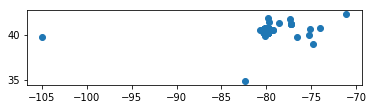

In [1466]:
todo_gj.plot()

In [1467]:
# Do spatial join to get census block for each address 
# Example from:
#    http://localhost:8820/notebooks/projects/demographics/Census-Planning-DB-2018.ipynb
# mob_blkgroups_gj = gpd.sjoin(blkgrps_cent_gj, mob_gj, how="inner", op='within')
todo_cb_gj = gpd.sjoin(todo_gj, ac_cb_gj, how="inner", op='within')

In [1468]:
todo_cb_gj=todo_cb_gj.reset_index()

In [1469]:
todo_cb_gj

,index,address_raw,geometry,index_right,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10
0,0,404 SHARON RD MOON TWP PA 15108,POINT (-80.21502939999999 40.5150446),14910,42,003,451102,3020,420034511023020,Block 3020,G5040,U,69697,U,S,137593.0,0.0,+40.5131869,-080.2142920
1,1,579 MOON CLINTON RD MOON TWP PA 15108,POINT (-80.25776689999999 40.5131247),23993,42,003,451105,3011,420034511053011,Block 3011,G5040,U,69697,U,S,1376.0,0.0,+40.5132088,-080.2576917
2,2,120 A THIRD ST N DUQUESNE PA 15110,POINT (-79.84976899999999 40.375295),11467,42,003,486700,2013,420034867002013,Block 2013,G5040,U,69697,U,S,9808.0,0.0,+40.3753517,-079.8498640
3,3,120 A 3RD ST N DUQUESNE PA 15110,POINT (-79.84976899999999 40.375295),11467,42,003,486700,2013,420034867002013,Block 2013,G5040,U,69697,U,S,9808.0,0.0,+40.3753517,-079.8498640
4,942,150 3RD ST N DUQUESNE PA 15110,POINT (-79.8504841 40.3759644),11467,42,003,486700,2013,420034867002013,Block 2013,G5040,U,69697,U,S,9808.0,0.0,+40.3753517,-079.8498640
5,4,3111 SQUIRES MANOR LN SOUTH PARK PA 15129,POINT (-79.9901045 40.2952708),29652,42,003,490003,1015,420034900031015,Block 1015,G5040,U,69697,U,S,698693.0,0.0,+40.3007178,-079.9906383
6,3224,3103 SQUIRES MANOR LN SOUTH PARK PA 15129,POINT (-79.99010439999999 40.2952667),29652,42,003,490003,1015,420034900031015,Block 1015,G5040,U,69697,U,S,698693.0,0.0,+40.3007178,-079.9906383
7,4332,3109 SQUIRES MANOR LN SOUTH PARK PA 15129,POINT (-79.9901045 40.2952698),29652,42,003,490003,1015,420034900031015,Block 1015,G5040,U,69697,U,S,698693.0,0.0,+40.3007178,-079.9906383
8,5,106 LINDEN AVE S PITTSBURGH PA 15208,POINT (-79.9108526 40.45257660000001),27244,42,003,140400,1000,420031404001000,Block 1000,G5040,U,69697,U,S,32531.0,0.0,+40.4525857,-079.9117879
9,2644,110 LINDEN AVE S PITTSBURGH PA 15208,POINT (-79.9108964 40.4524228),27244,42,003,140400,1000,420031404001000,Block 1000,G5040,U,69697,U,S,32531.0,0.0,+40.4525857,-079.9117879


In [1473]:
# Process all the newly processed census blocks into canonical_addr_map
process_addrs_to_cb_into_cam(todo_cb_gj)

1-1000: processing '233 POINTER DR JEFFERSON HILLS PA 15025', 0:00:00.110406 time elapsed
1001-2000: processing '138 PENNVIEW ST E PITTSBURGH PA 15223', 0:00:00.084975 time elapsed
2001-3000: processing '1839 MADISON DR MOON TWP PA 15108', 0:00:00.095347 time elapsed
3001-4000: processing '221 0 KEIFER DR PITTSBURGH PA 15241', 0:00:00.092052 time elapsed
4001-5000: processing '203 PINEWOOD SQ PITTSBURGH PA 15235', 0:00:00.089374 time elapsed
Processing took 0:00:00.485098 for 5122 addresses


In [229]:
list(todo_cb_gj.address_raw)

['205 BROOK ST MC DONALD PA 15057']

In [ ]:
failed_census_block_addrs = addrs_to_blocks_todo_set.copy()
# Remove all the elements that successfully generated census blocks
map(failed_census_block_addrs.remove, list(todo_cb_gj.address_raw))

In [1547]:
# Given an array of addresses to process, update any vids associated with them 
# in addrs_to_blocks_update_map into voter_map.  If execute is True, it actually 
# takes effect.  Otherwise, it just prints what it would do.
def process_todo_cb_results(addr_arr, execute):
    # Make a copy of addrs_to_blocks_todo_set to keep track of what addresses are left
    # after we process the ones that came back with valid census blocks
    global failed_census_block_addrs = addrs_to_blocks_todo_set.copy()

    # Hold onto the set of addresses in todo_cb_gj that successfully 
    # generated census blocks
    succeeded_addr_set = set(list(todo_cb_gj.address_raw))
    addr_set_to_process = succeeded_addr_set.intersection(set(addr_arr))
    print "Processing subset of cb_results: %d passed in, %d succesful, %d not"%(len(addr_arr),
                                                                                 len(addr_set_to_process),
                                                                                 len(addr_arr)-len(addr_set_to_process)
                                                                                )
    # Remove all the elements that successfully generated census blocks
    map(failed_census_block_addrs.remove, list(todo_cb_gj.address_raw))
    print "  Overall, %d queued to lookup, %d succesful, %d not"%(len(addrs_to_blocks_todo_set),
                                                                  len(addrs_to_blocks_todo_set)-len(failed_census_block_addrs),
                                                                  len(failed_census_block_addrs)
                                                                 )

    # Update the vids in addrs_to_blocks_update_map={}
    for addr in addr_set_to_process:
        census_block = None
        # Check if this is a failed address
        if addr in failed_census_block_addrs:
            # Record 'census_block'=None in canonical_addr_map if not already recorded
            if(not 'census_block' in canonical_addr_map[addr]):
                if(execute):
                    canonical_addr_map[addr]['census_block']=None
                else:
                    print "ADD canonical_addr_map[%r]['census_block']=None"%(addr)
        else:
            # Make sure addr is in canonical_addr_map
            if(not addr in canonical_addr_map or not 'census_block' in canonical_addr_map[addr]):
                print "ERROR: Trying to find census block for %s, but missing from canonical_addr_map" % (addr)
                continue
            # It is in canonical_addr_map, record the census block
            census_block = canonical_addr_map[addr]['census_block']

        # census_block should either be None or set to a valid value, record it in the relevant voter IDs.
        for vid in addrs_to_blocks_update_map[addr]:
            # Make sure vid is in voter_map
            if(not vid in voter_map):
                print "ERROR: Trying to update %s with census block %s, but missing from voter_map " % (vid, census_block)
                continue
            vrec = voter_map[vid]
            if(not 'addr_arr' in vrec):
                print "ERROR: Trying to update %s with census block %s, but 'addr_arr' missing from voter_map " % (vid, census_block)
                continue
            # Find the entry in addr_arr matching this address
            for i in range(0,len(voter_map[vid]['addr_arr'])):
                if(addr == voter_map[vid]['addr_arr'][i]['address']):
                    # Matches! Update census block
                    if('census_block' in voter_map[vid]['addr_arr'][i] and
                       voter_map[vid]['addr_arr'][i]['census_block']):
                        if voter_map[vid]['addr_arr'][i]['census_block']!=census_block:
                            print "ERROR: %r[%d]: stored census_block doesn't match computed: %r, %r"%(vid,i,
                                                                                                  voter_map[vid]['addr_arr'][i]['census_block'],
                                                                                                  census_block)
                            break
                    if(execute):
                        voter_map[vid]['addr_arr'][i]['census_block'] = census_block
                    else:
                        print "ADD voter_map[%r]['addr_arr'][%d]['census_block']=%r for %r"%(vid,i,
                                                                                             census_block,
                                                                                             addr)
    return addr_set_to_process         

In [1542]:
# Process all the successfully returned todo_cb_gj results
succ_set = process_todo_cb_results(list(todo_cb_gj.address_raw), True)

Processing subset of cb_results: 5122 passed in, 5122 succesful, 0 not
  Overall, 6757 queued to lookup, 5122 succesful, 1635 not


In [1546]:
len(succ_set)

5122

In [1536]:
# Test
succ_iter = iter(succ_set)

In [1537]:
test_addr = next(succ_iter)
test_addr

'4368 DUCKHORN DR MOON TWP PA 15108'

In [1539]:
# Find the next test_addr where stored census_block is non-null.  Run this with 
# result of running process_todo_cb_results(list(todo_cb_gj.address_raw), False)
# dry run.
found_nonnull_addr=False
while not found_nonnull_addr:
    try:
        test_addr= next(succ_iter)
    except:
        break
    print "%r"%(test_addr)
    for vid in addrs_to_blocks_update_map[test_addr]:
        find_t = find_matching_addr_rec(vid,test_addr)
        if(find_t):
            (j,addr_vec)=find_t
            print "  %s: %r[%d] = %r, census_block=%r"%(month_str,vid,j,addr,addr_vec['census_block'])
            if(addr_vec['census_block']):
                found_nonnull_addr=True
                break
if(found_nonnull_addr):
    test_addr
else:
    print "No non-null 

In [ ]:
# Dry run
succ_test_set = process_todo_cb_results([test_addr], False)

In [ ]:
# Execute
succ_test_set = process_todo_cb_results([test_addr], True)

In [ ]:
canonical_addr_map[test_addr]

In [ ]:
addrs_to_blocks_update_map[test_addr]

In [ ]:
voter_map['002113040-02']

In [ ]:
# Manual execution block for checking if any adresses in succ_set were missed.  Run this with 
# result of running process_todo_cb_results(list(todo_cb_gj.address_raw), True)
# execution run. NOTE: This is too slow to be practical!
proc_addr_set=succ_set
month_strs=['2005-02','2009-07','2013-02','2017-11','2018-03','2018-08','2018-10']
df = v18_1711_132_97_25_j
patt = test_addr
# Setup a map from [topic][month_str]->colname
colmap={}
for topic in ['address_raw']:
    colmap[topic]={}
    for month_str in month_strs:
        colmap[topic][month_str]="%s_%s"%(topic,month_str)

for patt in proc_addr_set:
    vid_match_set=set()
    for month_str in month_strs:
        colname = colmap['address_raw'][month_str]
        # Find vids and addresses matching patt
        match_vec = select_series_matching_pattern(df, colname, patt)

        for i in range(0,len(match_vec)):
            vid = match_vec.index[i]
            addr = match_vec[i]
            find_t = find_matching_addr_rec(vid,addr)
            if(find_t):
                (j,addr_vec)=find_t
                if(not addr_vec['census_block']):
                    print "%s: %r[%d] = %r, census_block=%r"%(month_str,vid,j,addr,addr_vec['census_block'])
            vid_match_set.add(vid)

    vid_match_set

In [72]:
failed_census_block_addrs

{'61 OLD JACKS RUN RD IRWIN PA 15642',
 '620 TULLAMORE TRAIL MARS PA 16046',
 '9441 NOBLESTOWN RD MC DONALD PA 15057'}

In [76]:
canonical_addr_map['620 TULLAMORE TRAIL MARS PA 16046']

{'canonical_in_census_db': True,
 'canonical_in_google_db': True,
 'census_block': None,
 'census_value': '{"result": {"addressMatches": [], "input": {"benchmark": {"benchmarkName": "Public_AR_Current", "id": "4", "isDefault": false, "benchmarkDescription": "Public Address Ranges - Current Benchmark"}, "address": {"address": "620 TULLAMORE TRAIL MARS PA 16046"}}}}',
 'google_value': '{"status": "OK", "results": [{"geometry": {"location_type": "APPROXIMATE", "bounds": {"northeast": {"lat": 40.702338, "lng": -80.00406799999999}, "southwest": {"lat": 40.6913781, "lng": -80.0243249}}, "viewport": {"northeast": {"lat": 40.702338, "lng": -80.00406799999999}, "southwest": {"lat": 40.6913781, "lng": -80.0243249}}, "location": {"lat": 40.6958996, "lng": -80.0117254}}, "formatted_address": "Mars, PA 16046, USA", "place_id": "ChIJ_VcUBgaGNIgRYWufKCeQGg0", "address_components": [{"long_name": "Mars", "types": ["locality", "political"], "short_name": "Mars"}, {"long_name": "Adams Township", "types"

In [79]:
coords = addr_to_coords('9441 NOBLESTOWN RD MC DONALD PA 15057')
print "%f %f" % (coords.y, coords.x)

40.366776 -80.284990


# Prune failed census block addrs

In [1560]:
len(failed_census_block_addrs)

1635

In [1653]:
# Find addresses in bad_addr_chk_set that actually have 'census_block' set in 
# canonical_addr_map or in their other_addr_strings family.  Return a pruned copy of the set passed in 
# that only contains addresses that really are missing 'census_block' in their entire other_addr_strings family.
# If copy_cb_to_others is true, it copies the 'census_block' to any in the family missing it.
def prune_failed_census_block_addrs(bad_addr_chk_set, copy_cb_to_others):
    start=arrow.now()
    chunk_start_time=start
    chunk_size=10000
    num_added = 0
    
    # actually_bad_set strts with the set passed in and gets pruned
    actually_bad_set = bad_addr_chk_set.copy()
    
    # already_checked_set contains addresses that have already been processed
    already_checked_set=set()
    
    i=0
    for chk_addr in bad_addr_chk_set:
        # Handle periodic debug message
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: processing %r, %d added, %s time elapsed" %(i-(chunk_size-1), i, chk_addr, num_added, arrow.now()-chunk_start_time)
            addcnt=0
            chunk_start_time=arrow.now()
        i=i+1
        
        if chk_addr in already_checked_set:
            continue
            
        already_checked_set.add(chk_addr)
        found_census_block=None
        found_cb_addr = None
        if(not chk_addr in canonical_addr_map):
            print "WARNING: %s not in canonical_addr_map" % (chk_addr)
            continue
        cam_rec = canonical_addr_map[chk_addr]
        if('census_block' in cam_rec and cam_rec['census_block']):
            print "REMOVING %r, 'census_block'=%r"% (chk_addr,cam_rec['census_block'])
            found_census_block=cam_rec['census_block']
            found_cb_addr=chk_addr
            actually_bad_set.remove(chk_addr)
            
        #print "a %r"%(chk_addr)
        
        # Check 'other_addr_strings' family if any
        if not 'other_addr_strings' in cam_rec or len(cam_rec['other_addr_strings'])==0:
            continue
            
        # keep track of other_addr_strings members that might need to be checked again if we find 'census_block'
        # in a later entry
        other_recheck_set=set()
        for other_addr in cam_rec['other_addr_strings']:
            #print "  b %r"%(other_addr)
   
            if(not other_addr in canonical_addr_map):
                continue
            o_rec = canonical_addr_map[other_addr]
            # add other_addr to already_checked_set
            already_checked_set.add(other_addr)

            if('census_block' in o_rec and o_rec['census_block']):
                # Got one.  Did we already have one? Do they match?
                #print "  c %r"%(o_rec['census_block'])
                if(found_census_block):
                    #print "  d %r"%(found_census_block)
                    if(found_census_block!=o_rec['census_block']):
                        print "ERROR: census_block differs for %r vs %r, %r!=%r"%(other_addr,
                                                                                  found_cb_addr,
                                                                                  o_rec['census_block'],
                                                                                  found_census_block)
                        raise
                    # We already have a census_block and it matches one we've seen already. 
                else:
                    #print "  e"
                    # This is the first family member with a census_block filled in.
                    # Record found_census_block and found_cb_addr
                    found_census_block=o_rec['census_block']
                    found_cb_addr=other_addr
                    
                # Remove other_addr from actually_bad_set (if there)
                if other_addr in actually_bad_set:
                    actually_bad_set.remove(other_addr)
            else:
                # 'census_block' is empty or missing for other_addr, add it to other_recheck_set 
                # in case we find found_census_block somewhere in the family
                other_recheck_set.add(other_addr)
                
        # We checked all the entries in other_addr_strings.  Do we have a found_census_block?
        if(found_census_block):
            # Yes!  Did we have it to start with?
            if('census_block' in cam_rec and cam_rec['census_block']):
                # Yes, already had it for chk_addr
                pass
            else:
                # No, record it
                if(copy_cb_to_others):
                    cam_rec['census_block']=found_census_block
                print "ADDING canonical_addr_map[%r]['census_block']=%r"% (chk_addr,found_census_block)
                print "REMOVING %r, 'census_block'=%r"% (chk_addr,found_census_block)
                actually_bad_set.remove(chk_addr)
                num_added = num_added+1
                
            # If there were any others in the family that were missing census_block, 
            # process them now
            for other_addr in other_recheck_set:
                # Remove other_addr from actually_bad_set (if there) and add to already_checked_set
                if other_addr in actually_bad_set:
                    print "  REMOVING %r, 'census_block'=%r"% (other_addr,found_census_block)
                    actually_bad_set.remove(other_addr)
                if(copy_cb_to_others):
                    canonical_addr_map[other_addr]['census_block']=found_census_block
                print "  ADDING canonical_addr_map[%r]['census_block']=%r"% (other_addr,found_census_block)
                num_added = num_added+1
        

    end=arrow.now()
    print "Processing took %s for %d addrs, %d were ok, %d census_block entries added" % (str(end-start), len(bad_addr_chk_set), 
                                                                                          len(bad_addr_chk_set)-len(actually_bad_set),
                                                                                          num_added)

    return actually_bad_set

In [1658]:
# Real run
failed_census_block_addrs =prune_failed_census_block_addrs(failed_census_block_addrs,True)

Processing took 0:00:00.007334 for 1599 addrs, 0 were ok, 0 census_block entries added


In [1657]:
test_addr='128 EUGENE AVE W HOMESTEAD PA 15120'

In [1564]:
# Test
fail_iter = iter(failed_census_block_addrs)

In [1644]:
test_addr = next(fail_iter)
test_addr

StopIteration: 

In [1642]:
for test_addr in fail_iter:
    if('other_addr_strings' in canonical_addr_map[test_addr] and 
       len(canonical_addr_map[test_addr]['other_addr_strings'])>0):
        for other_addr in canonical_addr_map[test_addr]['other_addr_strings']:
            if(other_addr in canonical_addr_map and 
               'census_block' in canonical_addr_map[other_addr] and 
               canonical_addr_map[other_addr]['census_block']):
                break
        
print test_addr


435 NARROWS RUN RD-RBT MORRIS CORAOPOLIS PA 15108


In [1620]:
# Dry run
prune_failed_census_block_addrs(set([test_addr]),False)

a '101 HILL ST MCDONALD PA 15057'
  b u'101 HILL ST MCDONALD       PA 15057'
  b '101 HILL ST MC DONALD PA 15057'
Processing took 0:00:00.000985 for 1 addresses, 0 census_block entries added


{'101 HILL ST MCDONALD PA 15057'}

In [1601]:
# Execute
prune_failed_census_block_addrs(set([test_addr]),True)

a '1717 STEVENSAN DR SEWICKLEY PA 15143'
Processing took 0:00:00.000608 for 1 addresses, 0 census_block entries added


{'1717 STEVENSAN DR SEWICKLEY PA 15143'}

In [1643]:
'other_addr_strings' in canonical_addr_map[test_addr]

False

In [1650]:
canonical_addr_map[test_addr]

{'canonical_in_census_db': True,
 'canonical_in_google_db': True,
 'census_block': None,
 'census_value': '{"result": {"addressMatches": [{"tigerLine": {"tigerLineId": "51681853", "side": "R"}, "coordinates": {"y": 40.38683, "x": -79.903564}, "matchedAddress": "128 W EUGENE AVE, W HOMESTEAD, PA, 15120", "addressComponents": {"suffixType": "AVE", "zip": "15120", "toAddress": "198", "preQualifier": "", "preDirection": "W", "city": "W HOMESTEAD", "preType": "", "state": "PA", "suffixQualifier": "", "fromAddress": "100", "streetName": "EUGENE", "suffixDirection": ""}}, {"tigerLine": {"tigerLineId": "51681853", "side": "R"}, "coordinates": {"y": 40.38683, "x": -79.903564}, "matchedAddress": "128 W EUGENE AVE, WEST HOMESTEAD, PA, 15120", "addressComponents": {"suffixType": "AVE", "zip": "15120", "toAddress": "198", "preQualifier": "", "preDirection": "W", "city": "WEST HOMESTEAD", "preType": "", "state": "PA", "suffixQualifier": "", "fromAddress": "100", "streetName": "EUGENE", "suffixDirect

In [1651]:
canonical_addr_map['128 EUGENE AVE W MUNHALL PA 15120']

{'canonical_in_census_db': True,
 'canonical_in_google_db': True,
 'census_block': u'420034845003022',
 'census_value': u'{"result": {"addressMatches": [{"tigerLine": {"tigerLineId": "51681853", "side": "R"}, "coordinates": {"y": 40.38683, "x": -79.903564}, "matchedAddress": "128 W EUGENE AVE, MUNHALL, PA, 15120", "addressComponents": {"suffixType": "AVE", "zip": "15120", "toAddress": "198", "preQualifier": "", "preDirection": "W", "city": "MUNHALL", "preType": "", "state": "PA", "suffixQualifier": "", "fromAddress": "100", "streetName": "EUGENE", "suffixDirection": ""}}, {"tigerLine": {"tigerLineId": "51681864", "side": "R"}, "coordinates": {"y": 40.386124, "x": -79.9011}, "matchedAddress": "128 E EUGENE AVE, MUNHALL, PA, 15120", "addressComponents": {"suffixType": "AVE", "zip": "15120", "toAddress": "130", "preQualifier": "", "preDirection": "E", "city": "MUNHALL", "preType": "", "state": "PA", "suffixQualifier": "", "fromAddress": "100", "streetName": "EUGENE", "suffixDirection": ""

In [1567]:
addrs_to_blocks_update_map[test_addr]

{'002216062-02'}

In [1568]:
voter_map['002216062-02']

{'DOB': '4/21/1957',
 'addr_arr': [{'address': '5535 COVODE ST PITTSBURGH PA 15217',
   'census_block': u'420031413002004',
   'date': datetime.datetime(1992, 10, 1, 0, 0),
   'latlon': <shapely.geometry.point.Point at 0x7f4df5f8a850>},
  {'address': '7816 LLOYD AVE PITTSBURGH PA 15218',
   'census_block': u'420035152001014',
   'date': Timestamp('2009-05-06 00:00:00'),
   'latlon': <shapely.geometry.point.Point at 0x7f4df5f8a550>},
  {'address': '7816 1/2 LLOYD AVE SWISSVALE PA 15218',
   'census_block': None,
   'date': Timestamp('2009-05-06 16:10:12')}],
 'addresses': {'2005-02': '5535 COVODE ST PITTSBURGH PA 15217',
  '2009-07': '7816 LLOYD AVE PITTSBURGH PA 15218',
  '2013-02': '7816 1/2 LLOYD AVE SWISSVALE PA 15218',
  '2017-11': '7816 1/2 LLOYD AVE SWISSVALE PA 15218',
  '2018-03': '7816 1/2 LLOYD AVE SWISSVALE PA 15218',
  '2018-08': '7816 1/2 LLOYD AVE SWISSVALE PA 15218',
  '2018-10': '7816 1/2 LLOYD AVE SWISSVALE PA 15218'},
 'last_update_date': {'2005-02': Timestamp('1997-0

# Update uncomputable/failed addrs and reset TODOs

In [ ]:
# Filter addrs that are actually ok now from uncomputable_census_block_addrs_set
uncomputable_census_block_addrs_set=prune_failed_census_block_addrs(uncomputable_census_block_addrs_set,True)

In [1668]:
# Add failed_census_block_addrs to uncomputable_census_block_addrs_set
uncomputable_census_block_addrs_set = uncomputable_census_block_addrs_set.union(failed_census_block_addrs)
print "Added %d addrs to uncomputable_census_block_addrs_set, size now %d" % (len(failed_census_block_addrs), len(uncomputable_census_block_addrs_set))

Added 1599 addrs to uncomputable_census_block_addrs_set, size now 1616


In [1699]:
# Reset TODO related variables to be empty
addrs_to_blocks_todo_set=set()
addrs_to_blocks=[]
coords_to_blocks=[]
addrs_to_blocks_update_map={}


In [196]:
# From ~/education/earthtime/voting/update_vids_in_addrs_to_blocks_update_map_out.txt
# These appear to be addresses that did not match to any of the census blocks
reprocess_addrs = ['14 BEECH ST AMBRIDGE PA 15003',
'245 ERMA ST RD1 MONONGAHELA PA 15063',
'915 INDIANA AVE GLASSPORT PA 15045',
'234 CENTER AVE CECIL PA 15321',
'896 CLINTON FRANKFORT RD BOX CLINTON PA 15026',
'1036 OLD ORCHARD CT GIBSONIA PA 15044',
'1268 US ROUTE 30 CLINTON PA 15026',
'124 FINLEYVILLE R D 4 BOX FINLEYVILLE PA 15332',
'501 EASTVIEW DR IRWIN PA 15642',
'491 EASTVIEW DR IRWIN PA 15642',
'320 MILLERS-HILL RD RD2 BOX NEW KENSINGTON PA 15068',
'78 BEECH ST AMBRIDGE PA 15003',
'131 MAIN ST PO BOX RUSSELLTON PA 15076',
'277 STATE RTE 30 CLINTON PA 15026',
'1171 CAMBIER DR CRESCENT PA 15046',
'187 AIRPORT RD BELLE VERNON PA 15012',
'170 OLD JACKS RUN RD IRWIN PA 15642',
'106 DAVIS LN SEWICKLEY PA 15143',
'LOGANS FERRY RD NEW KENSINGTON PA 15068',
'405 PATRICKS PL MARS PA 16046',
'100 RIDGE RD RD1 MARS PA 16046',
'14 BEAVER ST AMBRIDGE PA 15003',
'2734 MILFORD DR BETHEL PARK PA 15102',
'961 CLINTON FRANKFORT RD BOX CLINTON PA 15026',
'205 BROOK ST MC DONALD PA 15057',
'101 PLEASANT RISE DR MCDONALD PA 15057',
'6 BEECH ST AMBRIDGE PA 15003',
'110 HIMALAYA RD MONROEVILLE PA 15146',
'337 COAL ST MCDONALD PA 15057',
'513 TUSCARORA RD MARS PA 16046',
'302 STATE RTE 8 BOX BAKERSTOWN PA 15007',
'162 RICHLAND MOBILE HOME PARK GIBSONIA PA 15044',
'FOX HILL BLACKBURN RD SEWICKLEY PA 15143',
'648 MILLERS RUN RD CECIL PA 15321',
'257 COLLINS AVE P O BOX CLAIRTON PA 15025',
'533 5TH ST TRAFFORD PA 15085',
'139 CHRISTY RD BOX TARENTUM PA 15084',
'STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'1963 LINCOLN HWY NORTH VERSAILLES PA 15137',
'2100 SHORT ST FINLEYVILLE PA 15332',
'147 STATE RTE 30 CLINTON PA 15026',
'206 STATE RTE 51 RD4 BOX ELIZABETH PA 15037',
'500 BEAGLE CLUB RD MCDONALD PA 15057',
'1252 STATE RTE 30 CLINTON PA 15026',
'126 WOODLAWN AVE CECIL PA 15321',
'81 RIDGE RD MONONGAHELA PA 15063',
'224 RIDGE RD RD1 MARS PA 16046',
'22 FORBES RD TRAFFORD PA 15085',
'105 GRANT ST MCDONALD PA 15057',
'51 CHARLES ST CECIL PA 15321',
'4117 WINTERBURN AVE PITTSBURGH PA 15207',
'476 BEAGLE CLUB RD MC DONALD PA 15057',
'3780 FAIRVIEW DR MURRYSVILLE PA 15668',
'128 WOODLAWN AVE CECIL PA 15321',
'4 KRISTOFF LN MCDONALD PA 15057',
'145 RIDGE RD MONONGAHELA PA 15063',
'1385 STATE RTE 30 CLINTON PA 15026',
'979 CLINTON FRANKFORT RD BOX CLINTON PA 15026',
'1248 US ROUTE 30 CLINTON PA 15026',
'4305 WINTERBURN AVE PITTSBURGH PA 15207',
'5066 IMPALA DR PITTSBURGH PA 15239',
'172 CANNON HILL RD SAXONBURG PA 16056',
'1285 STATE RTE 30 CLINTON PA 15026',
'404 PATRICKS PL MARS PA 16046',
'119 RIDGE RD MONONGAHELA PA 15063',
'8 BEECH ST AMBRIDGE PA 15003',
'3401 LOGANS FERRY RD MURRYSVILLE PA 15668',
'590 OLD JACKS RUN RD IRWIN PA 15642',
'1971 GREENSBURG RD NEW KENSINGTON PA 15068',
'678 PRINCETON BLVD PITTSBURGH PA 15221',
'1297 STATE RTE 30 CLINTON PA 15026',
'1281 STATE RTE 30 CLINTON PA 15026',
'4 BEECH ST AMBRIDGE PA 15003',
'114 RIDGE RD MONONGAHELA PA 15063',
'1282 STATE RTE 30 CLINTON PA 15026',
'131 RIDGE RD MONONGAHELA PA 15063',
'1368 STATE RTE 30 CLINTON PA 15026',
'2 CENTER AVE RD1 BOX MONONGAHELA PA 15063',
'138 HIGH ST MC DONALD PA 15057',
'1035 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'123 RIDGE RD MONONGAHELA PA 15063',
'218 MONONGAHELA R D MONONGAHELA PA 15063',
'2900 COULTERVILLE RD MCKEESPORT PA 15131',
'476 BEAGLE CLUB RD MCDONALD PA 15057',
'181 ROBINSON RUN RD RD6 MCDONALD PA 15057',
'242 BLYTHE RD BOX MCDONALD PA 15057',
'185 GAYDOS LN SEWICKLEY PA 15143',
'490 OLD JACKS RUN RD IRWIN PA 15642',
'864 HILL ST NEW KENSINGTON PA 15068',
'54 CHARLES ST CECIL PA 15321',
'106 HIMALAYA RD MONROEVILLE PA 15146',
'230 CENTER AVE CECIL PA 15321',
'MANOWN RD PO BOX MONONGAHELA PA 15063',
'2104 SHORT ST FINLEYVILLE PA 15332',
'527 5TH ST TRAFFORD PA 15085',
'1039 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'44 ROBINSON RUN RD MC DONALD PA 15057',
'347 CENTER AVE MCDONALD PA 15057',
'116 RIDGE RD MONONGAHELA PA 15063',
'715 SCHOOL ST MC KEES ROCKS PA 15136',
'188 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'201 WARRENDALE RD MARS PA 16046',
'339 COAL ST MCDONALD PA 15057',
'1005 CONOVER DR NEW KENSINGTON PA 15068',
'225 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'215 KIRKWOOD DR PITTSBURGH PA 15215',
'142 CHRISTY RD TARENTUM PA 15084',
'236 CENTER AVE CECIL PA 15321',
'135 RIDGE RD MONONGAHELA PA 15063',
'164 CANNON HILL RD SAXONBURG PA 16056',
'10 NOBLESTOWN RD OAKDALE PA 15071',
'1360 US ROUTE 30 CLINTON PA 15026',
'337 CENTER AVE MC DONALD PA 15057',
'116 GRANT ST MC DONALD PA 15057',
'134 CHRISTY RD BOX TARENTUM PA 15084',
'113 RIDGE RD MONONGAHELA PA 15063',
'122 WOODLAWN AVE CECIL PA 15321',
'1285 US ROUTE 30 CLINTON PA 15026',
'1927 DIXIE LN MONONGAHELA PA 15063',
'118 RIDGE RD MONONGAHELA PA 15063',
'2 KRISTOFF LN MC DONALD PA 15057',
'491 OLD JACKS RUN RD IRWIN PA 15642',
'110 GRANT ST MCDONALD PA 15057',
'4218 LOGANS FERRY RD MURRYSVILLE PA 15668',
'145 STATE RTE 8 BOX VALENCIA PA 16059',
'343 COAL ST MCDONALD PA 15057',
'65 RIDGE RD MONONGAHELA PA 15063',
'118 WOODLAWN AVE CECIL PA 15321',
'WARRENDALE AMBRIDGE RD BADEN PA 15005',
'102 MONTROSE AVE FREEPORT PA 16229',
'116 HIMALAYA RD MONROEVILLE PA 15146',
'330 DEER CREEK RD GIBSONIA PA 15044',
'814 WETTACH ST PITTSBURGH PA 15212',
'120 WOODLAWN AVE CECIL PA 15321',
'325 COAL ST MCDONALD PA 15057',
'500 BEAGLE CLUB RD MC DONALD PA 15057',
'115 GRANT ST MCDONALD PA 15057',
'178 AIRPORT RD BELLE VERNON PA 15012',
'219 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'1132 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'67 ROBINSON RUN RD MC DONALD PA 15057',
'109 RIDGE RD MONONGAHELA PA 15063',
'144 CENTER AVE CECIL PA 15321',
'238 STATE RTE 51 FINLEYVILLE PA 15332',
'95 GLASGOW RD RD1 BOX VALENCIA PA 16059',
'1787 SILLVIEW DR PITTSBURGH PA 15243',
'1272 US ROUTE 30 CLINTON PA 15026',
'208 TECH RD PITTSBURGH PA 15205',
'327 COAL ST MC DONALD PA 15057',
'226 CENTER AVE CECIL PA 15321',
'1109 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'2821 BEECHWOOD BLVD PITTSBURGH PA 15217',
'WALKER RD RD MCDONALD PA 15057',
'60 CHARLES ST CECIL PA 15321',
'150 WILDFLOWER LN MARS PA 16046',
'36 BLYTHEDALE (BAD ADD) BLYTHDALE PA 15013',
'1370 STEWART RD MC DONALD PA 15057',
'184 ALDER ST RD3 BOX TARENTUM PA 15084',
'1270 STATE RTE 30 CLINTON PA 15026',
'404 MARBLE DR CRESCENT PA 15046',
'450 OLD JACKS RUN RD IRWIN PA 15642',
'71 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'236 STATE RTE 51 FINLEYVILLE PA 15332',
'196 WILMOT ST DUQUESNE PA 15110',
'126 RIDGE RD MONONGAHELA PA 15063',
'1081 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'298 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'16 BEAVER ST AMBRIDGE PA 15003',
'100 RIDGE RD MONONGAHELA PA 15063',
'1929 DIXIE LN MONONGAHELA PA 15063',
'1360 STEWART RD MCDONALD PA 15057',
'2020 SNOWDEN RD FINLEYVILLE PA 15332',
'BLYTHEDALE (BAD ADD) BLYTHDALE PA 15013',
'245 KRAMER RD SOUTH PARK PA 15129',
'335 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'3629 LOGANS FERRY RD MURRYSVILLE PA 15668',
'52 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'245 SPRING ST MCDONALD PA 15057',
'538 BEAGLE CLUB RD MC DONALD PA 15057',
'1469 STATE RTE 30 CLINTON PA 15026',
'BROADHEAD TR CT LOT CORAOPOLIS PA 15108',
'PARK RD CECIL PA 15321',
'400 OLD JACKS RUN RD IRWIN PA 15642',
'1282 US ROUTE 30 CLINTON PA 15026',
'1926 DIXIE LN MONONGAHELA PA 15063',
'1963 BLYTHEDALE RD BUENA VISTA PA 15018',
'27 MAIN ST MCDONALD PA 15057',
'538 BEAGLE CLUB RD MCDONALD PA 15057',
'351 STATE RTE 30 CLINTON PA 15026',
'43 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'403 PATRICKS PL MARS PA 16046',
'104 RIDGE RD MONONGAHELA PA 15063',
'204 CRESCENT GARDEN DR PITTSBURGH PA 15235',
'228 CENTER AVE CECIL PA 15321',
'67 STATE RTE 8 BOX VALENCIA PA 16059',
'2020 HOOKSTOWN GRADE RD CLINTON PA 15026',
'203 WARRENDALE RD MARS PA 16046',
'60 DODDS AVE VALENCIA PA 16059',
'4 KRISTOFF LN MC DONALD PA 15057',
'1557 STATE RTE 30 CLINTON PA 15026',
'421 OLD JACKS RUN RD IRWIN PA 15642',
'139 STATE RTE 906 RD ELIZABETH PA 15037',
'543 5TH ST TRAFFORD PA 15085',
'345 SUNSET DR BADEN PA 15005',
'7536 MELROSE ST PITTSBURGH PA 15218',
'114 HIMALAYA RD MONROEVILLE PA 15146',
'2955 COULTERVILLE RD MCKEESPORT PA 15131',
'24 BEECH ST AMBRIDGE PA 15003',
'1270 US ROUTE 30 CLINTON PA 15026',
'1281 US ROUTE 30 CLINTON PA 15026',
'500 CENTER AVE CECIL PA 15321',
'234 RIDGE RD RD1 MARS PA 16046',
'1360 STATE RTE 30 CLINTON PA 15026',
'1223 COLLINS AVE JEFFERSON HILLS PA 15025',
'204 WARRENDALE RD MARS PA 16046',
'451 OLD JACKS RUN RD IRWIN PA 15642',
'323 COAL ST MCDONALD PA 15057',
'51 DEER CREEK RD GIBSONIA PA 15044',
'551 5TH ST TRAFFORD PA 15085',
'392 MILLERS RUN RD MORGAN PA 15064',
'508 TUSCARORA RD MARS PA 16046',
'130 RIDGE RD MONONGAHELA PA 15063',
'53 RIDGE RD MONONGAHELA PA 15063',
'57 RIDGE RD VALENCIA PA 16059',
'112 HIMALAYA RD MONROEVILLE PA 15146',
'289 CHARLES ST CECIL PA 15321',
'330 CENTER AVE MCDONALD PA 15057',
'101 PLEASANT RISE DR MC DONALD PA 15057',
'1403 STATE RTE 30 CLINTON PA 15026',
'78 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'97 BOCKTOWN RD RD1 BOX CLINTON PA 15026',
'369 OLD JACKS RUN RD IRWIN PA 15642',
'67 ROBINSON RUN RD MCDONALD PA 15057',
'1213 COLLINS AVE JEFFERSON HILLS PA 15025',
'8 CLINTON BOCKTOWN RD CLINTON PA 15026',
'1477 STATE RTE 30 CLINTON PA 15026',
'481 EASTVIEW DR IRWIN PA 15642',
'101 HILL ST MC DONALD PA 15057',
'200 WARRENDALE RD MARS PA 16046',
'1283 STATE RTE 30 CLINTON PA 15026',
'440 OLD JACKS RUN RD IRWIN PA 15642',
'202 WARRENDALE RD MARS PA 16046',
'2 KRISTOFF LN MCDONALD PA 15057',
'101 HILL ST MCDONALD PA 15057',
'212 CRAWFORD CT MARS PA 16046',
'508 SCENIC RIDGE DR FINLEYVILLE PA 15332',
'715 SCHOOL ST MCKEES ROCKS PA 15136',
'330 CENTER AVE MC DONALD PA 15057',
'10 RIDGE RD RD1 MARS PA 16046',
'123 STATE RTE 30 CLINTON PA 15026',
'44 ROBINSON RUN RD MCDONALD PA 15057',
'2 BEECH ST AMBRIDGE PA 15003',
'114 GRANT ST MCDONALD PA 15057',
'337 CENTER AVE MCDONALD PA 15057',
'232 CENTER AVE CECIL PA 15321',
'1136 US ROUTE 30 CLINTON PA 15026',
'402 SOUTHPOINT CT MCDONALD PA 15057',
'7 2ND ST PITTSBURGH PA 15215',
'535 5TH ST TRAFFORD PA 15085',
'1268 STATE RTE 30 CLINTON PA 15026',
'240 BLYTHE RD BOX MCDONALD PA 15057',
'499 CENTER AVE CECIL PA 15321',
'10 BEECH ST AMBRIDGE PA 15003',
'273 BOCKTOWN RD PO BOX CRESCENT PA 15046',
'215 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'201 MURRYSVILLE RD NEW KENSINGTON PA 15068',
'CHRISTY COR NEW KENSINGTON PA 15068',
'101 RIDGE RD MONONGAHELA PA 15063',
'1280 US ROUTE 30 CLINTON PA 15026']


In [200]:
reprocess_vids = set()

In [208]:
for this_addr in reprocess_addrs:
    map(reprocess_vids.add,addrs_to_blocks_update_map[this_addr])

In [210]:
len(reprocess_vids)

474

In [212]:
voter_process_address_history_array(list(reprocess_vids),True)

Processing took 0:00:00.038317 for 474 addresses


# Test voter_process_address_history_array components

In [86]:
voter_map[voter_map.keys()[0]]={'DOB': '1/8/1944',
 'addresses': {'2009-07': '415 CHESTNUT ST SPRINGDALE PA 15144',
  '2017-11': '415 CHESTNUT ST SPRINGDALE PA 15144',
  '2018-03': '415 CHESTNUT ST SPRINGDALE PA 15144',
  '2018-08': '415 CHESTNUT ST SPRINGDALE PA 15144'},
 'reg_date': datetime.datetime(1993, 4, 1, 0, 0),
 'reg_info': {'2009-07': {'party': 'D', 'status': 'A'},
  '2017-11': {'party': 'D', 'status': 'A'},
  '2018-03': {'party': 'D', 'status': 'A'},
  '2018-08': {'party': 'D', 'status': 'A'}}}

In [119]:
voter_map[voter_map.keys()[3]]={'DOB': '8/29/1972',
 'addresses': {'2009-07': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
  '2017-11': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-03': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-08': '509 OCTOBER CT PLUM PA 15239'},
 'reg_date': datetime.datetime(1990, 10, 1, 0, 0),
 'reg_info': {'2009-07': {'party': 'R', 'status': 'A'},
  '2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [120]:
i=3
voter_map[voter_map.keys()[i]]

{'DOB': '8/29/1972',
 'addresses': {'2009-07': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
  '2017-11': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-03': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-08': '509 OCTOBER CT PLUM PA 15239'},
 'reg_date': datetime.datetime(1990, 10, 1, 0, 0),
 'reg_info': {'2009-07': {'party': 'R', 'status': 'A'},
  '2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [127]:
voter_process_address_history(voter_map.keys()[i], True)

[{'address': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
  'census_block': u'420035263012005',
  'date': datetime.datetime(1990, 10, 1, 0, 0)},
 {'address': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  'date': datetime.datetime(2017, 11, 30, 0, 0)},
 {'address': '509 OCTOBER CT PLUM PA 15239',
  'census_block': None,
  'date': datetime.datetime(2018, 8, 14, 0, 0)}]

In [153]:
voter_map[voter_map.keys()[3]]

{'DOB': '8/29/1972',
 'addr_arr': [{'address': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
   'census_block': u'420035263012005',
   'date': datetime.datetime(1990, 10, 1, 0, 0)},
  {'address': '3014 SETTLERS CT MURRYSVILLE PA 15668',
   'census_block': u'420035263011014',
   'date': datetime.datetime(2017, 11, 30, 0, 0)},
  {'address': '509 OCTOBER CT PLUM PA 15239',
   'census_block': None,
   'date': datetime.datetime(2018, 8, 14, 0, 0)}],
 'addresses': {'2009-07': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
  '2017-11': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-03': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-08': '509 OCTOBER CT PLUM PA 15239'},
 'reg_date': datetime.datetime(1990, 10, 1, 0, 0),
 'reg_info': {'2009-07': {'party': 'R', 'status': 'A'},
  '2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [129]:
addrs_to_blocks_todo_set

{'3014 SETTLERS CT MURRYSVILLE PA 15668'}

In [130]:
addrs_to_blocks

['3014 SETTLERS CT MURRYSVILLE PA 15668']

In [131]:
coords_to_blocks

In [132]:
addrs_to_blocks_update_map

{'3014 SETTLERS CT MURRYSVILLE PA 15668': {'002323758-02'}}

# Compute vote moved since last vote

In [1704]:
# Keep track of which current voters are still voted_since_move==False
# with their most current address and still registered
# Returns true or false
def voter_moved_since_last_vote(vid):
    if (not vid in voter_map or not 'addr_arr' in voter_map[vid] or not 'vote_info' in voter_map[vid]):
        return (unknown_color, max_datetime)
    
    vrec = voter_map[vid]
     
    if(len(vrec['addr_arr'])<1):
        return(False)
    
    # Check if they moved away
    moved_ms = check_voter_moved_away(vid)
    if(moved_ms):
        #print"%s: False, moved away"%(vid)
        return(False)
    
    latest_addr_rec = vrec['addr_arr'][-1]

    # Get the start time for this address.
    addr_start_date = latest_addr_rec['date']

    # Get the next vote after addr_start_date
    next_vote_rec=get_next_vote_str_rec_after_date(vrec['vote_info'], addr_start_date)
    if(next_vote_rec):
        #print"%s: False, voted %s > %s"%(vid, next_vote_rec[1]['date'], addr_start_date)
        return(False)
    
    # No vote record more recent than the first known instance of the current addres.
    #print"%s: True, no vote after %s"%(vid, addr_start_date)
    return(True)

In [1705]:
for vid in list(vdf_2018_10[0:10].index):
        mslv = voter_moved_since_last_vote(vid)
        if(mslv):
            print "%s" % (vid)

108927574-02


In [1706]:
voter_map['108927574-02']

{'DOB': '2/16/1999',
 'addr_arr': [{'address': '938 BELL DR WEXFORD PA 15090',
   'census_block': u'420034110003022',
   'date': datetime.datetime(2018, 1, 26, 0, 0),
   'latlon': <shapely.geometry.point.Point at 0x7f46d758a7d0>},
  {'address': '155 SENECA PL MARS PA 16046',
   'census_block': u'420034110001038',
   'date': Timestamp('2018-07-10 09:14:41'),
   'latlon': <shapely.geometry.point.Point at 0x7f46d758aa50>}],
 'addresses': {'2018-03': '938 BELL DR WEXFORD PA 15090',
  '2018-08': '155 SENECA PL MARS PA 16046',
  '2018-10': '155 SENECA PL MARS PA 16046'},
 'last_update_date': {'2018-03': Timestamp('2018-01-26 00:00:00'),
  '2018-08': Timestamp('2018-07-10 09:14:41'),
  '2018-10': Timestamp('2018-07-10 09:14:41')},
 'reg_date': datetime.datetime(2018, 1, 26, 0, 0),
 'reg_info': {'2018-03': {'party': 'D', 'status': 'A'},
  '2018-08': {'party': 'D', 'status': 'A'},
  '2018-10': {'party': 'D', 'status': 'A'}},
 'vote_info': {}}

In [1707]:
vt = vdf_2018_10[0:10].copy()

In [1708]:
vt['moved_since_voted'] = vt.index.map(voter_moved_since_last_vote)

In [1710]:
vt[vt['moved_since_voted']]

,Title,Last_Name,First_Name,Middle_Name,Suffix,Sex,Date_Of_Birth,Date_Registered,Voter_Status,StatusChangeDate,Political_Party,House__,HouseNoSuffix,StreetNameComplete,Apt__,Address_Line_2,City,State,Zip_Code,MAddress_Line_1,MAddress_Line_2,MCity,MState,MZip_Code,PollingPlaceDescript,PollPlaceAdd,PollPlaceCSZ,Last_Date_Voted,Dist1,Dist2,Dist3,Dist4,Dist5,Dist6,Dist7,Dist8,Dist9,Dist10,Dist11,Dist12,Dist13,Dist14,Dist15,CustomData1,Date_Last_Changed,PhoneNumHome,PR_05_15_18,PR_05_15_18_VM,SP_03_13_18,SP_03_13_18_VM,SP_03_06_18,SP_03_06_18_VM,SP_01_23_18,SP_01_23_18_VM,GN_11_07_17,GN_11_07_17_VM,PR_05_16_17,PR_05_16_17_VM,GN_11_08_16,GN_11_08_16_VM,PR_04_26_16,PR_04_26_16_VM,GN_11_03_15,GN_11_03_15_VM,PR_05_19_15,PR_05_19_15_VM,GN_11_04_14,GN_11_04_14_VM,PR_05_20_14,PR_05_20_14_VM,GN_11_05_13,GN_11_05_13_VM,PR_05_21_13,PR_05_21_13_VM,GN_11_06_12,GN_11_06_12_VM,SP_08_07_12,SP_08_07_12_VM,PR_04_24_12,PR_04_24_12_VM,GN_11_08_11,GN_11_08_11_VM,PR_05_17_11,PR_05_17_11_VM,GN_11_02_10,GN_11_02_10_VM,address_raw,moved_since_voted,DR,DOB,DLC,suspect_dates,SCD
ID_Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
108927574-02,NaN,AABAN,ZAIN,A,NaN,M,2/16/1999,1/26/2018,A,1/26/2018 3:0:3,D,155,,SENECA PL,NaN,NaN,MARS,PA,16046,NaN,NaN,NaN,NaN,NaN,REGIONAL LEARNING ALLIANCE,850 CRANBERRY WOODS RD,"WARRENDALE, PA 16066",NaN,1650005,NaN,SC50,MN165,MD212,LG28,SN38,CD17,CPC00,CAC02,2.0,NaN,1650005-1,NaN,NaN,NaN,7/10/2018 9:14:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155 SENECA PL MARS PA 16046,True,2018-01-26,1999-02-16,2018-07-10 09:14:41,False,2018-01-26 03:00:03


In [1711]:
vdf_2018_10['moved_since_voted_orig']=vdf_2018_10['moved_since_voted']

In [1712]:
vdf_2018_10['moved_since_voted'] = vdf_2018_10.index.map(voter_moved_since_last_vote)

In [1713]:
vdf_2018_10_nrm=vdf_2018_10[(~vdf_2018_10['moved_since_voted'])&(vdf_2018_10['moved_since_voted_orig'])]
len(vdf_2018_10_nrm)
                                                                 

93619

In [1714]:
vdf_2018_10_msv = vdf_2018_10[vdf_2018_10['moved_since_voted']].copy()
len(vdf_2018_10_msv)

236028

In [1716]:
# Only include democrats
vdf_2018_10_msv_d = vdf_2018_10[vdf_2018_10['moved_since_voted']&(vdf_2018_10['Political_Party']=='D')].copy()
len(vdf_2018_10_msv_d)

131327

#### Get Polling Place info

In [424]:
pp_info={}

In [434]:
for i in range(0,len(pp_2018_11)):
    mwd = str(pp_2018_11['MWD2'].iloc[i])
    pp_info[mwd]={'muni_name':pp_2018_11['MuniName'].iloc[i],
                  'ward':pp_2018_11['Ward'].iloc[i],
                  'district':pp_2018_11['District'].iloc[i],
                  'loc_name':pp_2018_11['LocName'].iloc[i],
                  'address':'%s %s, PA %s'%(pp_2018_11['NewAddress'].iloc[i],
                                            pp_2018_11['City'].iloc[i],
                                            pp_2018_11['Zip'].iloc[i])
                 }
    

In [435]:
pp_info['1850905']

{'address': u'8351 PIERCE ST VERONA, PA 15147',
 'district': 5,
 'loc_name': u'HILLTOP COMM ALLIANCE CH.',
 'muni_name': u'PENN HILLS',
 'ward': 9}

In [436]:
# Manually add missing values
pp_info['1370700']={'muni_name':'ELIZABETH TP',
                  'ward':7,
                  'district':0,
                  'loc_name':'BLAINE HILL VOL FIRE CO',
                  'address':'409 OXFORD AVE ELIZABETH, PA 15037'}

In [437]:
pp_info['1450203']={'muni_name':'FRANKLIN PK',
                  'ward':2,
                  'district':3,
                  'loc_name':'ST JOHN NEUMANN',
                  'address':'2230 ROCHESTER ROAD PITTSBURGH, PA 15237'}

In [420]:
pp_2018_11[pp_2018_11.MWD2==1850905]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress,geometry
1099,777,778.0,185,9,5,HILLTOP COMM ALLIANCE CH.,None,8351,None,PIERCE,ST,None,VERONA,None,None,15147,0294J00075000000,None,35,3,1.380659e+06,422868.906355,14.0,43.0,32.0,None,PENN HILLS,8351 PIERCE STREET,1850905,1.380659e+06,422868.906355,1850905,8351 PIERCE ST,POINT (-79.86320909954804 40.47484364147486)


In [441]:
len(pp_2018_11)

1322

#### Group by precinct

In [1717]:
msv_per_precinct = vdf_2018_10_msv_d.groupby(['Dist1'])
for precinct,group in msv_per_precinct:
    pp=pp_info[precinct]
    print "%4d %12s %02d %02d (%s)" % (len(group), pp['muni_name'], int(pp['ward']), int(pp['district']), precinct)

  92       ALEPPO 00 01 (1010001)
 108    ASPINWALL 00 01 (1020001)
  66    ASPINWALL 00 02 (1020002)
  66    ASPINWALL 00 03 (1020003)
 210       AVALON 01 00 (1030100)
 116       AVALON 02 01 (1030201)
  72       AVALON 02 02 (1030202)
  33       AVALON 03 01 (1030301)
  81       AVALON 03 02 (1030302)
  89       AVALON 03 03 (1030303)
  66   BALDWIN BR 00 01 (1040001)
  92   BALDWIN BR 00 02 (1040002)
 117   BALDWIN BR 00 03 (1040003)
  61   BALDWIN BR 00 04 (1040004)
 107   BALDWIN BR 00 05 (1040005)
  64   BALDWIN BR 00 06 (1040006)
  77   BALDWIN BR 00 07 (1040007)
  61   BALDWIN BR 00 08 (1040008)
  75   BALDWIN BR 00 09 (1040009)
 266   BALDWIN BR 00 10 (1040010)
 287   BALDWIN BR 00 11 (1040011)
  61   BALDWIN BR 00 12 (1040012)
  49   BALDWIN BR 00 13 (1040013)
  47   BALDWIN BR 00 14 (1040014)
  84   BALDWIN BR 00 15 (1040015)
 122   BALDWIN BR 00 16 (1040016)
  82   BALDWIN BR 00 17 (1040017)
 100   BALDWIN BR 00 18 (1040018)
  58   BALDWIN TP 00 01 (1050001)
  67   BALDWIN

  86   PITTSBURGH 07 14 (1880714)
  83   PITTSBURGH 08 01 (1880801)
  94   PITTSBURGH 08 02 (1880802)
 195   PITTSBURGH 08 03 (1880803)
 163   PITTSBURGH 08 04 (1880804)
 104   PITTSBURGH 08 05 (1880805)
  88   PITTSBURGH 08 06 (1880806)
 193   PITTSBURGH 08 07 (1880807)
 141   PITTSBURGH 08 08 (1880808)
 229   PITTSBURGH 08 09 (1880809)
 173   PITTSBURGH 08 10 (1880810)
 205   PITTSBURGH 08 11 (1880811)
 121   PITTSBURGH 08 12 (1880812)
 163   PITTSBURGH 08 13 (1880813)
 159   PITTSBURGH 09 01 (1880901)
 139   PITTSBURGH 09 02 (1880902)
 141   PITTSBURGH 09 03 (1880903)
 151   PITTSBURGH 09 04 (1880904)
 117   PITTSBURGH 09 05 (1880905)
  98   PITTSBURGH 09 06 (1880906)
  98   PITTSBURGH 09 07 (1880907)
 142   PITTSBURGH 09 08 (1880908)
 157   PITTSBURGH 09 09 (1880909)
 137   PITTSBURGH 10 01 (1881001)
 182   PITTSBURGH 10 02 (1881002)
 149   PITTSBURGH 10 03 (1881003)
  52   PITTSBURGH 10 04 (1881004)
  66   PITTSBURGH 10 05 (1881005)
  70   PITTSBURGH 10 06 (1881006)
  79   PITTSBU

In [440]:
len(msv_per_precinct)

1322

# Generate random points in census blocks

In [ ]:
# From http://localhost:8820/notebooks/projects/demographics/Get%20random%20census%20block%20points%20from%20prototiles.ipynb
import numpy as np
numpy_record_type = [('x','<f4'), ('y','<f4'), ('blockIdx', '<i4'), ('subIdx', '<i4')]
all_pts = np.memmap('prototiles/master-sorted-by-block.bin', dtype=numpy_record_type)

In [1972]:
def find_point_idx(block_idx):
    min_idx = 0
    max_idx = len(all_pts) - 1
    while min_idx <= max_idx:
        test_idx = int((min_idx + max_idx) / 2)
        if block_idx > all_pts[test_idx][2]:
            min_idx = test_idx + 1
        elif block_idx < all_pts[test_idx][2] or all_pts[test_idx][3] != 0:
            max_idx = test_idx - 1
        else:
            return test_idx
    return [min_idx, max_idx]

        
def block_points(block_idx):
    ret = []
    idx = find_point_idx(block_idx)
    assert all_pts[idx][2] == block_idx and all_pts[idx][3] == 0
    while idx < len(all_pts):
        if all_pts[idx][2] == block_idx:
            ret.append({'x':all_pts[idx][0], 'y':all_pts[idx][1]})
        else:
            break
        idx += 1
    return ret

In [1973]:
census_block = '420034580002086'
block_idx = geoid2idx[census_block]
point_arr = block_points(block_idx)

In [1974]:
len(point_arr)

904

In [1970]:
len(geoid2idx)

11078297

In [ ]:
import json
block_geoids_2010 = json.load(open('block_geoids_2010.json'))

geoid2idx = {}
for i in range(0, len(block_geoids_2010)):
    geoid2idx[block_geoids_2010[i]] = i+1

In [ ]:
# For each census block, keep track of what voter each index has been assigned to
# Top level key is census block number, secondary key is 'next' for keeping track of the next index to be assigned,
# 'points' for the value returned by block_points, and voter ID: index for other entries
block_id_use_map={}

In [1980]:
# Save/load for block_id_use_map 
#   block_id_use_map_05_09_13_17_18_18_18_a.pickle has the dot mapping used for the _h series of dots.

import pickle
block_id_use_map_file_path = 'voters/block_id_use_map_05_09_13_17_18_18_18_a.pickle'

In [1981]:
# Save out block_id_use_map
with open(block_id_use_map_file_path, 'wb') as handle:
    pickle.dump(block_id_use_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load in prep_fad_map
with open(block_id_use_map_file_path, 'rb') as handle:
    block_id_use_map = pickle.load(handle)

In [ ]:
# Hold onto the value returned by block_points.  
# key is census block number.  Value is an array returned by block_points.
# This doesn't need to be saved out because it can be regenerated at will from 
# block_points
block_points_map={}

In [1978]:
len(block_id_use_map)

22868

In [1979]:
len(block_points_map)

22868

In [1986]:
# Test
block_id_use_map['420034580002086']

{'001353919-02': 0,
 '001395099-02': 1,
 '001395100-02': 2,
 '001501517-02': 3,
 '001511899-02': 4,
 '001514596-02': 5,
 '001580267-02': 6,
 '001613573-02': 7,
 '001909279-02': 8,
 '001909297-02': 9,
 '001909997-02': 10,
 '001910047-02': 11,
 '001915636-02': 12,
 '001919885-02': 13,
 '001923250-02': 14,
 '001927693-02': 15,
 '001927778-02': 16,
 '001928977-02': 17,
 '001932865-02': 18,
 '001937725-02': 19,
 '001940296-02': 20,
 '001946337-02': 21,
 '001951108-02': 22,
 '001951932-02': 23,
 '001952702-02': 24,
 '001953138-02': 25,
 '001955854-02': 26,
 '001960233-02': 27,
 '001961223-02': 28,
 '001962505-02': 29,
 '001979830-02': 30,
 '001983065-02': 31,
 '001983649-02': 32,
 '001985323-02': 33,
 '001985816-02': 34,
 '001988388-02': 35,
 '001992159-02': 36,
 '001992731-02': 37,
 '001993773-02': 38,
 '001993854-02': 39,
 '001994367-02': 40,
 '001997512-02': 41,
 '001998602-02': 42,
 '002000467-02': 43,
 '002004901-02': 44,
 '002007969-02': 45,
 '002015502-02': 46,
 '002018089-02': 47,
 '

In [ ]:
# Keep track of which census blocks overflowed the number of points
block_id_overflow_set=set()

In [1967]:
def block_get_voter_coords(census_block, vid):
    if(not census_block in block_id_use_map):
        # Need to create an entry, set 'next' to 0, initialize points
        # First convert from GEOID10 to the index into the block_idx
        block_idx = geoid2idx[census_block]
        point_arr = block_points(block_idx)
        block_id_use_map[census_block]={'next':0, 'numpoints':len(point_arr)}
        block_points_map[census_block]=point_arr
    elif(not census_block in block_points_map):
        # We have an entry in block_id_use_map for this census_block, 
        # but not in block_points_map.  This can happen if we restore
        # block_id_use_map from a saved file.  Use block_points to fill in 
        # block_points_map
        block_idx = geoid2idx[census_block]
        point_arr = block_points(block_idx)
        block_points_map[census_block]=point_arr
        
    # We know census_block is in block_id_use_map (which we may have just added)
    # Check if this voter ID is already registered
    if(vid in block_id_use_map[census_block]):
        # Already assigned, just use the same index as before
        point_idx=block_id_use_map[census_block][vid]
    else:
        # Not yet assigned, take the next available 
        # and increment 'next'
        point_idx = block_id_use_map[census_block]['next']
        if(point_idx>block_id_use_map[census_block]['numpoints']-1):
            # Overflow
            if(not census_block in block_id_overflow_set):
                block_id_overflow_set.add(census_block)
                print "WARNING: overflow in census block %s" % (census_block)
            # For now, just start reassigning numbers back at 0
            point_idx=0
            block_id_use_map[census_block]['next']=0
        block_id_use_map[census_block]['next'] = point_idx + 1
        block_id_use_map[census_block][vid] = point_idx
        
    # Retrieve the webmercator point from the points array.
    # Convert it to lat lon and create a Point to return.
    # Note that WebMercatorToLonLat(x,y) returns [lon, lat]
    # the args to create a Point are also (lon, lat)
    point_xy = block_points_map[census_block][point_idx]
    ll_arr = WebMercatorToLonLat(point_xy['x'],point_xy['y'])
    return Point(ll_arr[0], ll_arr[1])

def voter_get_coords_for_addr_history(vid, force_update):
    if(not vid in voter_map):
        print "WARNING: %s not in voter_map" % (vid)
        return
    vrec = voter_map[vid]
    if(not 'addr_arr' in vrec):
        print "WARNING: %s missing addr_arr in voter_map, re-run voter_process_address_history_array" % (vid)
        return

    addr_arr = vrec['addr_arr']
    for j in range(0,len(addr_arr)):
        addr_rec = vrec['addr_arr'][j]
        if('latlon' in addr_rec and not force_update):
            continue
        if(not 'census_block' in addr_rec):
            print "WARNING %s: '%s' lacks 'census_block', skipping" % (vid, this_addr)
            continue
        # census_block might be None, in which case don't get coords
        if(addr_rec['census_block']==None):
            continue
        try:
            coords = block_get_voter_coords(addr_rec['census_block'], vid)
            #print "Assigning %r to %s[%d]='%s'"%(coords, vid,j,addr_rec['census_block'])
            #voter_map[vid]['addr_arr'][j]['latlon'] = coords
            addr_rec['latlon'] = coords
        except Exception as e:
            print "ERROR: Exception getting coords for %s[%d]='%s': %s"%(vid,j,addr_rec['census_block'],e)

def voter_get_coords_for_addr_history_array(vid_arr, force_update):
    start=arrow.now()
    chunk_start_time=start
    chunk_size=10000

    for i in range(0,len(vid_arr)):br
        vid = vid_arr[i]
        voter_get_coords_for_addr_history(vid, force_update)
        
        # Handle periodic debug message
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: processing %r, %s time elapsed" %(i-(chunk_size-1), i, vid,arrow.now()-chunk_start_time)
            addcnt=0
            chunk_start_time=arrow.now()

    end=arrow.now()
    print "Processing took %s for %d addresses" % (str(end-start), len(vid_arr))

In [1976]:
voter_get_coords_for_addr_history_array(all_vids, True)

1-10000: processing '001908201-02', 0:00:19.516466 time elapsed
10001-20000: processing '001924282-02', 0:00:09.394168 time elapsed
20001-30000: processing '001938512-02', 0:00:05.765762 time elapsed
30001-40000: processing '001952522-02', 0:00:04.187154 time elapsed
40001-50000: processing '001970251-02', 0:00:03.091664 time elapsed
50001-60000: processing '001987383-02', 0:00:02.410936 time elapsed
60001-70000: processing '002002255-02', 0:00:02.024923 time elapsed
70001-80000: processing '002014747-02', 0:00:01.642258 time elapsed
80001-90000: processing '002026578-02', 0:00:01.288071 time elapsed
90001-100000: processing '002042794-02', 0:00:00.941228 time elapsed
100001-110000: processing '002056640-02', 0:00:00.873914 time elapsed
110001-120000: processing '002070635-02', 0:00:00.887517 time elapsed
120001-130000: processing '002088476-02', 0:00:00.940680 time elapsed
130001-140000: processing '002105496-02', 0:00:00.873335 time elapsed
140001-150000: processing '002120285-02', 0

1170001-1180000: processing '103579895-02', 0:00:00.554994 time elapsed
1180001-1190000: processing '103669302-02', 0:00:00.526537 time elapsed
1190001-1200000: processing '103763827-02', 0:00:00.520090 time elapsed
1200001-1210000: processing '103915120-02', 0:00:00.534448 time elapsed
1210001-1220000: processing '104103802-02', 0:00:00.437449 time elapsed
1220001-1230000: processing '104272840-02', 0:00:00.446328 time elapsed
1230001-1240000: processing '104437671-02', 0:00:00.628877 time elapsed
1240001-1250000: processing '105052666-02', 0:00:00.445507 time elapsed
1250001-1260000: processing '106353357-02', 0:00:00.448742 time elapsed
1260001-1270000: processing '107128316-02', 0:00:00.462758 time elapsed
1270001-1280000: processing '107404748-02', 0:00:00.459730 time elapsed
1280001-1290000: processing '107685750-02', 0:00:00.444456 time elapsed
1290001-1300000: processing '107858792-02', 0:00:00.447890 time elapsed
1300001-1310000: processing '107975474-02', 0:00:00.449265 time 

In [1977]:
len(block_id_overflow_set)

207

In [1958]:
overflow_block_ids=list(block_id_overflow_set)
numpoints = map(lambda x: block_id_use_map[x]['numpoints'], overflow_block_ids)
numvoters = map(lambda x: len(block_id_use_map[x])-2, overflow_block_ids)

In [1961]:
overflow_blocks_df=pd.DataFrame(zip(numpoints,numvoters),columns=['numpoints','numvoters'],index=overflow_block_ids)

In [ ]:
overflow_blocks_df

In [1963]:
overflow_blocks_df.to_csv('voters/overflow_blocks_df_b.csv')

## Debug census block dots

In [378]:
voter_map[all_vids[1]]

{'DOB': '9/29/1926',
 'addr_arr': [{'address': '500 CHAPEL HARBOR DR PITTSBURGH PA 15238',
   'census_block': None,
   'date': datetime.datetime(1956, 1, 1, 0, 0)},
  {'address': '1094 FOX CHAPEL RD PITTSBURGH PA 15238',
   'census_block': u'420034220001019',
   'date': datetime.datetime(2018, 8, 14, 0, 0),
   'latlon': <shapely.geometry.point.Point at 0x7f4babaa1e90>}],
 'addresses': {'2017-11': '500 CHAPEL HARBOR DR PITTSBURGH PA 15238',
  '2018-03': '500 CHAPEL HARBOR DR PITTSBURGH PA 15238',
  '2018-08': '1094 FOX CHAPEL RD PITTSBURGH PA 15238'},
 'reg_date': datetime.datetime(1956, 1, 1, 0, 0),
 'reg_info': {'2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [326]:
census_block = voter_map[all_vids[1]]['addr_arr'][1]['census_block']
census_block

u'420034220001019'

In [330]:
str(block_get_voter_coords(census_block, all_vids[1]))

'POINT (-79.86298799514771 40.53353520356066)'

In [345]:
len(block_id_use_map['420030201001005']['points'])

60

In [347]:
block_id_use_map['420030201001005']['next']

184

In [327]:
block_idx = geoid2idx[census_block]
block_idx

8118177

In [ ]:
block_points(block_idx)

# Write out dots files

In [1734]:
exec_ipynb('colormaps.ipynb')

In [1735]:
def color_from_floats(r,g,b):
    return r + g * 256.0 + b * 256.0 * 256.0

def pack_color(color):
    return color['r'] + color['g'] * 256.0 + color['b'] * 256.0 * 256.0;

def parse_color(color):
    if(isinstance(color, Color)):
        return color.float()
        
    color = color.strip()
    c = color
    try:
        if c[0] == '#':
            c = c[1:]
        if len(c) == 3:
            return pack_color({'r': 17 * int(c[0:1], 16),
                               'g': 17 * int(c[1:2], 16),
                               'b': 17 * int(c[2:3], 16)})
        if len(c) == 6:
            return pack_color({'r': int(c[0:2], 16),
                               'g': int(c[2:4], 16),
                               'b': int(c[4:6], 16)})
    except:
        pass
    raise InvalidUsage('Cannot parse color <code><b>%s</b></code> from spreadsheet.<br><br>Color must be in standard web form, <code><b>#RRGGBB</b></code>, where RR, GG, and BB are each two-digit hexadecimal numbers between 00 and FF.<br><br>See <a href="https://www.w3schools.com/colors/colors_picker.asp">HTML Color Picker</a>' % color)

def parse_colors(colors):
    packed = [parse_color(color) for color in colors]
    return numpy.array(packed, dtype = numpy.float32)

In [1736]:
out_suffix="05_09_13_17_18_18_18"

## Num moves to color

In [1738]:
# Takes the Voter ID and a date to generate a color for; 
# returns a tuple of (color,next_date)
vol_colors = ['#a50026','#cd2827','#e75436','#f7804b','#fdad61','#fed788','#ffffbf','#b9e0ed','#8dc0db','#699fca','#4d7db9','#3e5aa7','#313695']
def num_moves_to_color(vid, color_date):
    if (not vid in voter_map):
        return unknown_color
    vrec = voter_map[vid]
    
    color = unknown_color
    addr_index=None
    
    # Find the index of the first address with addr_end_date > color_date
    for a_i in range(0,len(vrec['addr_arr'])):
        addr_rec = vrec['addr_arr'][a_i]

        # Get the start time for this address.
        addr_start_date = vrec['addr_arr'][a_i]['date']

        # Find the end time for this address.
        # If this is the last address 
        # and the voter hasn't moved away, set end_date to max
        addr_end_date=max_datetime
        if(a_i<len(vrec['addr_arr'])-1):
            # There's another address after this one, set end_date
            # to the start of the next address
            addr_end_date = vrec['addr_arr'][a_i+1]['date']
        else:
            # Check if they moved away
            moved_ms = check_voter_moved_away(vid)
            if(moved_ms):
                addr_end_date = monthstr_to_date_map[moved_ms]
        if(addr_end_date>color_date):
            addr_index=a_i
            break
            
    if(not addr_index==None):
        # We have a valid value, get the color
    
        if (addr_index < 1):
            color = vol_colors[0]
        #elif (volume < 3):
        #    return parse_color(vol_colors[1]) 
        #elif (volume < 4):
        #    return parse_color(vol_colors[2]) 
        #elif (volume < 5):
        #    return parse_color(vol_colors[3]) 
        elif (addr_index < 2):
            color = vol_colors[4]
        #elif (volume < 20):
        #    return parse_color(vol_colors[5]) 
        #elif (addr_index < 3):
        #    color = vol_colors[6]
        elif (addr_index < 3):
            color = vol_colors[7] 
        #elif (addr_index < 5):
        #    return parse_color(vol_colors[8]) 
        elif (addr_index < 4):
            color = vol_colors[9]
        #elif (volume < 300):
        #    return parse_color(vol_colors[10]) 
        #elif (volume < 500):
        #    return parse_color(vol_colors[11]) 
        else:
            color = vol_colors[12]
        
    return(color,addr_end_date)

In [1739]:
start_date=dateparser.parse('1990-12-01')
(color, next_start_date) = num_moves_to_color('002015745-02', start_date)
print "%s, %s" % (color, next_start_date)

start_date=dateparser.parse('2017-11-30')
num_moves_to_color('002015745-02', start_date)

#a50026, 2006-10-12 00:00:00


('#699fca', Timestamp('2018-07-11 14:43:05'))

In [1740]:
start_date=dateparser.parse('2018-08-14')
num_moves_to_color('002015745-02', start_date)

('#313695', datetime.datetime(3000, 12, 31, 0, 0))

## Moving recency

In [1781]:
# Moving recency, voted since move =yes color map
mr_vy_cmap = Colormap(['#9e5df7','#9244ff','#4f14a0'])
# Moving recency, voted since move =no color map
mr_vn_cmap = Colormap(['#ffffff','#fcf883','#f7ef00'])
unknown_color = Color('#303030')

# Number of years since last move when we bottom out on the color map
mr_sat_yrs = 5

def mr_yrs_to_idx(years):
    # Saturate at mr_sat_yrs
    years=min(years, float(mr_sat_yrs))
    idx = int(float(years)*255.0/(float(mr_sat_yrs)))
    return(idx)

# Takes the Voter ID and a date to generate a color for; 
# returns a tuple of (color,next_date)

def move_recency_to_color(vid, color_date):
    if (not vid in voter_map or not 'addr_arr' in voter_map[vid] or not 'vote_info' in voter_map[vid]):
        return (unknown_color, max_datetime)
    
    vrec = voter_map[vid]
    
    color = unknown_color
    addr_index=None
    
    # Find the index of the first address with addr_end_date > color_date
    for a_i in range(0,len(vrec['addr_arr'])):
        addr_rec = vrec['addr_arr'][a_i]

        # Get the start time for this address.
        addr_start_date = vrec['addr_arr'][a_i]['date']
        
        # Check if addr_start_date>color_date meaning that there's a gap before the start
        # of address history
        #print "%s: color_date=%s, addr_start_date[%d]=%s"%(vid, color_date,a_i,addr_start_date)
        if(addr_start_date>color_date):
            # Return unknown_color and addr_start_date
            return (unknown_color, addr_start_date)

        # Find the end time for this address.
        # If this is the last address 
        # and the voter hasn't moved away, set end_date to max
        addr_end_date=max_datetime
        if(a_i<len(vrec['addr_arr'])-1):
            # There's another address after this one, set end_date
            # to the start of the next address
            addr_end_date = vrec['addr_arr'][a_i+1]['date']
        else:
            # Check if they moved away
            moved_ms = check_voter_moved_away(vid)
            if(moved_ms):
                addr_end_date = monthstr_to_date_map[moved_ms]
        if(addr_end_date>color_date):
            addr_index=a_i
            break
            
    if(addr_index==None):
        # Don't have an address for this person yet, return unknown_color and max_datetype
        return(unknown_color, max_datetime)
    
    # We do have an address for this person starting at addr_start_date.
    # Check to see if this person has voted since moving there
    vote_info_map=voter_map[vid]['vote_info']
    voted_since_move=False
    
    next_vote_rec=get_next_vote_str_rec_after_date(vote_info_map, addr_start_date)
    next_vote_date=None
    if(next_vote_rec):
        next_vote_date = next_vote_rec[1]['date']
        if(next_vote_date<=color_date):
            voted_since_move=True
    
    # Calculate how long ago they moved
    timedelta_since_last_move = color_date-addr_start_date
    yrs_ago= float(timedelta_since_last_move.days)/365.0
       
    # Calculate the index for this color
    color_idx = mr_yrs_to_idx(yrs_ago)

    # Use the color map based on voted_since_move
    color = mr_vy_cmap[color_idx] if voted_since_move else mr_vn_cmap[color_idx]
    
    #print "%s: %s [%s] curr addr %s->%s [%d], vote_date=%s (%s), %f years since last move" % (color_date, color, voted_since_move,
    #                                                                                          addr_start_date, addr_end_date, addr_index, 
    #                                                                                          next_vote_date, next_vote_rec[0] if next_vote_rec else 'None',
    #                                                                                          yrs_ago)

    # Compute the end time for this color.  
    td_1yr = timedelta(days=365)
    next_year = color_date+td_1yr
    next_date = min(addr_end_date if addr_end_date else max_datetime, 
                    next_vote_date if next_vote_date and next_vote_date>color_date and not voted_since_move else max_datetime)

    if(next_date < next_year):
        # Address/vote comes sooner than a year from now, use that
        return(color,next_date)
    elif(next_year>=two_years_from_now):
        # Next year is too far in the future. End now
        return(color,max_datetime)
    elif(yrs_ago<mr_sat_yrs):
        # The next move/voting event is more than a year away and 
        # we have not yet hit rock bottom.
        # Just use next_year as the return value[1]
        return(color,next_year)

    # We have hit rock bottom, return next_date    
    return(color,next_date)

    

In [ ]:
html_str = ["<table>"]
while(next_start_date and next_start_date<max_datetime):
    (color, next_start_date) = move_recency_to_color(test_vid, next_start_date)
    html_str.append("<tr><td>%")
    html_str.append(color._repr_html_())
    html_str.append("</td><td>")
    html_str.append("%s" % (next_start_date))                 
    html_str.append("</td></tr>")
    
html_str.append("</table>")
display(HTML(''.join(html_str)))

In [ ]:
while(next_start_date and next_start_date<max_datetime):
    (color, next_start_date) = move_recency_to_color(test_vid, next_start_date)
    print "%s, %s" % (color, next_start_date)
 

In [ ]:
voter_map[test_vid]

In [ ]:
html_str = ["<table>"]
for i in range(0,mr_sat_yrs):
    html_str.append("<tr><td>%d:"%i)
    html_str.append(mr_vy_cmap[mr_yrs_to_idx(i)]._repr_html_())
    html_str.append("</td><td>")
    html_str.append(mr_vn_cmap[mr_yrs_to_idx(i)]._repr_html_())                 
    html_str.append("</td></tr>")
    
html_str.append("</table>")
display(HTML(''.join(html_str)))
    

## Voting recency

In [1925]:
vr_cmap = Colormap(['#ffffff','#00ff00','#008b00'])
# Number of years since last vote when we bottom out on the color map
vr_sat_yrs = 5

def vr_yrs_to_idx(years):
    # Saturate at vr_sat_yrs
    years=min(years, vr_sat_yrs)
    idx = int(float(years)*255.0/(float(vr_sat_yrs)))
    return(idx)
    
# Takes the Voter ID and a date to generate a color for; 
# returns a tuple of (color,next_date)

# Keep track of the last color index and start date
# for each voter ID
# Key is vid, value is (last_vote_rec, next_vote_rec)
last_vr_color_state_map = {}

def voting_recency_vid_to_color(vid, color_date):
    if (not vid in voter_map or not 'vote_info' in voter_map[vid]):
        return(unknown_color, max_datetime)

    vrec = voter_map[vid]
    vote_info_map=voter_map[vid]['vote_info']
    
    last_vote_date=None
    next_vote_date=None

    # Check if we remember an earlier vote
    reset_color_state=True
    if(vid in last_vr_color_state_map):
        # We have a record, but it might be from a previous run
        (last_vote_rec,next_vote_rec) = last_vr_color_state_map[vid]
        if(last_vote_rec and last_vote_rec[1]['date']<=color_date):
            # It's from this run, keep it
            reset_color_state=False
            if(last_vote_rec):
                last_vote_date =last_vote_rec[1]['date']
            if(next_vote_rec):
                next_vote_date =next_vote_rec[1]['date']
            
    if(reset_color_state):
        # Start from scratch
        last_vote_rec=get_vote_str_rec_on_or_after_date(vote_info_map, color_date)
        if(last_vote_rec):
            last_vote_date =last_vote_rec[1]['date']
        next_vote_rec=get_next_vote_str_rec_after_date(vote_info_map, last_vote_date)
        if(next_vote_rec):
            next_vote_date =next_vote_rec[1]['date']
            
    # If last_vote_rec is None, that means we've run out of votes, return unknown_color and end of time
    if(not last_vote_rec):
        return(unknown_color, max_datetime)
    
    # If last_vote_date is still earlier than color_date, then the first vote hasn't happend yet.
    # Save last_vote_rec and next_vote_rec for next time and return unknown_color
    if(last_vote_date>color_date):
        #print "%s: last=%s (%s) hasn't started yet" % (color_date, last_vote_date, last_vote_rec[0])

        # Save state for next time
        last_vr_color_state_map[vid]=(last_vote_rec, next_vote_rec)
        return(unknown_color, last_vote_date)
    
    # We have a last_vote_rec, see if we need to update to the next one
    while(next_vote_rec and next_vote_date<=color_date):
        last_vote_rec = next_vote_rec
        last_vote_date= next_vote_date
        next_vote_rec=get_next_vote_str_rec_after_date(vote_info_map, last_vote_date)
        if(next_vote_rec):
            next_vote_date =next_vote_rec[1]['date']
        else:
            next_vote_date=None
        
    # last_vote_rec is the last available at or before color_date
    timedelta_since_last_vote = color_date-last_vote_date
    years_since_last_vote=int(timedelta_since_last_vote.days/365)
    
    #print "%s: last=%s (%s), next=%s (%s), %d years since last vote" % (color_date, last_vote_date, last_vote_rec[0],next_vote_date, 
    #                                                                    next_vote_rec[0] if next_vote_rec else 'None',years_since_last_vote)
    
    # Save state for next time
    last_vr_color_state_map[vid]=(last_vote_rec, next_vote_rec)
        
    # color_idx=0 (brightest) when < 1 year since last vote, darkest when >=vr_sat_yrs ago
    yrs_ago = min(years_since_last_vote, vr_sat_yrs)
    color_idx = vr_yrs_to_idx(yrs_ago)
    color=vr_cmap[color_idx]
    
    # Compute the end time for this color.  If next_vote_date and it's < 1 from color_date, then use that.
    # Otherwise use color_date+1 year
    next_date = next_vote_date
    td_1yr = timedelta(days=365)
    next_year = color_date+td_1yr
    # If there is a next_date, and if it's sooner than a year from now, use it.
    # If there is no next_date and yrs_ago<vr_sat_yrs, then keep going with future 
    # years until yrs_ago==vr_sat_yrs or next_date >= two_years_from_now
    if(not next_date):
        # Check if they moved away
        moved_ms = check_voter_moved_away(vid)
        if(moved_ms):
            addr_end_date = monthstr_to_date_map[moved_ms]
            if(color_date>=addr_end_date):
                # Already painted the dot to the move date, return unknown_color to max_datetime
                return(unknown_color, max_datetime)
            elif(addr_end_date<next_year):
                # Moved away before the next year ends.  End at addr_end_date
                return(color, addr_end_date)
        # Didn't move away before next year
        if(yrs_ago<vr_sat_yrs and next_year<two_years_from_now):
            # Keep going with next_year
            next_date = next_year
        elif(not next_date or next_year>=two_years_from_now):
            # End now
            next_date = max_datetime
    elif(next_year<next_date and yrs_ago<vr_sat_yrs):
        # The next voting event is more than a year away and we have not yet hit rock bottom.
        # Just use next_year as the return value[1]
        next_date = next_year
    elif(yrs_ago == vr_sat_yrs):
        # We have hit rock bottom, return next_date
        pass
    elif(next_date<next_year and yrs_ago==0):
        # The next voting event is less than a year away and we're already at max engagement, 
        # keep checking until we find a gap > 1 yr long
        
        #print "Found a max engagement streak starting at %s" % (color_date)
        # Turns out some GN's are just a bit more than 365 dates apart.  Consider it's ok
        # if delta>380 days
        while(next_vote_rec and (next_vote_date-last_vote_date).days<=380):
            last_vote_rec = next_vote_rec
            last_vote_date= next_vote_date
            next_vote_rec=get_next_vote_str_rec_after_date(vote_info_map, last_vote_date)
            if(next_vote_rec):
                next_vote_date =next_vote_rec[1]['date']
            else:
                next_vote_date=None
                #print "  Ended at %s (Last vote record)" % (last_vote_date)
                
                
        # Return last_vote_date + 1 year
        next_date = last_vote_date + timedelta(days=365)
                
        if(next_vote_date):
            #print "  Ended at %s (%d days -> %s), next_date=%s" % (last_vote_date, (next_vote_date-last_vote_date).days, 
            #                                         next_vote_date, next_date)
            pass

        # Save state for next time
        last_vr_color_state_map[vid]=(last_vote_rec, next_vote_rec)

        
    #print "  color = %s (%d), next_date=%s"% (color, color_idx, next_date)
    return(color, next_date)

In [ ]:
for i in range(0,vr_sat_yrs):
    display(vr_cmap[vr_yrs_to_idx(i)])

In [ ]:
test_vid = '003007111-02'
start_date=voter_map[test_vid]['reg_date']
print "%s: %s"%(test_vid, start_date)
(color, next_start_date) = voting_recency_vid_to_color(test_vid, start_date)
print "  %s, %s" % (color, next_start_date)

last_vr_color_state_map[test_vid]

In [ ]:
while(next_start_date and next_start_date<max_datetime):
    (color, next_start_date) = voting_recency_vid_to_color(test_vid, next_start_date)
    print "  %s, %s" % (color, next_start_date)

voter_map[test_vid]

## Registration recency

In [1938]:
rr_cmap = Colormap(['#ffffff','#00ff00','#008b00'])
# Number of years since last vote when we bottom out on the color map
rr_sat_yrs = 5

def rr_yrs_to_idx(years):
    # Saturate at rr_sat_yrs
    years=min(years, rr_sat_yrs)
    idx = int(float(years)*255.0/(float(rr_sat_yrs)))
    return(idx)

# Takes the Voter ID and a date to generate a color for; 
# returns a tuple of (color,next_date)

# Keep track of the last color index and start date
# for each voter ID

def registration_recency_vid_to_color(vid, color_date):
    if (not vid in voter_map or not 'reg_date' in voter_map[vid]):
        return(unknown_color, max_datetime)

    vrec = voter_map[vid]
    reg_date = voter_map[vid]['reg_date']
   
    # If reg_date is still earlier than color_date, then hasn't registered yet.
    # Return unknown_color
    if(reg_date>color_date):
        #print "%s: last=%s (%s) hasn't started yet" % (color_date, last_vote_date, last_vote_rec[0])
        return(unknown_color, reg_date)

    #print "%s: color_date=%s, reg_date=%s" % (vid,color_date, reg_date)

    # last_vote_rec is the last available at or before color_date
    timedelta_since_reg = color_date-reg_date
    years_since_reg=int(timedelta_since_reg.days/365)
    
    #print "%s: last=%s (%s), next=%s (%s), %d years since last vote" % (color_date, last_vote_date, last_vote_rec[0],next_vote_date, 
    #                                                                    next_vote_rec[0] if next_vote_rec else 'None',years_since_reg)
    
    # color_idx=0 (brightest) when < 1 year since registration, darkest when >=rr_sat_yrs ago
    yrs_ago = min(years_since_reg, rr_sat_yrs)
    color_idx = rr_yrs_to_idx(yrs_ago)
    color=vr_cmap[color_idx]
    
    # Compute the end time for this color.  
    td_1yr = timedelta(days=365)
    next_year = color_date+td_1yr
    next_date = next_year
    
    # Check if they moved away
    moved_ms = check_voter_moved_away(vid)
    if(moved_ms):
        addr_end_date = monthstr_to_date_map[moved_ms]
        if(color_date>=addr_end_date):
            # Already painted the dot to the move date, return unknown_color to max_datetime
            return(unknown_color, max_datetime)
        elif(addr_end_date<next_year):
            # Moved away before the next year ends.  End at addr_end_date
            return(color, addr_end_date)

    # Didn't move away before next year
    if(yrs_ago<rr_sat_yrs and next_year<two_years_from_now):
        # Keep going with next_year
        next_date = next_year
    elif(next_year>=two_years_from_now):
        # End now
        next_date = max_datetime
    elif(yrs_ago<rr_sat_yrs):
        # The next voting event is more than a year away and we have not yet hit rock bottom.
        # Just use next_year as the return value[1]
        next_date = next_year
    elif(yrs_ago == rr_sat_yrs):
        # We have hit rock bottom, return max_datetime
        next_date = max_datetime
        
    #print "  color = %s (%d), next_date=%s"% (color, color_idx, next_date)
    return(color, next_date)

In [ ]:
for i in range(0,rr_sat_yrs):
    display(rr_cmap[rr_yrs_to_idx(i)])

In [1933]:
test_vid = all_vids[487797]
print test_vid
start_date=voter_map[test_vid]['reg_date']
(color, next_start_date) = registration_recency_vid_to_color(test_vid, start_date)
print "%s, %s" % (color, next_start_date)

002614015-02
#ffffffff, 1949-08-01 00:00:00


In [1934]:
test_vid = '003007111-02'
start_date=dateparser.parse('1983-01-01 00:00:00')
(color, next_start_date) = registration_recency_vid_to_color(test_vid, start_date)
print "%s, %s" % (color, next_start_date)

#303030, 1984-03-01 00:00:00


In [1935]:
while(next_start_date and next_start_date<max_datetime):
    (color, next_start_date) = registration_recency_vid_to_color(test_vid, next_start_date)
    print "%s, %s" % (color, next_start_date)

#ffffffff, 1985-03-01 00:00:00
#99ff99ff, 1986-03-01 00:00:00
#33ff33ff, 1987-03-01 00:00:00
#00e800ff, 1988-02-29 00:00:00
#00b900ff, 1989-02-28 00:00:00
#008b00ff, 3000-12-31 00:00:00


In [ ]:
voter_map[test_vid]

# Registration type

In [1869]:
get_next_reg_rec_after_date(voter_map['001931915-02']['reg_info'], dateparser.parse('2007-12-03 14:55:06'))

('2009-07', {'party': 'D', 'status': 'A'})

In [1870]:
get_last_reg_rec_at_or_before_date(voter_map['001931915-02']['reg_info'], dateparser.parse('2007-12-03 14:55:06'))

('2005-02', {'party': 'D', 'status': 'A'})

In [1885]:
dem_a_color = '#0000fb'
rep_a_color = '#db0404'
dem_i_color = '#254b87'
rep_i_color = '#821616'
#other_color = '#decc64'
other_color = '#505050'
unknown_color = '#303030'

def reg_info_to_color(rrec):
    if(rrec['party']=='D' and rrec['status']=='A'):
        return dem_a_color
    elif(rrec['party']=='D' and rrec['status']=='I'):
        return dem_i_color
    elif(rrec['party']=='R' and rrec['status']=='A'):
        return rep_a_color
    elif(rrec['party']=='R' and rrec['status']=='I'):
        return rep_i_color
    else:
        return other_color

# Takes the Voter ID and a date to generate a color for; 
# returns a tuple of (color,next_date)

# Keep track of the last color index and start date
# for each voter ID
# Key is vid, value is (last_vote_rec, next_vote_rec)
last_rt_color_state_map = {}

def reg_type_vid_to_color(vid, color_date):
    if (not vid in voter_map or not 'vote_info' in voter_map[vid] or not 'reg_info' in voter_map[vid]):
        return(unknown_color, max_datetime)

    vrec = voter_map[vid]
    vote_info_map=voter_map[vid]['vote_info']
    
    last_vote_date=None
    next_vote_date=None
    
    # Get the registration info bracketing this time
    # return values are tuples of (month_str,reg_rec) or None
    prev_reg_info_t = get_last_reg_rec_at_or_before_date(vrec['reg_info'], color_date)
    next_reg_info_t = get_next_reg_rec_after_date(vrec['reg_info'], color_date)

    if not prev_reg_info_t:
        if next_reg_info_t:
            # color_date is before the first known registration date, use the first one
            # we have
            prev_reg_info_t = next_reg_info_t
        else:
            # This shouldn't happen: means this person was never registered
            print "%s: WARNING: No registration info!"%(vid)
            raise
        
    # Record registration type covering the start of this time frame
    start_reg_rec = prev_reg_info_t[1]
    reg_color = reg_info_to_color(start_reg_rec)
    
    #print "%s: color_date=%s, prev_reg=%r, next_reg=%r, color=%s" % (vid, color_date, prev_reg_info_t, 
    #                                                                 next_reg_info_t, reg_color)

    # Find when it ends
    next_hold_reg_info_t = next_reg_info_t
    while next_reg_info_t and next_reg_info_t[1] == prev_reg_info_t[1]:
        next_reg_info_t = get_next_reg_rec_after_date(vrec['reg_info'], 
                                                      monthstr_to_date_map[next_reg_info_t[0]])
        if(next_reg_info_t):
            next_hold_reg_info_t=next_reg_info_t
            
    # next_reg_info_t is either None, meaning that the registration status of this 
    # voter never changes, or contains the (month_str,reg_rec) for the first 
    # registration that differs from the current value, either in terms of party of 
    # active/inactive status
    if(next_reg_info_t):
        #print "  %s: color_date=%s, prev_reg=%r, stays the same until next_reg=%r" % (vid, color_date, prev_reg_info_t, 
        #                                                   next_reg_info_t)
        return(reg_color, monthstr_to_date_map[next_reg_info_t[0]])
    else:
        #print "  %s: color_date=%s, prev_reg=%r, never changes" % (vid, color_date, prev_reg_info_t)
        return(reg_color, max_datetime)


In [1840]:
reg_info_to_color(voter_map[test_vid]['reg_info']['2005-02'])

'#0000fb'

In [1879]:
test_vid='001931915-02'
start_date = dateparser.parse('2007-12-03')
#voter_map[test_vid]['reg_date']
print "%r: %r"%(test_vid, start_date)

'001931915-02': datetime.datetime(2007, 12, 3, 0, 0)


In [1877]:
voter_map[test_vid]['reg_info']

{'2005-02': {'party': 'D', 'status': 'A'},
 '2009-07': {'party': 'D', 'status': 'A'},
 '2013-02': {'party': 'D', 'status': 'A'},
 '2017-11': {'party': 'D', 'status': 'A'},
 '2018-03': {'party': 'D', 'status': 'A'},
 '2018-08': {'party': 'D', 'status': 'A'},
 '2018-10': {'party': 'D', 'status': 'A'}}

In [1880]:
(color, next_start_date) = reg_type_vid_to_color(test_vid, start_date)
print "%s, %s" % (color, next_start_date)

#0000fb, 3000-12-31 00:00:00


In [1865]:
while(next_start_date and next_start_date<max_datetime):
    (color, next_start_date) = reg_type_vid_to_color(test_vid, next_start_date)
    print "%s, %s" % (color, next_start_date)

2009-07
#decc64, 3000-12-31 00:00:00


# Output voter dots

In [2003]:
# color_func(vid, color_date) returns (color, next_date)

def output_voter_reg_dots_f(vid_arr, color_func, suffix):
    # If vid_arr not specified, do all of the keys in voter_map
    if(len(vid_arr)==0):
        vid_arr=voter_map.keys()
        
    # Write out voter registration for each voter in vid_arr
    points = []
    start=arrow.now()
    chunk_start_time=arrow.now()
    chunk_size=10000
    dot_cnt=0
    
    for v_i in range(0,len(vid_arr)):
        try:
            vid = vid_arr[v_i]
            if(not vid in voter_map):
                continue
            vrec = voter_map[vid]

            if(not 'addr_arr' in vrec):
                continue

            # Get the month_str values in sorted order for this voter
            month_strs = sorted(vrec['reg_info'].keys())

            # Keep track of the date of the last datapoint. 
            # Initialize last_date to be the registration date for this voter

            last_date = vrec['reg_date']
            last_color=0


            # Keep track of the index of the next month_str
            next_month_str_i=0

            # Iterate over the addresses in addr_arr
            for a_i in range(0,len(vrec['addr_arr'])):
                addr_rec = vrec['addr_arr'][a_i]
                # If addr_rec is not plottable, skip it
                if(not 'latlon' in addr_rec):
                    continue

                # We have lat/lon for this address, continue
                centroid = addr_rec['latlon']
                if(not centroid):
                    continue

                # Get the start time for this address.
                addr_start_date = vrec['addr_arr'][a_i]['date']

                # Find the end time for this address.
                # If this is the last address 
                # and the voter hasn't moved away, set end_date to max
                addr_end_date=max_datetime
                if(a_i<len(vrec['addr_arr'])-1):
                    # There's another address after this one, set end_date
                    # to the start of the next address
                    addr_end_date = vrec['addr_arr'][a_i+1]['date']
                else:
                    # Check if they moved away
                    moved_ms = check_voter_moved_away(vid)
                    if(moved_ms):
                        addr_end_date = monthstr_to_date_map[moved_ms]
                        if((v_i%chunk_size)==0):
                            print "%s moved away by %s (%s)" % (vid, moved_ms,addr_end_date)

                if((v_i%chunk_size)==0):
                    print "%s[%d]: %s - %s [%s]" % (vid, a_i, addr_start_date, addr_end_date, last_date)

                # Call color_func and output dots until the date returned by color_func goes past the end of this address
                # or past the near future
                while(last_date<=addr_end_date and last_date<two_years_from_now):                    
                    did_output_dot=False

                    # Get color for this next chunk of time
                    (color, next_start_date) = color_func(vid, last_date)
                    
                    # set next_start_date to the min(next_start_date and addr_end_date)
                    # so if a color goes past the end of the voter being at a given address
                    # we break it into multiple chunks
                    next_start_date = min(next_start_date,addr_end_date)
                    
                    # Get range of dates for this color
                    startdate_epoch = GetEpoch(last_date)
                    enddate_epoch = GetEpoch(next_start_date)
                    if(color != None):
                        points += PointToPixelXY(centroid)     
                        points.append(parse_color(color))
                        points.append(float(startdate_epoch))
                        points.append(float(enddate_epoch))
                        if((v_i%chunk_size)==0):
                            print "  %s[%s]: %s - %s = %s" % (vid, a_i, last_date, next_start_date, color)
                    else:
                        print "Color of %s is None"

                    # Set last_date and last_color for next loop
                    last_date = next_start_date
                    last_color= color
                    did_output_dot=True
                    dot_cnt=dot_cnt+1
                    # Special case when next_start_date==addr_end_date
                    # to break out of the loop 
                    if(next_start_date>=addr_end_date):
                        break
                    # End of inner color_func loop
                # End of middle address_loop
            # End of try block at level of vid
        except:
            print "Unexpected error processing [%d]:" % (v_i), sys.exc_info()[0]
            raise

        # Handle periodic debug message
        if((v_i%chunk_size)==0 and v_i>0):
            print "%d-%d: processing %r, %s time elapsed" %(v_i-(chunk_size-1), v_i, vid, arrow.now()-chunk_start_time)
            chunk_start_time=arrow.now()
                
    array.array('f', points).tofile(open(('voting/voter_%s.bin'%suffix), 'wb'))

    end=arrow.now()
    print "Processing took %s for %d dots" % (str(end-start), dot_cnt)
    

#### 15213

In [1871]:
# Get the voter ids for 15213
vids_15213=list(vdf_2018_10[vdf_2018_10['Zip_Code']=='15213'].index)

In [ ]:
output_voter_reg_dots_f(vids_15213[0:1000], num_moves_to_color, "09_17_18_18_18_15213_f1")

In [ ]:
output_voter_reg_dots_f(vids_15213, move_recency_to_color, "move_recency_05_09_13_17_18_18_18_15213_g7")

In [ ]:
output_voter_reg_dots_f(['001027557-02'], move_recency_to_color, "move_recency_05_09_13_17_18_18_18_1_g8")

In [ ]:
output_voter_reg_dots_f(vids_15213, voting_recency_vid_to_color, "vote_recency_05_09_13_17_18_18_18_15213_g1")

In [ ]:
output_voter_reg_dots_f(['001931915-02'], reg_type_vid_to_color, "reg_05_09_13_17_18_18_18_15213_h3")

In [ ]:
output_voter_reg_dots_f(vids_15213, reg_type_vid_to_color, "reg_05_09_13_17_18_18_18_15213_h3")

### All independents

In [283]:
vdf_all_inds_2018_10 = vdf_2018_10[(~((vdf_2018_10['Political_Party']=='D')|(vdf_2018_10['Political_Party']=='R')))]

In [284]:
len(vdf_all_inds_2018_10)

132445

In [ ]:
output_voter_reg_dots_f(list(vdf_all_inds_2018_10.index), registration_recency_vid_to_color, "reg_recency_05_09_13_17_18_18_18_all_inds_h1")

In [ ]:
output_voter_reg_dots_f(list(vdf_all_inds_2018_10.index), voting_recency_vid_to_color, "vote_recency_05_09_13_17_18_18_18_all_inds_h1")

#### Active independents

In [202]:
vdf_active_inds_2018_10 = vdf_2018_10[(~((vdf_2018_10['Political_Party']=='D')|(vdf_2018_10['Political_Party']=='R')))&(vdf_2018_10['Voter_Status']=='A')]

In [203]:
len(vdf_active_inds_2018_10)

112817

In [ ]:
output_voter_reg_dots_f(list(vdf_active_inds_2018_10.index), registration_recency_vid_to_color, "reg_recency_05_09_13_17_18_18_18_a_inds_g5")

In [ ]:
output_voter_reg_dots_f(list(vdf_active_inds_2018_10.index), voting_recency_vid_to_color, "vote_recency_05_09_13_17_18_18_18_a_inds_g5")

#### All Republicans

In [267]:
vdf_all_reps_2018_10 = vdf_2018_10[(vdf_2018_10['Political_Party']=='R')]

In [268]:
len(vdf_active_reps_2018_10)

240439

In [ ]:
output_voter_reg_dots_f(list(vdf_all_reps_2018_10.index), registration_recency_vid_to_color, "reg_recency_05_09_13_17_18_18_18_all_reps_h1")

In [ ]:
output_voter_reg_dots_f(list(vdf_all_reps_2018_10.index), voting_recency_vid_to_color, "vote_recency_05_09_13_17_18_18_18_all_reps_h1")

#### Active Republicans

In [200]:
vdf_active_reps_2018_10 = vdf_2018_10[(vdf_2018_10['Political_Party']=='R')&(vdf_2018_10['Voter_Status']=='A')]

In [201]:
len(vdf_active_reps_2018_10)

240439

In [ ]:
output_voter_reg_dots_f(list(vdf_active_reps_2018_10.index), registration_recency_vid_to_color, "reg_recency_05_09_13_17_18_18_18_a_reps_g4")

In [ ]:
output_voter_reg_dots_f(list(vdf_active_reps_2018_10.index), voting_recency_vid_to_color, "vote_recency_05_09_13_17_18_18_18_a_reps_g4")

#### All Democrats

In [262]:
vdf_all_dems_2018_10 = vdf_2018_10[(vdf_2018_10['Political_Party']=='D')]

In [263]:
len(vdf_all_dems_2018_10)

546626

In [ ]:
output_voter_reg_dots_f(list(vdf_all_dems_2018_10.index), registration_recency_vid_to_color, "reg_recency_05_09_13_17_18_18_18_all_dems_h1")

In [ ]:
output_voter_reg_dots_f(list(vdf_all_dems_2018_10.index), voting_recency_vid_to_color, "vote_recency_05_09_13_17_18_18_18_all_dems_h1")

#### Active Democrats

In [197]:
vdf_active_dems_2018_10 = vdf_2018_10[(vdf_2018_10['Political_Party']=='D')&(vdf_2018_10['Voter_Status']=='A')]

In [199]:
len(vdf_active_dems_2018_10)

489802

In [ ]:
output_voter_reg_dots_f(list(vdf_active_dems_2018_10.index), registration_recency_vid_to_color, "reg_recency_05_09_13_17_18_18_18_a_dems_g3")

In [ ]:
output_voter_reg_dots_f(list(vdf_active_dems_2018_10.index), voting_recency_vid_to_color, "vote_recency_05_09_13_17_18_18_18_a_dems_g3")

#### Whole county

In [1748]:
all_vids=sorted(voter_map.keys())

In [1749]:
len(all_vids)

1379040

In [ ]:
output_voter_reg_dots_f(all_vids, move_recency_to_color, "move_recency_05_09_13_17_18_18_18_h1")

In [ ]:
output_voter_reg_dots_f(all_vids, registration_recency_vid_to_color, "reg_recency_05_09_13_17_18_18_18_h2")

In [ ]:
output_voter_reg_dots_f(all_vids, voting_recency_vid_to_color, "vote_recency_05_09_13_17_18_18_18_h1")

In [ ]:
# Output all the voter dots for Allegheny County
# 17_18_18_18_c is all census_block points with independents in yellow
# 17_18_18_18_d is all census_block points with independents in dark grey
# 09_17_18_18_18_e is all census_block points with independents in dark grey and moved away checking
# num_moves_05_09_13_17_18_18_18_15213_g8 has additional years (05 and 13)
# num_moves_05_09_13_17_18_18_18_h1 has significant cleanup of move times and duplicated addresses with gratuitous changes
output_voter_reg_dots_f(all_vids, num_moves_to_color, "num_moves_05_09_13_17_18_18_18_h1")

In [ ]:
output_voter_reg_dots_f(all_vids, reg_type_vid_to_color, "reg_05_09_13_17_18_18_18_h3")

# Public housing history

In [2010]:
phh_all_vids_file_path = 'voters/phh_all_vids_a.pickle'

# Load in phh_all_vids
with open(phh_all_vids_file_path, 'rb') as handle:
    phh_all_vids = pickle.load(handle)

In [2011]:
len(phh_all_vids)

717

In [2012]:
output_voter_reg_dots_f(list(phh_all_vids), num_moves_to_color, "phh_num_moves_05_09_13_17_18_18_18_h4")

002602709-02[0]: 2001-08-01 00:00:00 - 2005-09-27 00:00:00 [2001-08-01 00:00:00]
  002602709-02[0]: 2001-08-01 00:00:00 - 2005-09-27 00:00:00 = #a50026
002602709-02[1]: 2005-09-27 00:00:00 - 2011-06-06 10:51:46 [2005-09-27 00:00:00]
  002602709-02[1]: 2005-09-27 00:00:00 - 2011-06-06 10:51:46 = #fdad61
002602709-02[2]: 2011-06-06 10:51:46 - 2016-10-24 15:48:52 [2011-06-06 10:51:46]
  002602709-02[2]: 2011-06-06 10:51:46 - 2016-10-24 15:48:52 = #b9e0ed
002602709-02[3]: 2016-10-24 15:48:52 - 3000-12-31 00:00:00 [2016-10-24 15:48:52]
  002602709-02[3]: 2016-10-24 15:48:52 - 3000-12-31 00:00:00 = #699fca
Processing took 0:00:00.149575 for 1561 dots


# Frequent Movers

In [2023]:
freq_thresh=4
freq_move_vids_file_path = 'voters/freq_move_vids_{}_b.pickle'.format(freq_thresh)

# Load in freq_move_vids
with open(freq_move_vids_file_path, 'rb') as handle:
    freq_move_vid_set = pickle.load(handle)

In [2021]:
output_voter_reg_dots_f(list(freq_move_vid_set), num_moves_to_color, "freq_num_moves_05_09_13_17_18_18_18_{}_h5".format(freq_thresh))

020170202-02[0]: 2004-07-24 00:00:00 - 2006-08-22 00:00:00 [2004-07-24 00:00:00]
  020170202-02[0]: 2004-07-24 00:00:00 - 2006-08-22 00:00:00 = #a50026
020170202-02[1]: 2006-08-22 00:00:00 - 2010-01-19 09:12:07 [2006-08-22 00:00:00]
  020170202-02[1]: 2006-08-22 00:00:00 - 2010-01-19 09:12:07 = #fdad61
020170202-02[2]: 2010-01-19 09:12:07 - 2017-08-08 09:12:23 [2010-01-19 09:12:07]
  020170202-02[2]: 2010-01-19 09:12:07 - 2017-08-08 09:12:23 = #b9e0ed
020170202-02[3]: 2017-08-08 09:12:23 - 2018-02-13 10:35:50 [2017-08-08 09:12:23]
  020170202-02[3]: 2017-08-08 09:12:23 - 2018-02-13 10:35:50 = #699fca
020170202-02[4]: 2018-02-13 10:35:50 - 3000-12-31 00:00:00 [2018-02-13 10:35:50]
  020170202-02[4]: 2018-02-13 10:35:50 - 3000-12-31 00:00:00 = #313695
Processing took 0:00:01.144003 for 13243 dots


In [2024]:
output_voter_reg_dots_f(list(freq_move_vid_set), move_recency_to_color, "move_recency_05_09_13_17_18_18_18_{}_h5".format(freq_thresh))

020170202-02[0]: 2004-07-24 00:00:00 - 2006-08-22 00:00:00 [2004-07-24 00:00:00]
  020170202-02[0]: 2004-07-24 00:00:00 - 2005-07-24 00:00:00 = #ffffffff
  020170202-02[0]: 2005-07-24 00:00:00 - 2006-07-24 00:00:00 = #fefccdff
  020170202-02[0]: 2006-07-24 00:00:00 - 2006-08-22 00:00:00 = #fdf99cff
020170202-02[1]: 2006-08-22 00:00:00 - 2010-01-19 09:12:07 [2006-08-22 00:00:00]
  020170202-02[1]: 2006-08-22 00:00:00 - 2007-08-22 00:00:00 = #ffffffff
  020170202-02[1]: 2007-08-22 00:00:00 - 2008-08-21 00:00:00 = #fefccdff
  020170202-02[1]: 2008-08-21 00:00:00 - 2009-08-21 00:00:00 = #fdf99cff
  020170202-02[1]: 2009-08-21 00:00:00 - 2010-01-19 09:12:07 = #fbf669ff
020170202-02[2]: 2010-01-19 09:12:07 - 2017-08-08 09:12:23 [2010-01-19 09:12:07]
  020170202-02[2]: 2010-01-19 09:12:07 - 2011-01-19 09:12:07 = #ffffffff
  020170202-02[2]: 2011-01-19 09:12:07 - 2012-01-19 09:12:07 = #fefccdff
  020170202-02[2]: 2012-01-19 09:12:07 - 2013-01-18 09:12:07 = #fdf99cff
  020170202-02[2]: 2013-01-

# Archive

In [194]:
failed_vids = []
for i in range(0,len(all_vids)):
    try:
        vid = all_vids[i]
        vrec = voter_map[vid]
        month_strs = sorted(vrec['reg_info'].keys())
        last_date = dateparser.parse(vrec['reg_date'])
    except Exception as e:
        print "%d: %s failed: %s\n\t%r" % (i,vid,e,vrec)
        failed_vids.append(i)

352013: 002748431-02 failed: Input type must be str or unicode
	{'DOB': '2/22/1943', 'reg_date': nan, 'addresses': {'2018-08': '3080 FELIX DR SOUTH PARK PA 15129', '2018-03': '3080 FELIX DR SOUTH PARK PA 15129', '2017-11': '3080 FELIX DR SOUTH PARK PA 15129'}, 'reg_info': {'2018-08': {'status': 'A', 'party': 'D'}, '2018-03': {'status': 'A', 'party': 'D'}, '2017-11': {'status': 'A', 'party': 'D'}}}


In [195]:
# Manually fixup Robert Felix to not have a nan reg_date
voter_map['002748431-02']['reg_date']="09/01/1944"

In [199]:
# Convert all the vrec['reg_date'] to be parsed dates: This only had to be done once!
#for vid in voter_map:
#    voter_map[vid]['reg_date'] = dateparser.parse(voter_map[vid]['reg_date'])

In [453]:
len(voter_map)

1217523

In [409]:
# Get the voter ids for 15213
vids_15213=list(vdf_2018_10[vdf_2018_10['Zip_Code']=='15213'].index)

In [410]:
len(vids_15213)

28484

In [ ]:
output_voter_reg_dots(vids_15213, "1808_15213_b")

In [104]:
voter_map['102892955-02']['addresses']['2018-08']

'3990 A 5TH AVE PITT TOWERS PITTSBURGH PA 15213'

In [ ]:
vdf_2018_08.loc['002021371-02']

In [110]:
canonical_addr_map['3725 SUTHERLAND DR PITTSBURGH PA 15213']

KeyError: '3725 SUTHERLAND DR PITTSBURGH PA 15213'

In [105]:
get_canonical_coords(voter_map['102892955-02']['addresses']['2018-08'])

In [106]:
get_canonical_coords_google(voter_map['102892955-02']['addresses']['2018-08'])

In [83]:
vid_to_coords('021189057-02','2018-08')

# Archive

In [ ]:
# This version predates addition of addr_arr and census_block IDs to voter map
start=arrow.now()

dem_a_color = '#0000fb'
rep_a_color = '#db0404'
dem_i_color = '#254b87'
rep_i_color = '#821616'
other_color = '#decc64'
unknown_color = '#303030'

def vid_to_color(vid, month_str):
    if (not vid in voter_map):
        return unknown_color
    vrec = voter_map[vid]
    if(month_str in vrec['reg_info']):
        rrec = vrec['reg_info'][month_str]
        if(rrec['party']=='D' and rrec['status']=='A'):
            return dem_a_color
        elif(rrec['party']=='D' and rrec['status']=='I'):
            return dem_i_color
        elif(rrec['party']=='R' and rrec['status']=='A'):
            return rep_a_color
        elif(rrec['party']=='R' and rrec['status']=='I'):
            return rep_i_color
        else:
            return other_color
    return unknown_color

def vid_to_coords(vid, month_str):
    if (not vid in voter_map):
        return None
    vrec = voter_map[vid]
    if(month_str in vrec['addresses']):
        addr = vrec['addresses'][month_str]
        # Try coords from census first
        coords = get_canonical_coords(addr)
        if(not coords):
            # Didn't work, try google
            coords = get_canonical_coords_google(addr)
    return coords

def output_voter_reg_dots(vid_arr, suffix):
    # If vid_arr not specified, do all of the keys in voter_map
    if(len(vid_arr)==0):
        vid_arr=voter_map.keys()
        
    # Write out voter registration for each voter in vid_arr
    points = []
    start=arrow.now()
    chunk_start_time=arrow.now()
    chunk_size=1000
    chunk_cnt=0
    
    for vid in vid_arr:
        if(not vid in voter_map):
            continue
        vrec = voter_map[vid]
        
        # Get the month_str values in sorted order for this voter
        month_strs = sorted(vrec['reg_info'].keys())

        # Keep track of the date of the last datapoint. 
        # Initialize last_date to be the registration date for this voter
        
        # Initially, 'reg_date' was a string.  The conversion here was taking 
        # too long, so I converted it to be output from dateparser.parse(vrec['reg_date']) 
        # at ~9am 10/22/18 (_b.pickle and later).  Double check here
        # that the stored type isn't a string and skip if it is.
        if(isinstance(vrec['reg_date'], basestring)):
            print "Unconverted reg_date for %s: %s, skipping" % (vid, vrec['reg_date'])
            continue
            
        last_date = vrec['reg_date']
        last_color=0

        for j in range(0,len(month_strs)):
            month_str = month_strs[j]
            centroid=None
            did_output_dot=False
            try:
                centroid = vid_to_coords(vid, month_str)
                if(not centroid):
                    print "Cannot compute coords for %s, %s = %r, skipping" % (vid, month_str, vrec['addresses'][month_str])
                    continue
            except:
                print "Error computing coords for %s, %s, skipping" % (vid, month_str)
                continue

            try:
                # Handle periodic debug message
                if((chunk_cnt%chunk_size)==0 and chunk_cnt>0):
                    print "%d-%d: processing %r, %s time elapsed" %(chunk_cnt-(chunk_size-1), chunk_cnt, vid, arrow.now()-chunk_start_time)
                    addcnt=0
                    chunk_start_time=arrow.now()

                # Get color for this registration event
                color = vid_to_color(vid, month_str)

                if((chunk_cnt%chunk_size)==0):
                    print "  %s: %s = %s" % (vid, month_str, color)

                # Get range of dates for this color
                startdate_epoch = GetEpoch(last_date)
                # If this is the last month, set enddate_epoch to the far future.  Otherwise set it to month_str.
                end_date = dateparser.parse(month_str)
                enddate_epoch = GetEpoch(end_date)
                if(j==len(month_strs)-1):
                    enddate_epoch = float(1e38)
                if(color != None):
                    points += PointToPixelXY(centroid)     
                    points.append(parse_color(color))
                    # Put epoch time for SALEDATE as start valid time, and next_date as end valid time
                    points.append(float(startdate_epoch))
                    points.append(float(enddate_epoch))
                    #print "  %s: %s - %s = %s (len %d)" % (parid, event_date, next_date, color, len(points))
                else:
                    print "Color of " + str(vid) + " is None"

                # Set last_date and last_color for next loop
                last_date = end_date
                last_color= color
                did_output_dot=True
            except:
                print "Unexpected error processing %s:" % (vid), sys.exc_info()[0]
                raise

            #Increment debug message counter
            if(did_output_dot):
                chunk_cnt = chunk_cnt+1

    array.array('f', points).tofile(open(('voting/voter_reg_%s.bin'%suffix), 'wb'))

    end=arrow.now()
    print "Processing took %s for %d dots" % (str(end-start), chunk_cnt)
    

# QC

In [1988]:
vdf_map['2013-02'].loc['001934894-02']

Title                                                      NaN
Last_Name                                              NOWACKI
First_Name                                             BARBARA
Middle_Name                                                  A
Suffix                                                     NaN
Sex                                                          F
Date_Of_Birth                                        3/29/1968
Date_Registered                                       2/7/1996
Voter_Status                                                 A
StatusChangeDate                                           NaN
Political_Party                                              D
House__                                                    821
HouseNoSuffix                                                 
StreetNameComplete                              LONDONDERRY DR
Apt__                                                      NaN
Address_Line_2                                         

In [1989]:
voter_map['001934894-02']

{'DOB': '11/07/1942',
 'addr_arr': [{'address': '261 ARDEN RD PITTSBURGH PA 15216',
   'census_block': u'420034731004002',
   'date': datetime.datetime(1972, 3, 1, 0, 0),
   'latlon': <shapely.geometry.point.Point at 0x7f46ce669250>},
  {'address': '821 LONDONDERRY DR PITTSBURGH PA 15234',
   'census_block': u'420034761001002',
   'date': Timestamp('2012-08-07 16:16:29'),
   'latlon': <shapely.geometry.point.Point at 0x7f46ce669f90>}],
 'addresses': {'2005-02': '261 ARDEN RD PITTSBURGH PA 15216',
  '2009-07': '261 ARDEN RD PITTSBURGH PA 15216',
  '2013-02': '821 LONDONDERRY DR PITTSBURGH PA 15234',
  '2017-11': '821 LONDONDERRY DR PITTSBURGH PA 15234',
  '2018-03': '821 LONDONDERRY DR PITTSBURGH PA 15234',
  '2018-08': '821 LONDONDERRY DR PITTSBURGH PA 15234',
  '2018-10': '821 LONDONDERRY DR PITTSBURGH PA 15234'},
 'last_update_date': {'2005-02': datetime.datetime(1996, 2, 7, 0, 0),
  '2009-07': Timestamp('2007-10-01 00:00:00'),
  '2013-02': Timestamp('2012-08-07 16:16:29'),
  '2017-1

In [1990]:
 vdf_map['2009-07'].loc['001934894-02']

Unnamed: 0                                       18563
Voter_Status                                         A
Political_Party                                      D
Date_Last_Changed                           10/01/2007
Date_Of_Birth                               11/07/1942
Date_Registered                             03/01/1972
House__                                            261
HouseNoSuffix                                         
StreetNameComplete                            ARDEN RD
City                                     PITTSBURGH PA
Zip_Code                                         15216
address_raw           261 ARDEN RD PITTSBURGH PA 15216
DOB                                1942-11-07 00:00:00
DR                                 1972-03-01 00:00:00
Name: 001934894-02, dtype: object

In [1993]:
test_patt = "PENN CIR W"

In [1994]:
# Manual execution block for checking if any adresses in succ_set were missed.  Run this with 
# result of running process_todo_cb_results(list(todo_cb_gj.address_raw), True)
# execution run.
proc_addr_set=set([test_patt])
month_strs=['2005-02','2009-07']
df = v97_25_j

# Setup a map from [topic][month_str]->colname
colmap={}
for topic in ['address_raw']:
    colmap[topic]={}
    for month_str in month_strs:
        colmap[topic][month_str]="%s_%s"%(topic,month_str)

vid_match_map = {}
addr_match_map = {}

for patt in proc_addr_set:
    vid_match_map[patt]=set()
    addr_match_map[patt]=set()
    print patt
    for month_str in month_strs:
        colname = colmap['address_raw'][month_str]
        # Find vids and addresses matching patt
        match_vec = select_series_matching_pattern(df, colname, patt)

        for i in range(0,len(match_vec)):
            vid = match_vec.index[i]
            addr = match_vec[i]
            find_t = find_matching_addr_rec(vid,addr)
            if(find_t):
                (j,addr_vec)=find_t
                print "%s: %r[%d] = %r, census_block=%r"%(month_str,vid,j,addr,addr_vec['census_block'])
            vid_match_map[patt].add(vid)
            addr_match_map[patt].add(addr)

PENN CIR W
2005-02: '001940132-02'[0] = '59 V PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115003003'
2005-02: '001944414-02'[0] = '59 V PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115003003'
2005-02: '001959416-02'[0] = '39 PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115002002'
2005-02: '001985615-02'[0] = '59 PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115002002'
2005-02: '001997199-02'[0] = '29 PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115002002'
2005-02: '002021345-02'[0] = '35 PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115002002'
2005-02: '002036492-02'[0] = '240 PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115003003'
2005-02: '002036499-02'[0] = '59 PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115002002'
2005-02: '002063241-02'[0] = '59 V PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115003003'
2005-02: '002085945-02'[0] = '59 U PENN CIR W PITTSBURGH PA 15206', census_block=None
2005-02: '0020

2009-07: '001944414-02'[1] = '59 PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115002002'
2009-07: '001949693-02'[1] = '59 PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115002002'
2009-07: '001949750-02'[1] = '59 PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115002002'
2009-07: '001953518-02'[1] = '59 PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115002002'
2009-07: '001961466-02'[1] = '59 PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115002002'
2009-07: '001999530-02'[1] = '59 PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115002002'
2009-07: '002016032-02'[1] = '59 PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115002002'
2009-07: '002021345-02'[0] = '35 PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115002002'
2009-07: '002036492-02'[0] = '240 PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115003003'
2009-07: '002036499-02'[0] = '59 PENN CIR W PITTSBURGH PA 15206', census_block=u'420031115002002'
2009-07: '002063241

In [1999]:
voter_map['020090764-02']

{'DOB': '12/12/1983',
 'addr_arr': [{'address': '160 PENN CIR W PITTSBURGH PA 15206',
   'census_block': u'420031115003008',
   'date': datetime.datetime(2004, 4, 1, 0, 0),
   'latlon': <shapely.geometry.point.Point at 0x7f47d0b8e690>}],
 'addresses': {'2005-02': '160 PENN CIR W PITTSBURGH PA 15206',
  '2009-07': '160 PENN CIR W PITTSBURGH PA 15206'},
 'last_update_date': {'2005-02': Timestamp('2004-04-01 00:00:00'),
  '2009-07': Timestamp('2004-04-01 00:00:00')},
 'reg_date': datetime.datetime(2004, 4, 1, 0, 0),
 'reg_info': {'2005-02': {'party': 'D', 'status': 'A'},
  '2009-07': {'party': 'D', 'status': 'A'}},
 'vote_info': {}}

In [2000]:
vdf_2009_07.loc['020090764-02']

Unnamed: 0                                        694774
Voter_Status                                           A
Political_Party                                        D
Date_Last_Changed                             03/25/2004
Date_Of_Birth                                 12/12/1983
Date_Registered                               04/01/2004
House__                                              160
HouseNoSuffix                                           
StreetNameComplete                            PENN CIR W
City                                       PITTSBURGH PA
Zip_Code                                           15206
address_raw           160 PENN CIR W PITTSBURGH PA 15206
DOB                                  1983-12-12 00:00:00
DR                                   2004-04-01 00:00:00
DLC                                  2004-03-25 00:00:00
suspect_dates                                       True
DOB2                                 1983-12-12 00:00:00
Name: 020090764-02, dtype: obje